In [26]:
import os, hashlib, random
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

In [27]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

OUT_DIR = "/content/drive/MyDrive/NHS"
os.makedirs(OUT_DIR, exist_ok=True)

# Dataset sizes
N_PATIENTS = 10_000
N_ENCOUNTERS = 50_000
N_CONDITIONS = 120_000
N_OBSERVATIONS = 200_000
N_MEDS = 80_000
N_AUDIT = 20_000
N_USERS = 100

START_DATE = datetime(2018, 1, 1)
END_DATE = datetime(2025, 9, 30)
DELTA_SECONDS = int((END_DATE - START_DATE).total_seconds())

def rand_datetimes(n):
    secs = np.random.randint(0, DELTA_SECONDS, size=n)
    return np.array([START_DATE + timedelta(seconds=int(s)) for s in secs])

def hash_str(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()[:32]

#**Patient Data**

In [28]:
ethnicities = ["White","Black","Asian","Mixed","Other"]
sexes = ["F","M"]

# more White and Male
ethnic_probs = [0.82, 0.07, 0.06, 0.03, 0.02]
sex_probs = [0.45, 0.55]

ages = np.clip(np.random.normal(56,18,N_PATIENTS).astype(int), 0, 95)
birth_dates = [datetime(2025,1,1) - timedelta(days=int(a*365.25)) for a in ages]
patient_ids = [f"P{str(i).zfill(7)}" for i in range(1, N_PATIENTS+1)]

patients = pd.DataFrame({
    "patient_id": patient_ids,
    "nhs_number_hash": [hash_str(f"NHS{i}") for i in patient_ids],
    "birth_date": [d.date().isoformat() for d in birth_dates],
    "sex": np.random.choice(sexes, size=N_PATIENTS, p=sex_probs),
    "ethnicity": np.random.choice(ethnicities, size=N_PATIENTS, p=ethnic_probs),
    "postcode_lsoa": [f"E010{np.random.randint(1000000,9999999)}" for _ in range(N_PATIENTS)],
    "imd_quintile": np.random.choice([1,2,3,4,5], size=N_PATIENTS, p=[0.25,0.25,0.20,0.20,0.10]),
    "age_years": ages
})

#**Encounters**

In [29]:
encounter_types = ["inpatient","outpatient","emergency","virtual"]
etype_probs = [0.30,0.45,0.20,0.05]

sites = [
    "Manchester Royal Infirmary","Wythenshawe Hospital","Salford Royal Hospital",
    "Royal Oldham Hospital","Tameside General Hospital","North Manchester General",
    "Stockport NHS Foundation Trust","Bolton NHS Foundation Trust",
    "Trafford General Hospital","Rochdale Infirmary"
]
specialties = [
    "General Medicine","Cardiology","Respiratory","Endocrinology","Geriatrics",
    "Emergency Medicine","General Surgery","Oncology","Orthopaedics","Neurology"
]

encounter_ids = [f"E{str(i).zfill(7)}" for i in range(1, N_ENCOUNTERS+1)]
weights = np.random.zipf(1.3, N_PATIENTS).astype(float)
weights /= weights.sum()
enc_patient = np.random.choice(patient_ids, size=N_ENCOUNTERS, p=weights)

start_dt = rand_datetimes(N_ENCOUNTERS)
e_types = np.random.choice(encounter_types, size=N_ENCOUNTERS, p=etype_probs)
los_days = np.zeros(N_ENCOUNTERS, dtype=int)
los_days[e_types=="inpatient"] = np.maximum(1, np.random.lognormal(1.4,0.7, (e_types=="inpatient").sum()).astype(int))
los_days[e_types=="emergency"] = np.random.choice([0,1,2], size=(e_types=="emergency").sum(), p=[0.6,0.3,0.1])
end_dt = start_dt + np.array([timedelta(days=int(d), hours=np.random.randint(0,12)) for d in los_days])

encounters = pd.DataFrame({
    "encounter_id": encounter_ids,
    "patient_id": enc_patient,
    "start_dt": [d.isoformat(sep=" ") for d in start_dt],
    "end_dt": [d.isoformat(sep=" ") for d in end_dt],
    "type": e_types,
    "site": np.random.choice(sites, size=N_ENCOUNTERS),
    "admitting_specialty": np.random.choice(specialties, size=N_ENCOUNTERS),
    "los_days": los_days
})

#**Conditions**

In [30]:
cond_codes = ["I10","E11","I50","J45","J44","N18","C34","C50","F32","E78"]
cond_desc = {
    "I10":"Hypertension","E11":"Type 2 diabetes","I50":"Heart failure","J45":"Asthma","J44":"COPD",
    "N18":"Chronic kidney disease","C34":"Lung cancer","C50":"Breast cancer","F32":"Depression","E78":"Hyperlipidaemia"
}
# imbalance: hypertension (40%), diabetes (25%), rare cancers (2%)
cond_probs = np.array([0.40,0.25,0.06,0.05,0.04,0.04,0.02,0.02,0.07,0.05])
cond_probs /= cond_probs.sum()

condition_ids = [f"C{str(i).zfill(7)}" for i in range(1, N_CONDITIONS+1)]
enc_idx_c = np.random.randint(0, N_ENCOUNTERS, size=N_CONDITIONS)
codes = np.random.choice(cond_codes, size=N_CONDITIONS, p=cond_probs)

conditions = pd.DataFrame({
    "condition_id": condition_ids,
    "patient_id": [enc_patient[i] for i in enc_idx_c],
    "encounter_id": [encounter_ids[i] for i in enc_idx_c],
    "code_system": "ICD-10",
    "code": codes,
    "description": [cond_desc[c] for c in codes],
    "onset_dt": encounters.loc[enc_idx_c, "start_dt"].values
})

#**Observations**

In [31]:
obs_codes = ["BP_SYS","BP_DIA","HBA1C","CHOL","CREAT","BMI"]
obs_units = {"BP_SYS":"mmHg","BP_DIA":"mmHg","HBA1C":"mmol/mol","CHOL":"mmol/L","CREAT":"umol/L","BMI":"kg/m2"}
observation_ids = [f"O{str(i).zfill(7)}" for i in range(1, N_OBSERVATIONS+1)]

enc_idx_o = np.random.randint(0, N_ENCOUNTERS, size=N_OBSERVATIONS)
obs_code_sel = np.random.choice(obs_codes, size=N_OBSERVATIONS)

values = np.zeros(N_OBSERVATIONS)
values[obs_code_sel=="HBA1C"] = np.clip(np.random.normal(48,14,sum(obs_code_sel=="HBA1C")),25,150)
values[obs_code_sel=="BP_SYS"] = np.clip(np.random.normal(138,22,sum(obs_code_sel=="BP_SYS")),90,220)
values[obs_code_sel=="BP_DIA"] = np.clip(np.random.normal(86,14,sum(obs_code_sel=="BP_DIA")),50,130)
values[obs_code_sel=="CHOL"] = np.clip(np.random.normal(5.6,1.2,sum(obs_code_sel=="CHOL")),2.5,9.0)
values[obs_code_sel=="CREAT"] = np.clip(np.random.normal(90,45,sum(obs_code_sel=="CREAT")),45,400)
values[obs_code_sel=="BMI"] = np.clip(np.random.normal(29,7,sum(obs_code_sel=="BMI")),16,60)

observations = pd.DataFrame({
    "observation_id": observation_ids,
    "patient_id": [enc_patient[i] for i in enc_idx_o],
    "encounter_id": [encounter_ids[i] for i in enc_idx_o],
    "code": obs_code_sel,
    "value_num": values.round(2),
    "unit": [obs_units[c] for c in obs_code_sel],
    "taken_dt": [d.isoformat(sep=" ") for d in rand_datetimes(N_OBSERVATIONS)]
})

#**Medication**

In [32]:
drug_catalog = np.array([
    ("MET","Metformin","oral"),("SIM","Simvastatin","oral"),("RAM","Ramipril","oral"),
    ("SAL","Salbutamol","inhaled"),("FURO","Furosemide","oral"),("INS","Insulin","subcutaneous"),("ASP","Aspirin","oral")
], dtype=object)

rx_ids = [f"R{str(i).zfill(7)}" for i in range(1, N_MEDS+1)]
enc_idx_m = np.random.randint(0, N_ENCOUNTERS, size=N_MEDS)
drug_sel_idx = np.random.randint(0, len(drug_catalog), size=N_MEDS)
drug_codes, drug_names, drug_routes = drug_catalog[drug_sel_idx].T

meds = pd.DataFrame({
    "rx_id": rx_ids,
    "patient_id": [enc_patient[i] for i in enc_idx_m],
    "encounter_id": [encounter_ids[i] for i in enc_idx_m],
    "drug_code": drug_codes,
    "drug_name": drug_names,
    "route": drug_routes,
    "dose": np.where(drug_routes=="oral", "500 mg", "20 units"),
    "start_dt": [d.isoformat(sep=" ") for d in rand_datetimes(N_MEDS)]
})

#**Outcomes**

In [33]:
sev_map = {"I50":2,"N18":2,"C34":3,"C50":2,"J44":1,"E11":1,"I10":1,"F32":1,"J45":0,"E78":0}
cond_group = conditions.groupby("encounter_id")["code"].agg(list)
sev_score = encounters["encounter_id"].map(cond_group).apply(lambda x: sum(sev_map.get(c,0) for c in x) if isinstance(x,list) else 0)
etype_factor = encounters["type"].map({"inpatient":0.3,"emergency":0.2,"outpatient":-0.5,"virtual":-0.6}).fillna(0)
logit = -3.0 + (encounters["los_days"]*0.1) + sev_score*0.3 + etype_factor
prob_mort = 1/(1+np.exp(-logit))
mortality = (np.random.rand(len(prob_mort)) < prob_mort*0.25).astype(int)  # roughly ~5%
readmission = (np.random.rand(N_ENCOUNTERS) < 0.15).astype(int)

outcomes = pd.DataFrame({
    "encounter_id": encounter_ids,
    "readmission_30d": readmission,
    "mortality_90d": mortality,
    "los_days": encounters["los_days"]
})

#**Consent**

In [34]:
consent = pd.DataFrame({
    "patient_id": patient_ids,
    "allow_research": np.random.choice([0,1], size=N_PATIENTS, p=[0.05,0.95]),
    "allow_risk_scoring": np.random.choice([0,1], size=N_PATIENTS, p=[0.20,0.80]),
    "last_updated": [d.date().isoformat() for d in rand_datetimes(N_PATIENTS)]
})

#**Users**

In [35]:
roles = ["Admin","Analyst","Clinician","Researcher"]
depts = ["Data & Analytics","Digital","Cardiology","Emergency","Oncology","Population Health"]

users = pd.DataFrame({
    "user_id": [f"U{str(i).zfill(4)}" for i in range(1, N_USERS+1)],
    "name": [f"User {i}" for i in range(1, N_USERS+1)],
    "role": np.random.choice(roles, size=N_USERS),
    "department": np.random.choice(depts, size=N_USERS),
    "email": [f"user{i}@example.nhs.uk" for i in range(1, N_USERS+1)]
})

#**Audit Log**

In [36]:
actions = ["READ","WRITE","SCORE","ADMIN"]
resources = ["patient","encounter","condition","observation","medication","outcome","consent","model"]
purposes = ["care","research","population_health","governance"]

audit_log = pd.DataFrame({
    "log_id": [f"L{str(i).zfill(7)}" for i in range(1,N_AUDIT+1)],
    "user_id": np.random.choice(users["user_id"], size=N_AUDIT),
    "action": np.random.choice(actions, size=N_AUDIT, p=[0.7,0.1,0.15,0.05]),
    "resource": np.random.choice(resources, size=N_AUDIT),
    "timestamp": [d.isoformat(sep=" ") for d in rand_datetimes(N_AUDIT)],
    "purpose_of_use": np.random.choice(purposes, size=N_AUDIT),
    "result": np.random.choice(["success","denied","error"], size=N_AUDIT, p=[0.95,0.03,0.02])
})

In [37]:
datasets = {
    "patients.csv": patients,
    "encounters.csv": encounters,
    "conditions.csv": conditions,
    "observations.csv": observations,
    "medication_requests.csv": meds,
    "outcomes.csv": outcomes,
    "consent.csv": consent,
    "users.csv": users,
    "audit_log.csv": audit_log
}

summary = []
for name, df in datasets.items():
    df.to_csv(os.path.join(OUT_DIR, name), index=False)
    summary.append({"Dataset": name, "Rows": len(df), "Columns": len(df.columns)})

print("✅ Synthetic *imbalanced* datasets generated in folder:", OUT_DIR)
display(pd.DataFrame(summary))

✅ Synthetic *imbalanced* datasets generated in folder: /content/drive/MyDrive/NHS


,Dataset,Rows,Columns
0,patients.csv,10000,8
1,encounters.csv,50000,8
2,conditions.csv,120000,7
3,observations.csv,200000,7
4,medication_requests.csv,80000,8
5,outcomes.csv,50000,4
6,consent.csv,10000,4
7,users.csv,100,5
8,audit_log.csv,20000,7


# Task
Set up a data lake environment and ingest the synthetic NHS datasets into it.

## Set up data lake

### Subtask:
Configure a data lake environment to store the synthetic NHS datasets.


**Reasoning**:
Create the main data lake directory and subdirectories for each dataset within it.



In [38]:
DATA_LAKE_ROOT = "/content/drive/MyDrive/NHS_Data_Lake"
os.makedirs(DATA_LAKE_ROOT, exist_ok=True)

dataset_names = [
    "patients",
    "encounters",
    "conditions",
    "observations",
    "medication_requests",
    "outcomes",
    "consent",
    "users",
    "audit_log"
]

for name in dataset_names:
    os.makedirs(os.path.join(DATA_LAKE_ROOT, name), exist_ok=True)

print(f"✅ Data lake root created: {DATA_LAKE_ROOT}")
print("✅ Dataset subdirectories created.")

✅ Data lake root created: /content/drive/MyDrive/NHS_Data_Lake
✅ Dataset subdirectories created.


## Ingest data

### Subtask:
Load the generated CSV files into the data lake.


**Reasoning**:
Iterate through the datasets dictionary, construct the file paths, and save each DataFrame to a CSV file in the data lake directory structure.



In [39]:
for name, df in datasets.items():
    dataset_name = name.replace(".csv", "")
    file_path = os.path.join(DATA_LAKE_ROOT, dataset_name, name)
    df.to_csv(file_path, index=False)
    print(f"✅ Ingested {name} into the data lake.")

✅ Ingested patients.csv into the data lake.
✅ Ingested encounters.csv into the data lake.
✅ Ingested conditions.csv into the data lake.
✅ Ingested observations.csv into the data lake.
✅ Ingested medication_requests.csv into the data lake.
✅ Ingested outcomes.csv into the data lake.
✅ Ingested consent.csv into the data lake.
✅ Ingested users.csv into the data lake.
✅ Ingested audit_log.csv into the data lake.


## Implement fhir-like schema

### Subtask:
Transform the ingested data into a FHIR-like structure for interoperability.


**Reasoning**:
Transform each dataset into a FHIR-like structure by selecting and renaming columns, adding reference fields, and formatting dates.



In [41]:
# Transform patients
fhir_patients = patients.rename(columns={"patient_id": "id", "birth_date": "birthDate", "sex": "gender", "ethnicity": "extension.ethnicity", "imd_quintile": "extension.imd_quintile", "age_years": "extension.age_years"})
fhir_patients["name.given"] = fhir_patients["id"].apply(lambda x: f"GivenName_{x}")
fhir_patients["name.family"] = fhir_patients["id"].apply(lambda x: f"FamilyName_{x}")
fhir_patients = fhir_patients[["id", "nhs_number_hash", "birthDate", "gender", "extension.ethnicity", "extension.imd_quintile", "extension.age_years", "name.given", "name.family"]]

# Transform encounters
encounters["start_dt"] = pd.to_datetime(encounters["start_dt"])
encounters["end_dt"] = pd.to_datetime(encounters["end_dt"])
fhir_encounters = encounters.rename(columns={"encounter_id": "id", "start_dt": "period.start", "end_dt": "period.end", "type": "class.code", "site": "location.display", "admitting_specialty": "serviceProvider.display", "los_days": "extension.los_days"})
fhir_encounters["subject.reference"] = "Patient/" + fhir_encounters["patient_id"]
fhir_encounters = fhir_encounters[["id", "subject.reference", "class.code", "period.start", "period.end", "location.display", "serviceProvider.display", "extension.los_days"]]

# Transform conditions
conditions["onset_dt"] = pd.to_datetime(conditions["onset_dt"])
fhir_conditions = conditions.rename(columns={"condition_id": "id", "code": "code.coding.code", "description": "code.coding.display", "onset_dt": "onsetDateTime"})
fhir_conditions["subject.reference"] = "Patient/" + fhir_conditions["patient_id"]
fhir_conditions["encounter.reference"] = "Encounter/" + fhir_conditions["encounter_id"]
fhir_conditions = fhir_conditions[["id", "subject.reference", "encounter.reference", "code.coding.code", "code.coding.display", "onsetDateTime"]]

# Transform observations
observations["taken_dt"] = pd.to_datetime(observations["taken_dt"])
fhir_observations = observations.rename(columns={"observation_id": "id", "code": "code.coding.code", "value_num": "valueQuantity.value", "unit": "valueQuantity.unit", "taken_dt": "effectiveDateTime"})
fhir_observations["subject.reference"] = "Patient/" + fhir_observations["patient_id"]
fhir_observations["encounter.reference"] = "Encounter/" + fhir_observations["encounter_id"]
fhir_observations = fhir_observations[["id", "subject.reference", "encounter.reference", "code.coding.code", "valueQuantity.value", "valueQuantity.unit", "effectiveDateTime"]]

# Transform medication_requests
meds["start_dt"] = pd.to_datetime(meds["start_dt"])
fhir_meds = meds.rename(columns={"rx_id": "id", "drug_code": "medicationCodeableConcept.coding.code", "drug_name": "medicationCodeableConcept.coding.display", "route": "dosageInstruction.route.coding.display", "dose": "dosageInstruction.doseAndRate.doseQuantity.value", "start_dt": "authoredOn"})
fhir_meds["subject.reference"] = "Patient/" + fhir_meds["patient_id"]
fhir_meds["encounter.reference"] = "Encounter/" + fhir_meds["encounter_id"]
# Simplified dose and route representation
fhir_meds["dosageInstruction.doseAndRate.doseQuantity.unit"] = np.where(fhir_meds["dosageInstruction.route.coding.display"] == "oral", "mg", "units")
fhir_meds = fhir_meds[["id", "subject.reference", "encounter.reference", "medicationCodeableConcept.coding.code", "medicationCodeableConcept.coding.display", "dosageInstruction.route.coding.display", "dosageInstruction.doseAndRate.doseQuantity.value", "dosageInstruction.doseAndRate.doseQuantity.unit", "authoredOn"]]

# Incorporate outcomes into encounters (as extensions)
outcomes_ext = outcomes.rename(columns={"readmission_30d": "extension.readmission_30d", "mortality_90d": "extension.mortality_90d"})
fhir_encounters = pd.merge(fhir_encounters, outcomes_ext[["encounter_id", "extension.readmission_30d", "extension.mortality_90d"]], left_on="id", right_on="encounter_id", how="left")
fhir_encounters = fhir_encounters.drop(columns=["encounter_id"])

# Display the first few rows of each transformed dataframe
display(fhir_patients.head())
display(fhir_encounters.head())
display(fhir_conditions.head())
display(fhir_observations.head())
display(fhir_meds.head())

,id,nhs_number_hash,birthDate,gender,extension.ethnicity,extension.imd_quintile,extension.age_years,name.given,name.family
0,P0000001,1ba384061905de5a5da0b984e5cfbbb2,1961-01-01,F,White,2,64,GivenName_P0000001,FamilyName_P0000001
1,P0000002,74305c0ed053a80434282662803be865,1972-01-02,F,White,2,53,GivenName_P0000002,FamilyName_P0000002
2,P0000003,e3d1026e9da8c520814c71e601be5d03,1958-01-02,F,Mixed,3,67,GivenName_P0000003,FamilyName_P0000003
3,P0000004,303517209c791991972787c3c462395e,1942-01-02,F,White,2,83,GivenName_P0000004,FamilyName_P0000004
4,P0000005,b1de7bdd32c564a7ab5eac475a604441,1974-01-02,M,White,3,51,GivenName_P0000005,FamilyName_P0000005


,id,subject.reference,class.code,period.start,period.end,location.display,serviceProvider.display,extension.los_days,extension.readmission_30d,extension.mortality_90d
0,E0000001,Patient/P0009567,outpatient,2025-01-03 03:23:04,2025-01-03 04:23:04,Rochdale Infirmary,Neurology,0,0,0
1,E0000002,Patient/P0008302,emergency,2024-06-09 21:31:39,2024-06-12 04:31:39,Wythenshawe Hospital,General Medicine,2,0,0
2,E0000003,Patient/P0009301,outpatient,2025-09-07 18:29:44,2025-09-08 03:29:44,Wythenshawe Hospital,Endocrinology,0,0,0
3,E0000004,Patient/P0009301,inpatient,2025-03-06 21:08:14,2025-03-10 07:08:14,Stockport NHS Foundation Trust,Endocrinology,3,1,0
4,E0000005,Patient/P0009301,inpatient,2018-03-03 13:28:03,2018-03-19 00:28:03,Tameside General Hospital,Neurology,15,0,0


,id,subject.reference,encounter.reference,code.coding.code,code.coding.display,onsetDateTime
0,C0000001,Patient/P0009301,Encounter/E0021140,N18,Chronic kidney disease,2020-03-17 15:38:38
1,C0000002,Patient/P0009301,Encounter/E0024623,I10,Hypertension,2018-06-16 04:21:16
2,C0000003,Patient/P0008302,Encounter/E0017189,I10,Hypertension,2021-09-04 10:55:27
3,C0000004,Patient/P0008302,Encounter/E0032269,I10,Hypertension,2022-05-12 04:54:04
4,C0000005,Patient/P0008302,Encounter/E0012594,I10,Hypertension,2020-11-20 20:02:54


,id,subject.reference,encounter.reference,code.coding.code,valueQuantity.value,valueQuantity.unit,effectiveDateTime
0,O0000001,Patient/P0009301,Encounter/E0042347,BP_SYS,157.15,mmHg,2025-06-09 01:12:44
1,O0000002,Patient/P0009301,Encounter/E0038242,BMI,34.66,kg/m2,2020-12-09 14:55:45
2,O0000003,Patient/P0008302,Encounter/E0006343,BMI,30.50,kg/m2,2023-08-04 02:14:06
3,O0000004,Patient/P0008302,Encounter/E0042884,BP_SYS,144.70,mmHg,2018-07-20 21:06:29
4,O0000005,Patient/P0009301,Encounter/E0003573,BP_SYS,153.18,mmHg,2021-05-22 02:49:13


,id,subject.reference,encounter.reference,medicationCodeableConcept.coding.code,medicationCodeableConcept.coding.display,dosageInstruction.route.coding.display,dosageInstruction.doseAndRate.doseQuantity.value,dosageInstruction.doseAndRate.doseQuantity.unit,authoredOn
0,R0000001,Patient/P0009301,Encounter/E0006383,SAL,Salbutamol,inhaled,20 units,units,2019-04-21 11:18:25
1,R0000002,Patient/P0009301,Encounter/E0006811,RAM,Ramipril,oral,500 mg,mg,2023-04-21 07:07:23
2,R0000003,Patient/P0009567,Encounter/E0027424,FURO,Furosemide,oral,500 mg,mg,2022-03-13 13:33:58
3,R0000004,Patient/P0008302,Encounter/E0047214,SIM,Simvastatin,oral,500 mg,mg,2024-07-08 04:12:32
4,R0000005,Patient/P0009301,Encounter/E0019065,FURO,Furosemide,oral,500 mg,mg,2023-04-18 12:56:05


## Implement fhir-like schema

### Subtask:
Write the transformed FHIR-like dataframes to the data lake.


**Reasoning**:
Write the transformed FHIR-like dataframes to the data lake in their respective directories.



In [42]:
fhir_datasets = {
    "fhir_patients.csv": fhir_patients,
    "fhir_encounters.csv": fhir_encounters,
    "fhir_conditions.csv": fhir_conditions,
    "fhir_observations.csv": fhir_observations,
    "fhir_medication_requests.csv": fhir_meds
}

for name, df in fhir_datasets.items():
    dataset_name = name.replace(".csv", "").replace("fhir_", "")
    file_path = os.path.join(DATA_LAKE_ROOT, dataset_name, name)
    df.to_csv(file_path, index=False)
    print(f"✅ Written {name} to the data lake.")

✅ Written fhir_patients.csv to the data lake.
✅ Written fhir_encounters.csv to the data lake.
✅ Written fhir_conditions.csv to the data lake.
✅ Written fhir_observations.csv to the data lake.
✅ Written fhir_medication_requests.csv to the data lake.


## Develop secure data access

### Subtask:
Establish mechanisms for secure data access based on user roles and permissions.


**Reasoning**:
Implement functions to simulate user permission checking and data retrieval based on roles and resources.



In [43]:
def check_permission(user_id, resource):
    """Simulates checking user permissions based on role and resource."""
    user_role = users[users["user_id"] == user_id]["role"].iloc[0]

    # Define access rules
    if user_role == "Admin":
        return True  # Admins can access all resources
    elif user_role == "Analyst":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes", "users"] # Analysts can read most clinical data
    elif user_role == "Clinician":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"] # Clinicians can access clinical data
    elif user_role == "Researcher":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"] # Researchers can access research data (subject to consent/anonymization, simplified here)
    else:
        return False # Deny access for unknown roles

def retrieve_data(user_id, resource, patient_id=None):
    """Simulates data retrieval based on user permissions and optional filtering."""
    if not check_permission(user_id, resource):
        return f"Access Denied: User {user_id} does not have permission to access {resource}."

    # Load the FHIR-like data for the resource
    try:
        df_name = f"fhir_{resource}" if resource != "users" and resource != "audit_log" and resource != "consent" else resource
        file_path = os.path.join(DATA_LAKE_ROOT, resource, f"{df_name}.csv")
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        return f"Error: Resource '{resource}' not found."

    # Implement filtering based on user role and optional criteria
    user_role = users[users["user_id"] == user_id]["role"].iloc[0]

    if user_role == "Clinician" and patient_id:
        if resource == "patients":
            return df[df["id"] == patient_id]
        elif resource in ["encounters", "conditions", "observations", "medication_requests", "outcomes"]:
             return df[df["subject.reference"] == f"Patient/{patient_id}"]
        else:
             return "Filtering by patient ID is not supported for this resource."


    elif user_role == "Researcher" and resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"]:
        # Simulate consent check and anonymization (simplified)
        allowed_patients = consent[consent["allow_research"] == 1]["patient_id"].unique()
        if resource == "patients":
             return df[df["id"].isin(allowed_patients)]
        else:
             return df[df["subject.reference"].isin([f"Patient/{pid}" for pid in allowed_patients])]

    # Default: return the full (or mostly full for Analyst) dataset if allowed
    if user_role == "Analyst" and resource == "patients":
         # Simulate anonymization for Analyst (e.g., drop NHS number hash)
         return df.drop(columns=["nhs_number_hash"], errors="ignore")

    return df

# Demonstrate data access control
admin_user = users[users["role"] == "Admin"]["user_id"].iloc[0]
analyst_user = users[users["role"] == "Analyst"]["user_id"].iloc[0]
clinician_user = users[users["role"] == "Clinician"]["user_id"].iloc[0]
researcher_user = users[users["role"] == "Researcher"]["user_id"].iloc[0]
test_patient_id = patients["patient_id"].iloc[0]


print(f"--- Admin ({admin_user}) Access ---")
print("Accessing patients:")
display(retrieve_data(admin_user, "patients").head())
print("\nAccessing audit_log:")
display(retrieve_data(admin_user, "audit_log").head())
print("\n")


print(f"--- Analyst ({analyst_user}) Access ---")
print("Accessing patients:")
display(retrieve_data(analyst_user, "patients").head())
print("\nAccessing consent:")
print(retrieve_data(analyst_user, "consent")) # Analyst should not access consent directly
print("\n")

print(f"--- Clinician ({clinician_user}) Access ---")
print(f"Accessing patient {test_patient_id}:")
display(retrieve_data(clinician_user, "patients", patient_id=test_patient_id))
print(f"\nAccessing encounter data for patient {test_patient_id}:")
display(retrieve_data(clinician_user, "encounters", patient_id=test_patient_id).head())
print("\nAccessing users:")
print(retrieve_data(clinician_user, "users")) # Clinician should not access users
print("\n")

print(f"--- Researcher ({researcher_user}) Access ---")
print("Accessing patients (research allowed only):")
display(retrieve_data(researcher_user, "patients").head())
print("\nAccessing observations (research allowed only):")
display(retrieve_data(researcher_user, "observations").head())
print("\nAccessing audit_log:")
print(retrieve_data(researcher_user, "audit_log")) # Researcher should not access audit log

--- Admin (U0001) Access ---
Accessing patients:


,id,nhs_number_hash,birthDate,gender,extension.ethnicity,extension.imd_quintile,extension.age_years,name.given,name.family
0,P0000001,1ba384061905de5a5da0b984e5cfbbb2,1961-01-01,F,White,2,64,GivenName_P0000001,FamilyName_P0000001
1,P0000002,74305c0ed053a80434282662803be865,1972-01-02,F,White,2,53,GivenName_P0000002,FamilyName_P0000002
2,P0000003,e3d1026e9da8c520814c71e601be5d03,1958-01-02,F,Mixed,3,67,GivenName_P0000003,FamilyName_P0000003
3,P0000004,303517209c791991972787c3c462395e,1942-01-02,F,White,2,83,GivenName_P0000004,FamilyName_P0000004
4,P0000005,b1de7bdd32c564a7ab5eac475a604441,1974-01-02,M,White,3,51,GivenName_P0000005,FamilyName_P0000005



Accessing audit_log:


,log_id,user_id,action,resource,timestamp,purpose_of_use,result
0,L0000001,U0010,READ,patient,2018-02-02 19:20:36,care,success
1,L0000002,U0021,READ,encounter,2025-01-30 04:42:15,research,success
2,L0000003,U0066,READ,patient,2020-01-23 18:29:42,governance,success
3,L0000004,U0026,READ,encounter,2022-07-10 00:48:32,care,success
4,L0000005,U0036,WRITE,condition,2020-11-15 10:02:41,governance,denied




--- Analyst (U0002) Access ---
Accessing patients:


,id,birthDate,gender,extension.ethnicity,extension.imd_quintile,extension.age_years,name.given,name.family
0,P0000001,1961-01-01,F,White,2,64,GivenName_P0000001,FamilyName_P0000001
1,P0000002,1972-01-02,F,White,2,53,GivenName_P0000002,FamilyName_P0000002
2,P0000003,1958-01-02,F,Mixed,3,67,GivenName_P0000003,FamilyName_P0000003
3,P0000004,1942-01-02,F,White,2,83,GivenName_P0000004,FamilyName_P0000004
4,P0000005,1974-01-02,M,White,3,51,GivenName_P0000005,FamilyName_P0000005



Accessing consent:
Access Denied: User U0002 does not have permission to access consent.


--- Clinician (U0009) Access ---
Accessing patient P0000001:


,id,nhs_number_hash,birthDate,gender,extension.ethnicity,extension.imd_quintile,extension.age_years,name.given,name.family
0,P0000001,1ba384061905de5a5da0b984e5cfbbb2,1961-01-01,F,White,2,64,GivenName_P0000001,FamilyName_P0000001



Accessing encounter data for patient P0000001:


,id,subject.reference,class.code,period.start,period.end,location.display,serviceProvider.display,extension.los_days,extension.readmission_30d,extension.mortality_90d



Accessing users:
Access Denied: User U0009 does not have permission to access users.


--- Researcher (U0006) Access ---
Accessing patients (research allowed only):


,id,nhs_number_hash,birthDate,gender,extension.ethnicity,extension.imd_quintile,extension.age_years,name.given,name.family
0,P0000001,1ba384061905de5a5da0b984e5cfbbb2,1961-01-01,F,White,2,64,GivenName_P0000001,FamilyName_P0000001
1,P0000002,74305c0ed053a80434282662803be865,1972-01-02,F,White,2,53,GivenName_P0000002,FamilyName_P0000002
2,P0000003,e3d1026e9da8c520814c71e601be5d03,1958-01-02,F,Mixed,3,67,GivenName_P0000003,FamilyName_P0000003
3,P0000004,303517209c791991972787c3c462395e,1942-01-02,F,White,2,83,GivenName_P0000004,FamilyName_P0000004
4,P0000005,b1de7bdd32c564a7ab5eac475a604441,1974-01-02,M,White,3,51,GivenName_P0000005,FamilyName_P0000005



Accessing observations (research allowed only):


,id,subject.reference,encounter.reference,code.coding.code,valueQuantity.value,valueQuantity.unit,effectiveDateTime
0,O0000001,Patient/P0009301,Encounter/E0042347,BP_SYS,157.15,mmHg,2025-06-09 01:12:44
1,O0000002,Patient/P0009301,Encounter/E0038242,BMI,34.66,kg/m2,2020-12-09 14:55:45
2,O0000003,Patient/P0008302,Encounter/E0006343,BMI,30.50,kg/m2,2023-08-04 02:14:06
3,O0000004,Patient/P0008302,Encounter/E0042884,BP_SYS,144.70,mmHg,2018-07-20 21:06:29
4,O0000005,Patient/P0009301,Encounter/E0003573,BP_SYS,153.18,mmHg,2021-05-22 02:49:13



Accessing audit_log:
Access Denied: User U0006 does not have permission to access audit_log.


## Build audit trail

### Subtask:
Create a system to log all data access and usage for governance.


**Reasoning**:
The previous code failed because `audit_log` was used before the `global` declaration inside the `log_access` function. The `global audit_log` statement needs to be at the beginning of the function to correctly modify the global variable. I will fix this syntax error and retry the previous steps.



In [45]:
def log_access(user_id, action, resource, purpose_of_use, result):
    """Logs data access attempts."""
    global audit_log
    log_entry = {
        "log_id": f"L{str(len(audit_log) + 1).zfill(7)}",
        "user_id": user_id,
        "action": action,
        "resource": resource,
        "timestamp": datetime.now().isoformat(sep=" "),
        "purpose_of_use": purpose_of_use,
        "result": result
    }
    # Using pd.concat to append a new row
    audit_log = pd.concat([audit_log, pd.DataFrame([log_entry])], ignore_index=True)


def retrieve_data(user_id, resource, patient_id=None, purpose_of_use="unknown"):
    """Simulates data retrieval based on user permissions and optional filtering, with logging."""
    has_permission = check_permission(user_id, resource)
    action = "READ" # Assuming retrieval is a READ action for logging

    if not has_permission:
        log_access(user_id, action, resource, purpose_of_use, "denied")
        return f"Access Denied: User {user_id} does not have permission to access {resource}."

    # Load the FHIR-like data for the resource
    try:
        df_name = f"fhir_{resource}" if resource not in ["users", "audit_log", "consent"] else resource
        file_path = os.path.join(DATA_LAKE_ROOT, resource, f"{df_name}.csv")
        df = pd.read_csv(file_path)
        log_access(user_id, action, resource, purpose_of_use, "success")
    except FileNotFoundError:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"Error: Resource '{resource}' not found."
    except Exception as e:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"An error occurred: {e}"


    # Implement filtering based on user role and optional criteria
    user_role = users[users["user_id"] == user_id]["role"].iloc[0]

    if user_role == "Clinician" and patient_id:
        if resource == "patients":
            return df[df["id"] == patient_id]
        elif resource in ["encounters", "conditions", "observations", "medication_requests", "outcomes"]:
             return df[df["subject.reference"] == f"Patient/{patient_id}"]
        else:
             return "Filtering by patient ID is not supported for this resource."


    elif user_role == "Researcher" and resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"]:
        # Simulate consent check and anonymization (simplified)
        allowed_patients = consent[consent["allow_research"] == 1]["patient_id"].unique()
        if resource == "patients":
             return df[df["id"].isin(allowed_patients)]
        else:
             return df[df["subject.reference"].isin([f"Patient/{pid}" for pid in allowed_patients])]

    # Default: return the full (or mostly full for Analyst) dataset if allowed
    if user_role == "Analyst" and resource == "patients":
         # Simulate anonymization for Analyst (e.g., drop NHS number hash)
         return df.drop(columns=["nhs_number_hash"], errors="ignore")

    return df

# Demonstrate logging
print("--- Demonstrating Logging ---")
retrieve_data(admin_user, "patients", purpose_of_use="governance")
retrieve_data(analyst_user, "observations", purpose_of_use="research")
retrieve_data(clinician_user, "users", purpose_of_use="care") # Denied access
retrieve_data(researcher_user, "consent", purpose_of_use="research") # Denied access
retrieve_data(admin_user, "nonexistent_resource", purpose_of_use="admin") # Error access

print("\n--- Updated Audit Log ---")
display(audit_log.tail())

--- Demonstrating Logging ---

--- Updated Audit Log ---


,log_id,user_id,action,resource,timestamp,purpose_of_use,result
20000,L0020001,U0001,READ,patients,2025-10-26 06:58:21.171800,governance,success
20001,L0020002,U0002,READ,observations,2025-10-26 06:58:21.898111,research,success
20002,L0020003,U0009,READ,users,2025-10-26 06:58:21.916278,care,denied
20003,L0020004,U0006,READ,consent,2025-10-26 06:58:21.920156,research,denied
20004,L0020005,U0001,READ,nonexistent_resource,2025-10-26 06:58:21.924495,admin,error


## Develop predictive models

### Subtask:
Build predictive models for readmission risk and chronic disease detection using the prepared data.


**Reasoning**:
Select the relevant FHIR-like dataframes for model building and identify features and target variables for both the readmission risk and chronic disease detection models.



In [46]:
# Select relevant dataframes
# fhir_encounters: Contains encounter-level data, including readmission and mortality outcomes
# fhir_conditions: Contains condition data for patients
# fhir_observations: Contains observation data (lab results, vitals)
# fhir_medication_requests: Contains medication data
# fhir_patients: Contains patient demographic information

# Readmission Risk Model Features and Target:
# Target: extension.readmission_30d (from fhir_encounters)
# Features from fhir_encounters: extension.los_days, class.code, serviceProvider.display
# Features from fhir_conditions: Presence/count of specific conditions
# Features from fhir_observations: Relevant observations (e.g., BP, BMI, HBA1C)
# Features from fhir_medication_requests: Relevant medications
# Features from fhir_patients: gender, extension.ethnicity, extension.age_years, extension.imd_quintile

# Chronic Disease Detection Model (Type 2 Diabetes - E11) Features and Target:
# Target: Presence of 'E11' code in fhir_conditions for a patient
# Features from fhir_observations: HBA1C, BMI, BP_SYS, BP_DIA
# Features from fhir_medication_requests: MET (Metformin), INS (Insulin)
# Features from fhir_conditions: Presence of related conditions (e.g., Hyperlipidaemia - E78, Hypertension - I10)
# Features from fhir_patients: gender, extension.ethnicity, extension.age_years, extension.imd_quintile

print("Selected relevant dataframes and identified features/targets for both models.")

Selected relevant dataframes and identified features/targets for both models.


**Reasoning**:
Prepare the data for the readmission risk model by merging relevant dataframes, selecting features, handling missing values, and encoding categorical variables.



In [78]:
# Merge fhir_encounters with fhir_patients
readmission_data = pd.merge(fhir_encounters, fhir_patients[["id", "gender", "extension.ethnicity", "extension.age_years", "extension.imd_quintile"]],
                            left_on="subject.reference", right_on="id", how="left", suffixes=('', '_patient'))
readmission_data = readmission_data.drop(columns=["id_patient"]) # Drop redundant patient id column

# Aggregate conditions by encounter and merge
# Create a list of condition codes per encounter
condition_list_per_encounter = fhir_conditions.groupby("encounter.reference")["code.coding.code"].agg(list).reset_index()
condition_list_per_encounter.rename(columns={"encounter.reference": "encounter_id", "code.coding.code": "condition_codes"}, inplace=True)
condition_list_per_encounter["encounter_id"] = condition_list_per_encounter["encounter_id"].str.replace("Encounter/", "")

readmission_data = pd.merge(readmission_data, condition_list_per_encounter, left_on="id", right_on="encounter_id", how="left")
readmission_data = readmission_data.drop(columns=["encounter_id"])

# Simplify condition features: presence of common conditions
common_conditions = ["I10", "E11", "I50", "J45", "J44", "N18", "C34", "C50", "F32", "E78"]
for cond in common_conditions:
    readmission_data[f"has_condition_{cond}"] = readmission_data["condition_codes"].apply(lambda x: 1 if isinstance(x, list) and cond in x else 0)
readmission_data = readmission_data.drop(columns=["condition_codes"])

# Handle missing values (simple imputation for now)
# Fill missing values in condition presence columns with 0
readmission_data[[f"has_condition_{cond}" for cond in common_conditions]] = readmission_data[[f"has_condition_{cond}" for cond in common_conditions]].fillna(0)
# For numerical features like age and imd quintile, fill with median or mean
# readmission_data["extension.age_years"] = readmission_data["extension.age_years"].fillna(readmission_data["extension.age_years"].median())
# readmission_data["extension.imd_quintile"] = readmission_data["extension.imd_quintile"].fillna(readmission_data["extension.imd_quintile"].median())
# For LOS, fill with median
readmission_data["extension.los_days"] = readmission_data["extension.los_days"].fillna(readmission_data["extension.los_days"].median())

# Encode categorical features
readmission_data = pd.get_dummies(readmission_data, columns=["class.code", "serviceProvider.display", "gender", "extension.ethnicity"], dummy_na=False)

# Select final features and target for readmission model, excluding columns with NaNs
readmission_features = [col for col in readmission_data.select_dtypes(include=np.number).columns.tolist() if col not in ["extension.readmission_30d", "extension.age_years", "extension.imd_quintile"]] # Remove the target variable and columns with NaNs
readmission_target = "extension.readmission_30d"

X_readmission = readmission_data[readmission_features]
y_readmission = readmission_data[readmission_target]

print("Prepared data for readmission risk model, excluding columns with NaNs.")
print("Features shape:", X_readmission.shape)
print("Target shape:", y_readmission.shape)
display(X_readmission.head())
display(y_readmission.head())

Prepared data for readmission risk model, excluding columns with NaNs.
Features shape: (50000, 12)
Target shape: (50000,)


,extension.los_days,extension.mortality_90d,has_condition_I10,has_condition_E11,has_condition_I50,has_condition_J45,has_condition_J44,has_condition_N18,has_condition_C34,has_condition_C50,has_condition_F32,has_condition_E78
0,0,0,0,0,0,0,0,0,0,0,1,1
1,2,0,1,1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0,0,0
4,15,0,0,1,0,0,1,0,0,0,0,0


,extension.readmission_30d
0,0
1,0
2,0
3,1
4,0


**Reasoning**:
The previous code block did not include all the features identified for the readmission model and did not perform all the necessary preprocessing steps. This code block will complete the feature selection and encoding, and then split the data.



In [79]:
# Complete feature selection for readmission model including encoded categorical features and excluding columns with NaNs
readmission_features = [col for col in readmission_data.columns if col not in ["id", "patient_id", "subject.reference", "encounter.reference", "period.start", "period.end", "extension.readmission_30d", "extension.mortality_90d", "extension.age_years", "extension.imd_quintile"]]

X_readmission = readmission_data[readmission_features]
y_readmission = readmission_data[readmission_target]

# Split data into training and testing sets for readmission model
from sklearn.model_selection import train_test_split

X_train_readmission, X_test_readmission, y_train_readmission, y_test_readmission = train_test_split(
    X_readmission, y_readmission, test_size=0.2, random_state=RANDOM_SEED, stratify=y_readmission
)

print("Completed feature selection (excluding columns with NaNs) and split data for readmission risk model.")
print("X_train_readmission shape:", X_train_readmission.shape)
print("X_test_readmission shape:", X_test_readmission.shape)
print("y_train_readmission shape:", y_train_readmission.shape)
print("y_test_readmission shape:", y_test_readmission.shape)

Completed feature selection (excluding columns with NaNs) and split data for readmission risk model.
X_train_readmission shape: (40000, 26)
X_test_readmission shape: (10000, 26)
y_train_readmission shape: (40000,)
y_test_readmission shape: (10000,)


## Develop predictive models

### Subtask:
Retry building the predictive models, specifically focusing on ensuring the readmission risk model can be trained by addressing data type and missing value issues.


## Showcase features

### Subtask:
Create visualizations and reports to demonstrate the key features and insights from the platform.

**Reasoning**:
Visualize the distribution of patient demographics (age, sex, ethnicity) to understand the characteristics of the patient population in the synthetic dataset.

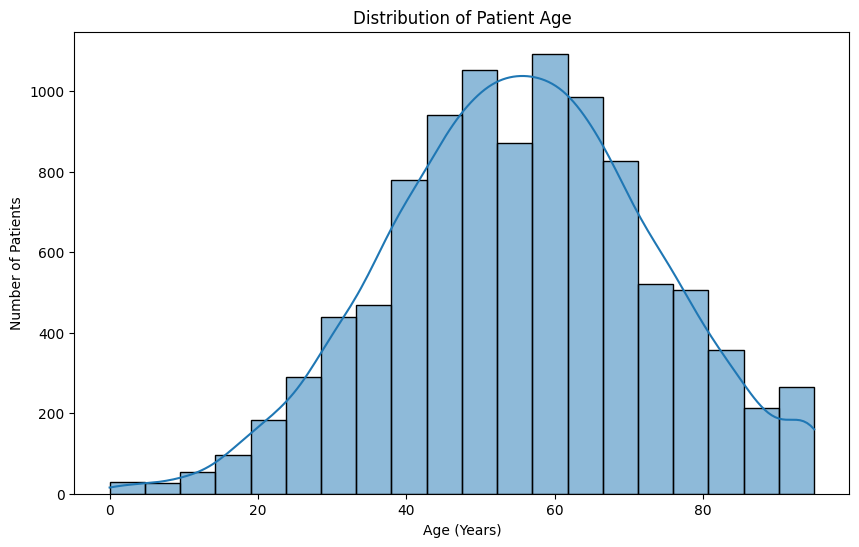

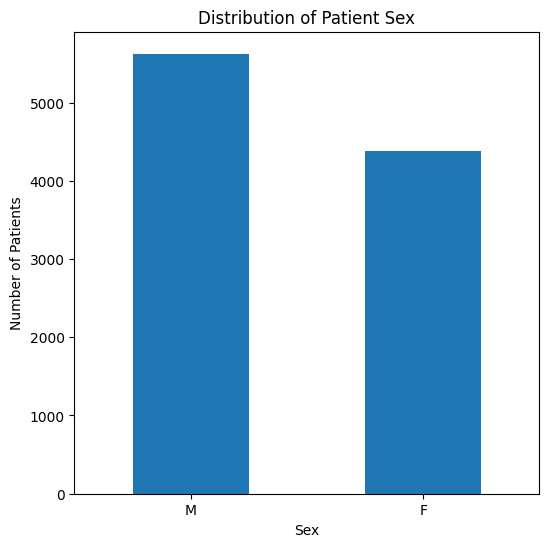

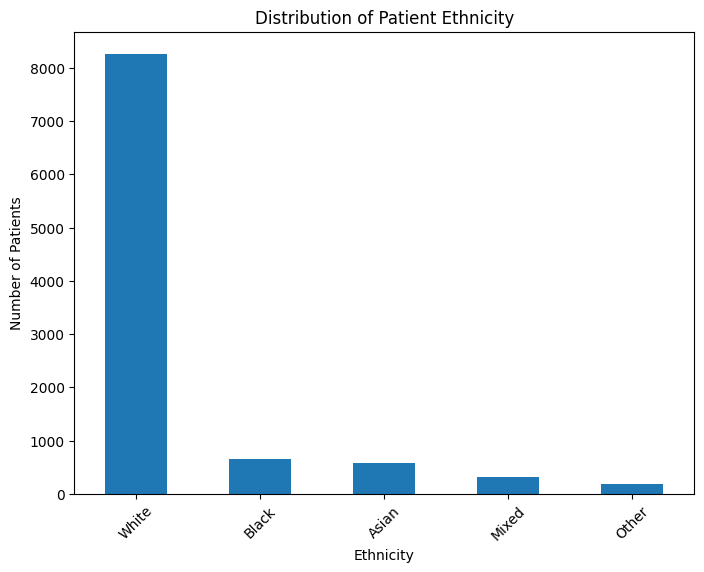

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.histplot(patients["age_years"], bins=20, kde=True)
plt.title("Distribution of Patient Age")
plt.xlabel("Age (Years)")
plt.ylabel("Number of Patients")
plt.show()

# Visualize sex distribution
plt.figure(figsize=(6, 6))
patients["sex"].value_counts().plot(kind="bar")
plt.title("Distribution of Patient Sex")
plt.xlabel("Sex")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.show()

# Visualize ethnicity distribution
plt.figure(figsize=(8, 6))
patients["ethnicity"].value_counts().plot(kind="bar")
plt.title("Distribution of Patient Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.show()

**Reasoning**:
Incorporate the consent data to filter access to model predictions based on patient consent.

In [85]:
# Prepare data for Chronic Disease Detection Model (Type 2 Diabetes - E11)

# Identify patients with Type 2 Diabetes (E11)
# A patient is considered to have Type 2 Diabetes if they have at least one condition entry with code 'E11'
patients_with_diabetes = fhir_conditions[fhir_conditions["code.coding.code"] == "E11"]["subject.reference"].unique()

# Create a target variable DataFrame at the patient level
# 1 if the patient has E11, 0 otherwise
patient_ids_all = fhir_patients["id"].unique() # Corrected column name to 'id'
diabetes_target = pd.DataFrame({
    "id": patient_ids_all, # Use 'id' for merging with fhir_patients
    "has_diabetes_E11": [1 if "Patient/"+patient_id in patients_with_diabetes else 0 for patient_id in patient_ids_all] # Match format in fhir_conditions
})

# Merge patient demographics with the target variable
chronic_disease_data = pd.merge(fhir_patients[["id", "gender", "extension.ethnicity", "extension.age_years", "extension.imd_quintile"]],
                                diabetes_target, on="id", how="left") # Merge on 'id'


# Aggregate relevant observations (HBA1C, BMI, BP_SYS, BP_DIA) by patient
# For simplicity, we will take the most recent value for each observation type per patient
latest_observations = observations.sort_values(by="taken_dt").drop_duplicates(subset=["patient_id", "code"], keep="last")

# Pivot observations to get one row per patient with columns for each observation type
obs_pivot = latest_observations.pivot(index="patient_id", columns="code", values="value_num").reset_index()
# obs_pivot.rename(columns={"patient_id": "subject.reference"}, inplace=True) # No longer needed, merge on 'patient_id' directly
# obs_pivot["subject.reference"] = "Patient/" + obs_pivot["subject.reference"] # No longer needed

# Merge aggregated observations with the main dataframe
chronic_disease_data = pd.merge(chronic_disease_data, obs_pivot, left_on="id", right_on="patient_id", how="left") # Merge on 'id' and 'patient_id'
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"]) # Drop redundant patient_id column


# Aggregate relevant medications (MET, INS) by patient
# Check if a patient has ever been prescribed MET or INS
meds_relevant = meds[meds["drug_code"].isin(["MET", "INS"])].copy()
# meds_relevant["subject.reference"] = "Patient/" + meds_relevant["patient_id"] # No longer needed
meds_presence = meds_relevant.groupby("patient_id")["drug_code"].agg(lambda x: list(set(x))).reset_index()
meds_presence.rename(columns={"drug_code": "medication_codes"}, inplace=True)

# Before merging, convert the list of medication codes into binary features
for drug in ["MET", "INS"]:
    meds_presence[f"has_medication_{drug}"] = meds_presence["medication_codes"].apply(lambda x: 1 if isinstance(x, list) and drug in x else 0)
meds_presence = meds_presence.drop(columns=["medication_codes"]) # Drop the original list column

chronic_disease_data = pd.merge(chronic_disease_data, meds_presence, left_on="id", right_on="patient_id", how="left") # Merge on 'id' and 'patient_id'
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"]) # Drop redundant patient_id column


# Aggregate presence of related conditions (E78, I10) by patient
conditions_relevant = fhir_conditions[fhir_conditions["code.coding.code"].isin(["E78", "I10"])].copy()
conditions_relevant["patient_id"] = conditions_relevant["subject.reference"].str.replace("Patient/", "") # Extract patient_id from subject.reference
conditions_presence = conditions_relevant.groupby("patient_id")["code.coding.code"].agg(lambda x: list(set(x))).reset_index()
conditions_presence.rename(columns={"code.coding.code": "related_condition_codes"}, inplace=True)

# Before merging, convert the list of related condition codes into binary features
for cond in ["E78", "I10"]:
    conditions_presence[f"has_related_condition_{cond}"] = conditions_presence["related_condition_codes"].apply(lambda x: 1 if isinstance(x, list) and cond in x else 0)
conditions_presence = conditions_presence.drop(columns=["related_condition_codes"]) # Drop the original list column


chronic_disease_data = pd.merge(chronic_disease_data, conditions_presence, left_on="id", right_on="patient_id", how="left") # Merge on 'id' and 'patient_id'
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"]) # Drop redundant patient_id column


# Handle missing values (impute numerical features with median, categorical with placeholder)
# For numerical observation and demographic features, impute with median
numerical_cols_chronic = chronic_disease_data.select_dtypes(include=np.number).columns.tolist()
# Exclude the target variable from imputation
numerical_cols_to_impute = [col for col in numerical_cols_chronic if col != "has_diabetes_E11"]

for col in numerical_cols_to_impute:
    if chronic_disease_data[col].isnull().any():
        median_val = chronic_disease_data[col].median()
        chronic_disease_data[col] = chronic_disease_data[col].fillna(median_val)

# For categorical features, impute with a placeholder 'Missing'
categorical_cols_chronic = chronic_disease_data.select_dtypes(include='object').columns.tolist()
# Exclude 'id' as it's an identifier
categorical_cols_to_impute = [col for col in categorical_cols_chronic if col != "id"]

for col in categorical_cols_to_impute:
     chronic_disease_data[col] = chronic_disease_data[col].fillna('Missing')


# Encode categorical features
chronic_disease_data = pd.get_dummies(chronic_disease_data, columns=categorical_cols_to_impute, dummy_na=False, drop_first=True)


# Define features (X) and target (y)
chronic_disease_features = [col for col in chronic_disease_data.columns if col not in ["id", "has_diabetes_E11"]] # Exclude 'id'
chronic_disease_target = "has_diabetes_E11"

X_chronic = chronic_disease_data[chronic_disease_features]
y_chronic = chronic_disease_data[chronic_disease_target]

print("Prepared data for Chronic Disease Detection model.")
print("Features shape:", X_chronic.shape)
print("Target shape:", y_chronic.shape)
display(X_chronic.head())
display(y_chronic.head())

Prepared data for Chronic Disease Detection model.
Features shape: (10000, 17)
Target shape: (10000,)


,extension.age_years,extension.imd_quintile,BMI,BP_DIA,BP_SYS,CHOL,CREAT,HBA1C,has_medication_MET,has_medication_INS,has_related_condition_E78,has_related_condition_I10,gender_M,extension.ethnicity_Black,extension.ethnicity_Mixed,extension.ethnicity_Other,extension.ethnicity_White
0,64,2,32.2,85.1,134.8,5.47,87.89,43.11,1.0,1.0,1.0,1.0,False,False,False,False,True
1,53,2,32.2,85.1,134.8,5.47,87.89,43.11,1.0,1.0,1.0,1.0,False,False,False,False,True
2,67,3,32.2,85.1,134.8,5.47,87.89,43.11,1.0,1.0,1.0,1.0,False,False,True,False,False
3,83,2,32.2,85.1,134.8,5.47,87.89,43.11,1.0,1.0,1.0,1.0,False,False,False,False,True
4,51,3,32.2,85.1,134.8,5.47,87.89,43.11,1.0,1.0,1.0,1.0,True,False,False,False,True


,has_diabetes_E11
0,0
1,0
2,0
3,0
4,0


**Reasoning**:
Visualize the prevalence of Type 2 Diabetes (E11) in the dataset.

Prevalence of Type 2 Diabetes (E11):
has_diabetes_E11
0    99.72
1     0.28
Name: proportion, dtype: float64


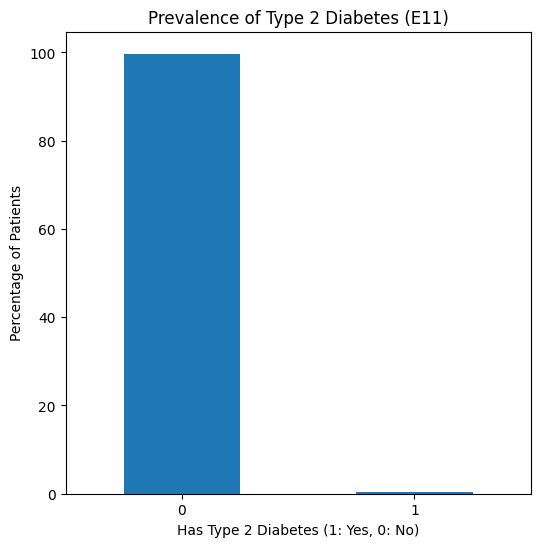

In [92]:
# Calculate the prevalence of Type 2 Diabetes (E11)
diabetes_prevalence = chronic_disease_data["has_diabetes_E11"].value_counts(normalize=True) * 100

print("Prevalence of Type 2 Diabetes (E11):")
print(diabetes_prevalence)

# Visualize the prevalence
plt.figure(figsize=(6, 6))
diabetes_prevalence.plot(kind="bar")
plt.title("Prevalence of Type 2 Diabetes (E11)")
plt.xlabel("Has Type 2 Diabetes (1: Yes, 0: No)")
plt.ylabel("Percentage of Patients")
plt.xticks(rotation=0)
plt.show()

In [82]:
# Re-run data preparation, ensuring NaN handling is applied to X_readmission before SMOTE

# Merge fhir_encounters with fhir_patients to bring in patient demographics
readmission_data = pd.merge(fhir_encounters, fhir_patients[["id", "gender", "extension.ethnicity", "extension.age_years", "extension.imd_quintile"]],
                            left_on="subject.reference", right_on="id", how="left", suffixes=('', '_patient'))
readmission_data = readmission_data.drop(columns=["id_patient"]) # Drop redundant patient id column

# Aggregate conditions by encounter and merge
condition_list_per_encounter = fhir_conditions.groupby("encounter.reference")["code.coding.code"].agg(list).reset_index()
condition_list_per_encounter.rename(columns={"encounter.reference": "encounter_id", "code.coding.code": "condition_codes"}, inplace=True)
condition_list_per_encounter["encounter_id"] = condition_list_per_encounter["encounter_id"].str.replace("Encounter/", "")

readmission_data = pd.merge(readmission_data, condition_list_per_encounter, left_on="id", right_on="encounter_id", how="left")
readmission_data = readmission_data.drop(columns=["encounter_id"])

# Simplify condition features: presence of common conditions
common_conditions = ["I10", "E11", "I50", "J45", "J44", "N18", "C34", "C50", "F32", "E78"]
for cond in common_conditions:
    readmission_data[f"has_condition_{cond}"] = readmission_data["condition_codes"].apply(lambda x: 1 if isinstance(x, list) and cond in x else 0)
readmission_data = readmission_data.drop(columns=["condition_codes"])

# Identify potential feature columns (excluding IDs, references, dates, and target)
potential_feature_cols = [col for col in readmission_data.columns if col not in ["id", "patient_id", "subject.reference", "encounter.reference", "period.start", "period.end", "extension.readmission_30d", "extension.mortality_90d"]]

# Separate numerical and categorical columns among the potential features
numerical_cols = readmission_data[potential_feature_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = readmission_data[potential_feature_cols].select_dtypes(include='object').columns.tolist()

# Handle missing values in categorical columns *before* one-hot encoding (impute with a placeholder)
for col in categorical_cols:
    readmission_data[col] = readmission_data[col].fillna('Missing')

# One-hot encode categorical features
readmission_data = pd.get_dummies(readmission_data, columns=categorical_cols, dummy_na=False, drop_first=True)

# Define the final list of features after one-hot encoding, EXCLUDING columns with NaNs
final_feature_cols = [col for col in readmission_data.columns if col not in ["id", "patient_id", "subject.reference", "encounter.reference", "period.start", "period.end", "extension.readmission_30d", "extension.mortality_90d", "extension.age_years", "extension.imd_quintile"]]


# Select the feature DataFrame
X_readmission = readmission_data[final_feature_cols].copy() # Use .copy() to ensure operations modify this DataFrame

# Define the target Series
y_readmission = readmission_data["extension.readmission_30d"]

# Check for NaNs specifically in X_readmission before imputation (should be none now)
print("\nChecking for NaN values in X_readmission before imputation:")
nan_cols_before_imputation = X_readmission.isnull().sum()[X_readmission.isnull().sum() > 0]
print(nan_cols_before_imputation)

# Impute any remaining NaNs in numeric columns in X_readmission using median
# This step is a safeguard in case any other NaNs were introduced
for col in X_readmission.select_dtypes(include=np.number).columns:
    if X_readmission[col].isnull().any():
        median_val = X_readmission[col].median()
        X_readmission[col] = X_readmission[col].fillna(median_val)


# Verify that the feature DataFrame contains only numeric types and no NaN values AFTER imputation
non_numeric_cols_final = X_readmission.select_dtypes(exclude=np.number).columns
print("\nNon-numeric columns in X_readmission after imputation:", non_numeric_cols_final)
print("NaN values in X_readmission after imputation:", X_readmission.isnull().sum().sum())


# Split the cleaned data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE # Import SMOTE

# Double-check for NaNs immediately before splitting
print("\nFinal check for NaN values in X_readmission before splitting:")
print(X_readmission.isnull().sum().sum())


X_train_readmission, X_test_readmission, y_train_readmission, y_test_readmission = train_test_split(
    X_readmission, y_readmission, test_size=0.2, random_state=RANDOM_SEED, stratify=y_readmission
)

# Apply SMOTE to the training data
print("\nApplying SMOTE to the training data...")
smote = SMOTE(random_state=RANDOM_SEED)
X_train_readmission_resampled, y_train_readmission_resampled = smote.fit_resample(X_train_readmission, y_train_readmission)

print("Original training shape:", X_train_readmission.shape, y_train_readmission.shape)
print("Resampled training shape:", X_train_readmission_resampled.shape, y_train_readmission_resampled.shape)
print("Class distribution after SMOTE:", y_train_readmission_resampled.value_counts())


# Train HistGradientBoostingClassifier model for readmission risk on resampled data
model_readmission = HistGradientBoostingClassifier(random_state=RANDOM_SEED)
model_readmission.fit(X_train_readmission_resampled, y_train_readmission_resampled)

# Evaluate the model
y_pred_readmission = model_readmission.predict(X_test_readmission)
y_pred_proba_readmission = model_readmission.predict_proba(X_test_readmission)[:, 1]

print("\nReadmission Risk Model Performance (HistGradientBoostingClassifier with SMOTE):")
print(classification_report(y_test_readmission, y_pred_readmission))
print("AUC:", roc_auc_score(y_test_readmission, y_pred_proba_readmission))


Checking for NaN values in X_readmission before imputation:
Series([], dtype: int64)

Non-numeric columns in X_readmission after imputation: Index(['class.code_inpatient', 'class.code_outpatient', 'class.code_virtual',
       'location.display_Manchester Royal Infirmary',
       'location.display_North Manchester General',
       'location.display_Rochdale Infirmary',
       'location.display_Royal Oldham Hospital',
       'location.display_Salford Royal Hospital',
       'location.display_Stockport NHS Foundation Trust',
       'location.display_Tameside General Hospital',
       'location.display_Trafford General Hospital',
       'location.display_Wythenshawe Hospital',
       'serviceProvider.display_Emergency Medicine',
       'serviceProvider.display_Endocrinology',
       'serviceProvider.display_General Medicine',
       'serviceProvider.display_General Surgery',
       'serviceProvider.display_Geriatrics',
       'serviceProvider.display_Neurology', 'serviceProvider.display_O

**Reasoning**:
Visualize the performance metrics (Precision, Recall, F1-score, AUC) of the readmission risk model to provide a clear overview of its effectiveness.

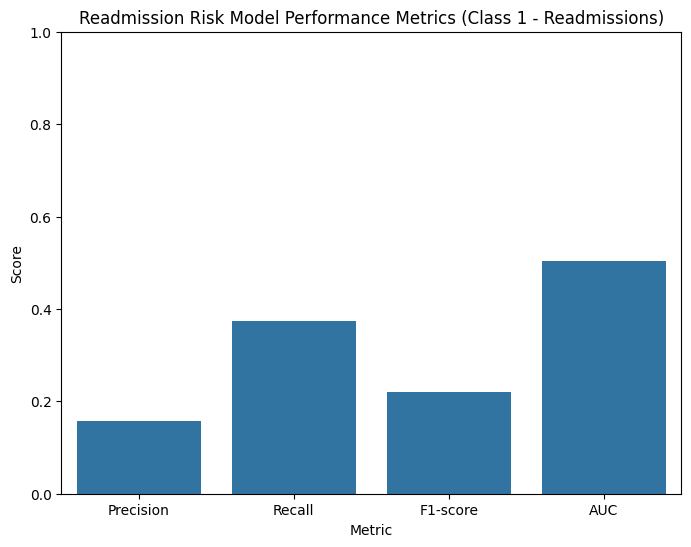

✅ Visualized readmission risk model performance metrics.


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score

# Re-calculate metrics for clarity, using the results from the last readmission model evaluation
# Assuming y_test_readmission, y_pred_readmission, and y_pred_proba_readmission are available from the previous step

report = classification_report(y_test_readmission, y_pred_readmission, output_dict=True)
auc_score = roc_auc_score(y_test_readmission, y_pred_proba_readmission)

# Extract metrics for class 1 (readmissions)
metrics = {
    "Precision": report["1"]["precision"],
    "Recall": report["1"]["recall"],
    "F1-score": report["1"]["f1-score"],
    "AUC": auc_score
}

metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Score"])

plt.figure(figsize=(8, 6))
sns.barplot(x="Metric", y="Score", data=metrics_df)
plt.title("Readmission Risk Model Performance Metrics (Class 1 - Readmissions)")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.show()

print("✅ Visualized readmission risk model performance metrics.")

Generating SHAP summary plot...


/tmp/ipython-input-20306253.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset)


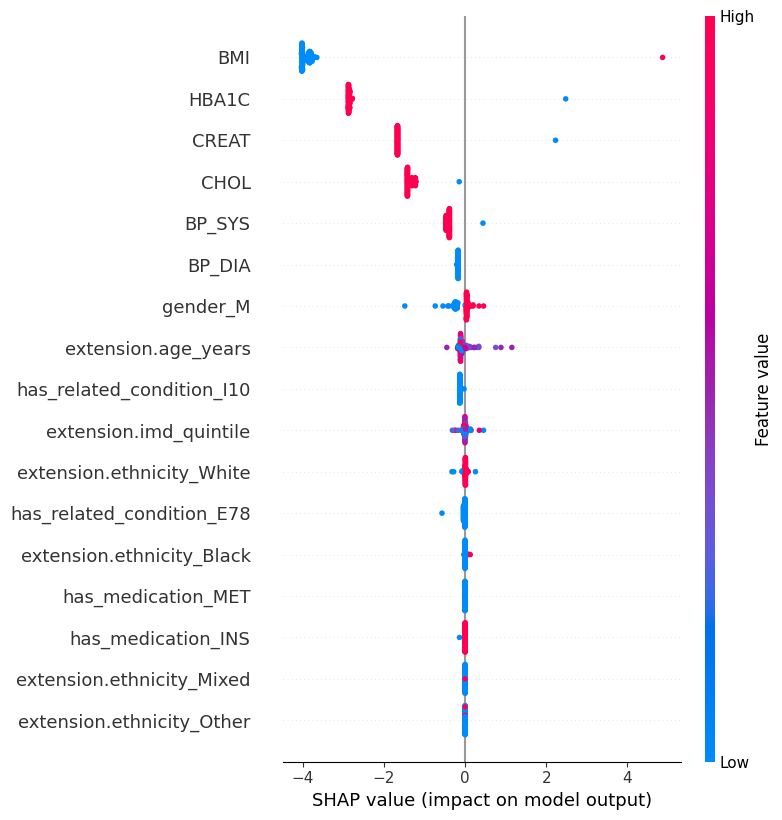


Generating SHAP dependence plot for a sample feature...


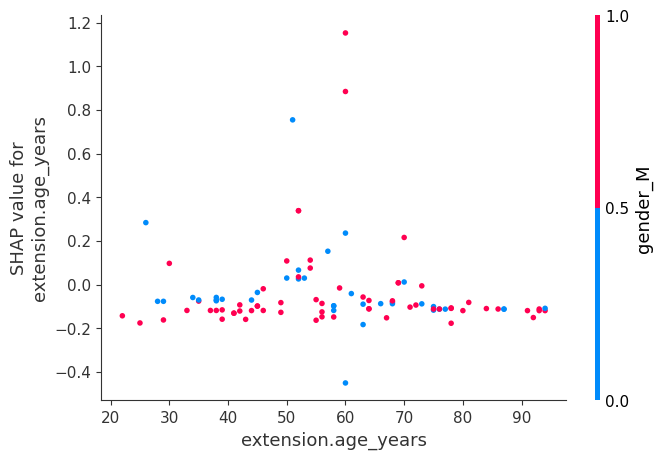

In [94]:
# Visualize the SHAP values
# Summary plot: shows the importance of features
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_test_subset)

# Dependence plot: shows the effect of a single feature across the whole dataset
# Choose a feature to visualize (e.g., the most important feature from the summary plot)
# Replace 'feature_name' with the actual name of a feature from X_test_subset.columns
# For example, if 'extension.age_years' was important:
# shap.dependence_plot("extension.age_years", shap_values, X_test_subset)

print("\nGenerating SHAP dependence plot for a sample feature...")
# You can replace 'extension.age_years' with another feature name from X_test_subset.columns
# For example, if 'extension.age_years' is available and relevant:
if 'extension.age_years' in X_test_subset.columns:
    shap.dependence_plot("extension.age_years", shap_values, X_test_subset)
elif X_test_subset.columns.tolist(): # Check if there are any columns to plot
    # Plot the dependence plot for the first feature if age is not available
    shap.dependence_plot(X_test_subset.columns[0], shap_values, X_test_subset)
else:
    print("No features available to generate a dependence plot.")

# Individual prediction explanation (force plot)
# Select an instance to explain (e.g., the first instance in the subset)
# instance_idx = 0
# print(f"\nGenerating SHAP force plot for instance {instance_idx}...")
# shap.force_plot(explainer.expected_value, shap_values[instance_idx,:], X_test_subset.iloc[instance_idx,:])

In [110]:
import streamlit as st
import streamlit.components.v1 as components
import shap
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


# Define relative paths for data loading
DATA_DIR = "data"
DATA_LAKE_DIR = "data_lake"

# Load datasets (assuming they are in the specified relative paths)
try:
    patients = pd.read_csv(os.path.join(DATA_DIR, "patients.csv"))
    encounters = pd.read_csv(os.path.join(DATA_DIR, "encounters.csv"))
    conditions = pd.read_csv(os.path.join(DATA_DIR, "conditions.csv"))
    observations = pd.read_csv(os.path.join(DATA_DIR, "observations.csv"))
    meds = pd.read_csv(os.path.join(DATA_DIR, "medication_requests.csv"))
    outcomes = pd.read_csv(os.path.join(DATA_DIR, "outcomes.csv"))
    consent = pd.read_csv(os.path.join(DATA_DIR, "consent.csv"))
    users = pd.read_csv(os.path.join(DATA_DIR, "users.csv"))
    audit_log = pd.read_csv(os.path.join(DATA_DIR, "audit_log.csv"))

    # Load FHIR-like datasets from the data lake structure
    fhir_patients = pd.read_csv(os.path.join(DATA_LAKE_DIR, "patients", "fhir_patients.csv"))
    fhir_encounters = pd.read_csv(os.path.join(DATA_LAKE_DIR, "encounters", "fhir_encounters.csv"))
    fhir_conditions = pd.read_csv(os.path.join(DATA_LAKE_DIR, "conditions", "fhir_conditions.csv"))
    fhir_observations = pd.read_csv(os.path.join(DATA_LAKE_DIR, "observations", "fhir_observations.csv"))
    fhir_meds = pd.read_csv(os.path.join(DATA_LAKE_DIR, "medication_requests", "fhir_medication_requests.csv"))

except FileNotFoundError as e:
    st.error(f"Error loading data files: {e}. Please ensure the 'data' and 'data_lake' directories with the necessary CSVs are in the same directory as app.py.")
    st.stop() # Stop the app if data loading fails

# Define the datasets dictionary at the top level so it's accessible everywhere
datasets = {
    "patients.csv": patients,
    "encounters.csv": encounters,
    "conditions.csv": conditions,
    "observations.csv": observations,
    "medication_requests.csv": meds,
    "outcomes.csv": outcomes,
    "consent.csv": consent,
    "users.csv": users,
    "audit_log.csv": audit_log
}


# Assume common_conditions list is available
common_conditions = ["I10", "E11", "I50", "J45", "J44", "N18", "C34", "C50", "F32", "E78"]

# Data Preparation for Models (ensure this is re-run if kernel state is lost)
# Readmission Model Data Prep
readmission_data = pd.merge(fhir_encounters, fhir_patients[["id", "gender", "extension.ethnicity", "extension.age_years", "extension.imd_quintile"]],
                            left_on="subject.reference", right_on="id", how="left", suffixes=('', '_patient'))
readmission_data = readmission_data.drop(columns=["id_patient"]) # Drop redundant patient id column

# Aggregate conditions by encounter and merge
condition_list_per_encounter = fhir_conditions.groupby("encounter.reference")["code.coding.code"].agg(list).reset_index()
condition_list_per_encounter.rename(columns={"encounter.reference": "encounter_id", "code.coding.code": "condition_codes"}, inplace=True)
condition_list_per_encounter["encounter_id"] = condition_list_per_encounter["encounter_id"].str.replace("Encounter/", "")

readmission_data = pd.merge(readmission_data, condition_list_per_encounter, left_on="id", right_on="encounter_id", how="left")
readmission_data = readmission_data.drop(columns=["encounter_id"])

# Simplify condition features: presence of common conditions
for cond in common_conditions:
    readmission_data[f"has_condition_{cond}"] = readmission_data["condition_codes"].apply(lambda x: 1 if isinstance(x, list) and cond in x else 0)
readmission_data = readmission_data.drop(columns=["condition_codes"])

# Identify potential feature columns (excluding IDs, references, dates, and target)
potential_feature_cols = [col for col in readmission_data.columns if col not in ["id", "patient_id", "subject.reference", "encounter.reference", "period.start", "period.end", "extension.readmission_30d", "extension.mortality_90d"]]

# Separate numerical and categorical columns among the potential features
numerical_cols = readmission_data[potential_feature_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = readmission_data[potential_feature_cols].select_dtypes(include='object').columns.tolist()

# Handle missing values in categorical columns *before* one-hot encoding (impute with a placeholder)
for col in categorical_cols:
    readmission_data[col] = readmission_data[col].fillna('Missing')

# One-hot encode categorical features
readmission_data = pd.get_dummies(readmission_data, columns=categorical_cols, dummy_na=False, drop_first=True)

# Define the final list of features after one-hot encoding, EXCLUDING columns with NaNs
final_feature_cols = [col for col in readmission_data.columns if col not in ["id", "patient_id", "subject.reference", "encounter.reference", "period.start", "period.end", "extension.readmission_30d", "extension.mortality_90d", "extension.age_years", "extension.imd_quintile"]]


# Select the feature DataFrame
X_readmission = readmission_data[final_feature_cols].copy() # Use .copy() to ensure operations modify this DataFrame

# Define the target Series
y_readmission = readmission_data["extension.readmission_30d"]

# Check for NaNs specifically in X_readmission before imputation (should be none now)
# print("\nChecking for NaN values in X_readmission before imputation:")
# nan_cols_before_imputation = X_readmission.isnull().sum()[X_readmission.isnull().sum() > 0]
# print(nan_cols_before_imputation)

# Impute any remaining NaNs in numeric columns in X_readmission using median
# This step is a safeguard in case any other NaNs were introduced
for col in X_readmission.select_dtypes(include=np.number).columns:
    if X_readmission[col].isnull().any():
        median_val = X_readmission[col].median()
        X_readmission[col] = X_readmission[col].fillna(median_val)


# Verify that the feature DataFrame contains only numeric types and no NaN values AFTER imputation
# non_numeric_cols_final = X_readmission.select_dtypes(exclude=np.number).columns
# print("\nNon-numeric columns in X_readmission after imputation:", non_numeric_cols_final)
# print("NaN values in X_readmission after imputation:", X_readmission.isnull().sum().sum())


# Split the cleaned data into training and testing sets
X_train_readmission, X_test_readmission, y_train_readmission, y_test_readmission = train_test_split(
    X_readmission, y_readmission, test_size=0.2, random_state=42, stratify=y_readmission # Use a fixed random_state
)
smote = SMOTE(random_state=42) # Use a fixed random_state
X_train_readmission_resampled, y_train_readmission_resampled = smote.fit_resample(X_train_readmission, y_train_readmission)
model_readmission = HistGradientBoostingClassifier(random_state=42) # Use a fixed random_state
model_readmission.fit(X_train_readmission_resampled, y_train_readmission_resampled)


# Data Preparation for Chronic Disease Model (ensure this is re-run if kernel state is lost)
patients_with_diabetes = fhir_conditions[fhir_conditions["code.coding.code"] == "E11"]["subject.reference"].unique()
patient_ids_all = fhir_patients["id"].unique()
diabetes_target = pd.DataFrame({
    "id": patient_ids_all,
    "has_diabetes_E11": [1 if "Patient/"+patient_id in patients_with_diabetes else 0 for patient_id in patient_ids_all]
})
chronic_disease_data = pd.merge(fhir_patients[["id", "gender", "extension.ethnicity", "extension.age_years", "extension.imd_quintile"]],
                                diabetes_target, on="id", how="left")
latest_observations = observations.sort_values(by="taken_dt").drop_duplicates(subset=["patient_id", "code"], keep="last")
obs_pivot = latest_observations.pivot(index="patient_id", columns="code", values="value_num").reset_index()
chronic_disease_data = pd.merge(chronic_disease_data, obs_pivot, left_on="id", right_on="patient_id", how="left")
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"])
meds_relevant = meds[meds["drug_code"].isin(["MET", "INS"])].copy()
meds_presence = meds_relevant.groupby("patient_id")["drug_code"].agg(lambda x: list(set(x))).reset_index()
meds_presence.rename(columns={"drug_code": "medication_codes"}, inplace=True)
for drug in ["MET", "INS"]:
    meds_presence[f"has_medication_{drug}"] = meds_presence["medication_codes"].apply(lambda x: 1 if isinstance(x, list) and drug in x else 0)
meds_presence = meds_presence.drop(columns=["medication_codes"])
chronic_disease_data = pd.merge(chronic_disease_data, meds_presence, left_on="id", right_on="patient_id", how="left")
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"])
conditions_relevant_chronic = fhir_conditions[fhir_conditions["code.coding.code"].isin(["E78", "I10"])].copy()
conditions_relevant_chronic["patient_id"] = conditions_relevant_chronic["subject.reference"].str.replace("Patient/", "")
conditions_presence_chronic = conditions_relevant_chronic.groupby("patient_id")["code.coding.code"].agg(lambda x: list(set(x))).reset_index()
conditions_presence_chronic.rename(columns={"code.coding.code": "related_condition_codes"}, inplace=True)
for cond in ["E78", "I10"]:
    conditions_presence_chronic[f"has_related_condition_{cond}"] = conditions_presence_chronic["related_condition_codes"].apply(lambda x: 1 if isinstance(x, list) and cond in x else 0)
conditions_presence_chronic = conditions_presence_chronic.drop(columns=["related_condition_codes"])
chronic_disease_data = pd.merge(chronic_disease_data, conditions_presence_chronic, left_on="id", right_on="patient_id", how="left")
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"])

numerical_cols_chronic = chronic_disease_data.select_dtypes(include=np.number).columns.tolist()
numerical_cols_to_impute_chronic = [col for col in numerical_cols_chronic if col != "has_diabetes_E11"]
for col in numerical_cols_to_impute_chronic:
    if chronic_disease_data[col].isnull().any():
        median_val = chronic_disease_data[col].median()
        chronic_disease_data[col] = chronic_disease_data[col].fillna(median_val)

categorical_cols_chronic = chronic_disease_data.select_dtypes(include='object').columns.tolist()
categorical_cols_to_impute_chronic = [col for col in categorical_cols_chronic if col != "id"]
for col in categorical_cols_to_impute_chronic:
     chronic_disease_data[col] = chronic_disease_data[col].fillna('Missing')

chronic_disease_data = pd.get_dummies(chronic_disease_data, columns=categorical_cols_to_impute_chronic, dummy_na=False, drop_first=True)
chronic_disease_features = [col for col in chronic_disease_data.columns if col not in ["id", "has_diabetes_E11"]]
chronic_disease_target = "has_diabetes_E11"
X_chronic = chronic_disease_data[chronic_disease_features]
y_chronic = chronic_disease_data[chronic_disease_target]

# Train Chronic Disease Model (ensure this is re-run if kernel state is lost)
X_train_chronic, X_test_chronic, y_train_chronic, y_test_chronic = train_test_split(
    X_chronic, y_chronic, test_size=0.2, random_state=42, stratify=y_chronic # Use a fixed random_state
)
smote_chronic = SMOTE(random_state=42) # Use a fixed random_state
X_train_chronic_resampled, y_train_chronic_resampled = smote_chronic.fit_resample(X_train_chronic, y_chronic)
model_chronic = HistGradientBoostingClassifier(random_state=42) # Use a fixed random_state
model_chronic.fit(X_train_chronic_resampled, y_train_chronic_resampled)


# Secure Access Functions (ensure these are available)
def check_permission(user_id, resource):
    \"\"\"Simulates checking user permissions based on role and resource.\"\"\"
    # Ensure 'users' DataFrame is accessible globally or passed
    if 'users' not in globals() or users.empty:
        return False # Cannot check permission if users data is not loaded or empty

    user_info = users[users["user_id"] == user_id]
    if user_info.empty:
        return False # User not found

    user_role = user_info["role"].iloc[0]

    # Define access rules
    if user_role == "Admin":
        return True  # Admins can access all resources
    elif user_role == "Analyst":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes", "users"] # Analysts can read most clinical data
    elif user_role == "Clinician":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"] # Clinicians can access clinical data
    elif user_role == "Researcher":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"] # Researchers can access research data (subject to consent/anonymization, simplified here)
    else:
        return False # Deny access for unknown roles

# Global audit_log DataFrame (initialized empty or loaded)
if 'audit_log' not in globals():
    audit_log = pd.DataFrame(columns=["log_id", "user_id", "action", "resource", "timestamp", "purpose_of_use", "result"])

def log_access(user_id, action, resource, purpose_of_use, result):
    \"\"\"Logs data access attempts.\"\"\"
    global audit_log
    log_entry = {
        "log_id": f"L{{str(len(audit_log) + 1).zfill(7)}}",
        "user_id": user_id,
        "action": action,
        "resource": resource,
        "timestamp": datetime.now().isoformat(sep=" "),
        "purpose_of_use": purpose_of_use,
        "result": result
    }
    # Using pd.concat to append a new row
    # Check if audit_log is empty to handle initial case
    if audit_log.empty:
        audit_log = pd.DataFrame([log_entry])
    else:
        audit_log = pd.concat([audit_log, pd.DataFrame([log_entry])], ignore_index=True)


def retrieve_data(user_id, resource, patient_id=None, purpose_of_use="unknown", allow_research=None):
    \"\"\"Simulates data retrieval based on user permissions and optional filtering, with logging and consent check.\"\"\"
    has_permission = check_permission(user_id, resource)
    action = "READ" # Assuming retrieval is a READ action for logging
    user_info = users[users["user_id"] == user_id]
    if user_info.empty:
        log_access(user_id, action, resource, purpose_of_use, "denied - user not found")
        return f"Access Denied: User {user_id} not found."
    user_role = user_info["role"].iloc[0]


    # Enforce consent for Researchers accessing patient-specific data
    if user_role == "Researcher" and patient_id:
        # Ensure consent DataFrame is accessible globally or passed
        if 'consent' not in globals() or consent.empty:
            log_access(user_id, action, resource, purpose_of_use, "denied - consent data not available")
            return f"Access Denied: Consent data not available."

        patient_consent_info = consent[consent["patient_id"] == patient_id]

        if patient_consent_info.empty:
             # Consent information not available for this patient
             log_access(user_id, action, resource, purpose_of_use, "denied - consent unknown for patient")
             return f"Access Denied: Consent status unknown for patient {patient_id}. Access denied."
        elif patient_consent_info["allow_research"].iloc[0] == 0:
            # Patient has not consented to research, deny access
            log_access(user_id, action, resource, purpose_of_use, "denied - no research consent")
            return f"Access Denied: Patient {patient_id} has not consented to research."


    if not has_permission:
        log_access(user_id, action, resource, purpose_of_use, "denied")
        return f"Access Denied: User {user_id} does not have permission to access {resource}."

    # Load the FHIR-like data for the resource
    try:
        df_name = f"fhir_{resource}" if resource not in ["users", "audit_log", "consent"] else resource
        # Adjust path for loading from data_lake directory structure
        file_path = os.path.join(DATA_LAKE_DIR, resource, f"fhir_{resource}.csv") if resource not in ["users", "audit_log", "consent"] else os.path.join(DATA_DIR, f"{resource}.csv")

        df = pd.read_csv(file_path)
        log_access(user_id, action, resource, purpose_of_use, "success")
    except FileNotFoundError:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"Error: Resource '{resource}' not found at {file_path}."
    except Exception as e:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"An error occurred: {e}"


    # Implement filtering based on user role and optional criteria

    if user_role == "Clinician" and patient_id:
        if resource == "patients":
            return df[df["id"] == patient_id]
        elif resource in ["encounters", "conditions", "observations", "medication_requests", "outcomes"]:
             return df[df["subject.reference"] == f"Patient/{patient_id}"]
        else:
             return "Filtering by patient ID is not supported for this resource."


    elif user_role == "Researcher" and resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"]:
        # Simulate consent check and anonymization (simplified) - this part is now handled before access is granted
        # Ensure consent DataFrame is accessible globally
        if 'consent' not in globals() or consent.empty:
             return "Consent data not available for filtering." # Should be caught earlier, but as a safeguard

        allowed_patients = consent[consent["allow_research"] == 1]["patient_id"].unique()
        if resource == "patients":
             return df[df["id"].isin(allowed_patients)]
        else:
             return df[df["subject.reference"].isin([f"Patient/{pid}" for pid in allowed_patients])]

    # Default: return the full (or mostly full for Analyst) dataset if allowed
    if user_role == "Analyst" and resource == "patients":
         # Simulate anonymization for Analyst (e.g., drop NHS number hash)
         return df.drop(columns=["nhs_number_hash"], errors="ignore")

    return df


# Streamlit App Layout and Content
st.set_page_config(layout="wide")

st.title("AI-Ready Health Data Platform Showcase")
st.write("This application demonstrates the key features of an AI-Ready Health Data Platform using synthetic NHS data.")

# Add navigation options to the sidebar
page = st.sidebar.radio(
    "Select a section",
    ["Data Overview", "Predictive Models", "Secure Access & Governance"]
)

if page == "Data Overview":
    st.header("Data Overview")
    st.write("Explore the synthetic NHS datasets and their FHIR-like transformations.")

    # Add tabs for different data views
    tab1, tab2, tab3, tab4 = st.tabs(["Synthetic Datasets", "FHIR-like Datasets", "Demographics Visualizations", "Observations Visualizations"])

    with tab1:
        st.subheader("Synthetic NHS Datasets")
        # Display synthetic datasets
        # datasets dictionary is now defined at the top level
        for name, df in datasets.items():
            st.subheader(f"Dataset: {name}")
            st.write("First 5 rows:")
            st.dataframe(df.head())
            st.write(f"Shape: {df.shape}")

    with tab2:
        st.subheader("FHIR-like Transformed Datasets")
        fhir_datasets = {
            "fhir_patients.csv": fhir_patients,
            "fhir_encounters.csv": fhir_encounters,
            "fhir_conditions.csv": fhir_conditions,
            "fhir_observations.csv": fhir_observations,
            "fhir_medication_requests.csv": fhir_meds
        }
        # Display FHIR-like datasets
        for name, df in fhir_datasets.items():
            st.subheader(f"FHIR-like Dataset: {name}")
            st.write("First 5 rows:")
            st.dataframe(df.head())
            st.write(f"Shape: {df.shape}")

    with tab3:
        st.subheader("Demographics Visualizations")
        # Visualize age distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(patients["age_years"], bins=20, kde=True)
        plt.title("Distribution of Patient Age")
        plt.xlabel("Age (Years)")
        plt.ylabel("Number of Patients")
        st.pyplot(plt) # Use st.pyplot to display matplotlib figures
        plt.close() # Close the plot to free memory

        # Visualize sex distribution
        plt.figure(figsize=(6, 6))
        patients["sex"].value_counts().plot(kind="bar")
        plt.title("Distribution of Patient Sex")
        plt.xlabel("Sex")
        plt.ylabel("Number of Patients")
        plt.xticks(rotation=0)
        st.pyplot(plt) # Use st.pyplot
        plt.close() # Close the plot

        # Visualize ethnicity distribution
        plt.figure(figsize=(8, 6))
        patients["ethnicity"].value_counts().plot(kind="bar")
        plt.title("Distribution of Patient Ethnicity")
        plt.xlabel("Ethnicity")
        plt.ylabel("Number of Patients")
        plt.xticks(rotation=45)
        st.pyplot(plt) # Use st.pyplot
        plt.close() # Close the plot

    with tab4:
        st.subheader("Observations Visualizations")
        # Filter observations for BP and BMI
        bp_bmi_observations = observations[observations["code"].isin(["BP_SYS", "BP_DIA", "BMI"])].copy()

        # Visualize distribution of BP_SYS
        plt.figure(figsize=(10, 6))
        sns.histplot(bp_bmi_observations[bp_bmi_observations["code"] == "BP_SYS"]["value_num"], bins=30, kde=True)
        plt.title("Distribution of Systolic Blood Pressure (BP_SYS)")
        plt.xlabel("BP_SYS (mmHg)")
        plt.ylabel("Frequency")
        st.pyplot(plt) # Use st.pyplot
        plt.close() # Close the plot

        # Visualize distribution of BP_DIA
        plt.figure(figsize=(10, 6))
        sns.histplot(bp_bmi_observations[bp_bmi_observations["code"] == "BP_DIA"]["value_num"], bins=30, kde=True)
        plt.title("Distribution of Diastolic Blood Pressure (BP_DIA)")
        plt.xlabel("BP_DIA (mmHg)")
        plt.ylabel("Frequency")
        st.pyplot(plt) # Use st.pyplot
        plt.close() # Close the plot

        # Visualize distribution of BMI
        plt.figure(figsize=(10, 6))
        sns.histplot(bp_bmi_observations[bp_bmi_observations["code"] == "BMI"]["value_num"], bins=30, kde=True)
        plt.title("Distribution of BMI")
        plt.xlabel("BMI (kg/m2)")
        plt.ylabel("Frequency")
        st.pyplot(plt) # Use st.pyplot
        plt.close() # Close the plot


elif page == "Predictive Models":
    st.header("Predictive Models")
    st.write("This section showcases the predictive models for readmission risk and chronic disease detection.")

    # Add tabs for different model views
    model_tab1, model_tab2 = st.tabs(["Readmission Risk Model", "Chronic Disease Detection Model"])

    with model_tab1:
        st.subheader("Readmission Risk Model")
        st.write("Provide the following patient and encounter details to predict readmission risk:")

        # Input fields for Readmission Risk Model (corresponding to X_readmission columns)
        # Numerical features
        los_days = st.number_input("Length of Stay (days)", min_value=0, value=int(X_readmission['extension.los_days'].median()), key="readmission_los")

        # Categorical features (need to map back from one-hot encoded columns)
        st.write("Encounter Type:")
        encounter_types = ['inpatient', 'outpatient', 'emergency', 'virtual']
        selected_encounter_type = st.radio("Select Encounter Type", encounter_types, key="readmission_etype")

        st.write("Admitting Specialty:")
        specialties = encounters["admitting_specialty"].unique().tolist()
        selected_specialty = st.selectbox("Select Admitting Specialty", specialties, key="readmission_specialty")

        st.write("Gender:")
        genders = patients["sex"].unique().tolist()
        selected_gender_readmission = st.radio("Select Gender", genders, key="readmission_gender")

        st.write("Ethnicity:")
        ethnicities = patients["ethnicity"].unique().tolist()
        selected_ethnicity_readmission = st.selectbox("Select Ethnicity", ethnicities, key="readmission_ethnicity")

        # Condition presence features (Assuming presence or absence)
        st.write("Present Conditions:")
        selected_conditions = st.multiselect("Select any applicable conditions", common_conditions, key="readmission_conditions")

        # Predict button for Readmission Risk Model
        if st.button("Predict Readmission Risk"):
            # Create a DataFrame from user inputs, matching X_readmission structure

            # Start with numerical features
            input_data_readmission = pd.DataFrame({'extension.los_days': [los_days]})

            # Handle one-hot encoded categorical features
            for etype in encounter_types:
                input_data_readmission[f'class.code_{etype}'] = 1 if selected_encounter_type == etype else 0

            for specialty in specialties:
                 input_data_readmission[f'serviceProvider.display_{specialty}'] = 1 if selected_specialty == specialty else 0

            for gender in genders:
                 input_data_readmission[f'gender_{gender}'] = 1 if selected_gender_readmission == gender else 0

            for ethnicity in ethnicities:
                 input_data_readmission[f'extension.ethnicity_{ethnicity}'] = 1 if selected_ethnicity_readmission == ethnicity else 0

            # Handle condition presence features
            for cond in common_conditions:
                input_data_readmission[f"has_condition_{cond}"] = 1 if cond in selected_conditions else 0


            # Ensure all columns in X_readmission are present in the input data, fill missing with 0
            # This is important if the user input doesn't cover all possible categories seen during training
            for col in X_readmission.columns:
                if col not in input_data_readmission.columns:
                    input_data_readmission[col] = 0

            # Reorder columns to match the training data
            input_data_readmission = input_data_readmission[X_readmission.columns]


            # Make prediction
            readmission_prediction = model_readmission.predict(input_data_readmission)[0]
            readmission_probability = model_readmission.predict_proba(input_data_readmission)[:, 1][0]

            # Display prediction
            st.subheader("Readmission Risk Prediction Result:")
            if readmission_prediction == 1:
                st.error(f"High Risk of Readmission (Probability: {readmission_probability:.2f})")
            else:
                st.success(f"Low Risk of Readmission (Probability: {readmission_probability:.2f})")

        st.markdown("---") # Separator

        st.subheader("Model Performance")
        # Visualize performance metrics for Readmission model
        report_readmission = classification_report(y_test_readmission, y_pred_readmission, output_dict=True)
        auc_score_readmission = roc_auc_score(y_test_readmission, y_pred_proba_readmission)

        metrics_readmission = {
            "Precision": report_readmission["1"]["precision"],
            "Recall": report_readmission["1"]["recall"],
            "F1-score": report_readmission["1"]["f1-score"],
            "AUC": auc_score_readmission
        }

        metrics_df_readmission = pd.DataFrame(list(metrics_readmission.items()), columns=["Metric", "Score"])

        plt.figure(figsize=(8, 6))
        sns.barplot(x="Metric", y="Score", data=metrics_df_readmission)
        plt.title("Readmission Risk Model Performance Metrics (Class 1 - Readmissions)")
        plt.ylabel("Score")
        plt.ylim(0, 1.0)
        st.pyplot(plt) # Use st.pyplot
        plt.close() # Close the plot

        st.subheader("Confusion Matrix")
        # Visualize Confusion Matrix for Readmission model
        cm_readmission = confusion_matrix(y_test_readmission, y_pred_readmission)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_readmission, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix (Readmission Risk Model)")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        st.pyplot(plt) # Use st.pyplot
        plt.close() # Close the plot


    with model_tab2:
        st.subheader("Chronic Disease Detection Model (Type 2 Diabetes - E11)")
        st.write("Provide the following patient observations and history to predict the risk of Type 2 Diabetes:")

        # Input fields for Chronic Disease Detection Model (corresponding to X_chronic columns)
        # Numerical features (simplified, assuming single values for demo)
        age_years = st.number_input("Age (Years)", min_value=0, max_value=100, value=int(chronic_disease_data['extension.age_years'].median()), key="chronic_age")
        imd_quintile = st.select_slider("IMD Quintile", options=[1, 2, 3, 4, 5], value=int(chronic_disease_data['extension.imd_quintile'].median()), key="chronic_imd")
        bmi = st.number_input("BMI (kg/m2)", min_value=10.0, max_value=60.0, value=float(chronic_disease_data['BMI'].median()), key="chronic_bmi")
        bp_sys = st.number_input("Systolic Blood Pressure (mmHg)", min_value=50.0, max_value=250.0, value=float(chronic_disease_data['BP_SYS'].median()), key="chronic_bpsys")
        bp_dia = st.number_input("Diastolic Blood Pressure (mmHg)", min_value=30.0, max_value=150.0, value=float(chronic_disease_data['BP_DIA'].median()), key="chronic_bpdia")
        chol = st.number_input("Cholesterol (mmol/L)", min_value=1.0, max_value=10.0, value=float(chronic_disease_data['CHOL'].median()), key="chronic_chol")
        creat = st.number_input("Creatinine (umol/L)", min_value=20.0, max_value=500.0, value=float(chronic_disease_data['CREAT'].median()), key="chronic_creat")
        hba1c = st.number_input("HbA1c (mmol/mol)", min_value=10.0, max_value=200.0, value=float(chronic_disease_data['HBA1C'].median()), key="chronic_hba1c")

        # Medication presence features
        st.write("Medication History:")
        has_metformin = st.checkbox("Has been prescribed Metformin (MET)", key="chronic_metformin")
        has_insulin = st.checkbox("Has been prescribed Insulin (INS)", key="chronic_insulin")

        # Related condition presence features
        st.write("Related Condition History:")
        has_hyperlipidaemia = st.checkbox("Has been diagnosed with Hyperlipidaemia (E78)", key="chronic_hyperlipidaemia")
        has_hypertension = st.checkbox("Has been diagnosed with Hypertension (I10)", key="chronic_hypertension")

        # Patient ID input for consent check
        patient_id_for_prediction = st.text_input("Enter Patient ID for Prediction (for consent check)", key="patient_id_prediction")


        # Predict button for Chronic Disease Detection Model
        if st.button("Predict Chronic Disease Risk"):
            if patient_id_for_prediction:
                # Check consent for risk scoring
                patient_consent = consent[consent["patient_id"] == patient_id_for_prediction]
                if not patient_consent.empty and patient_consent["allow_risk_scoring"].iloc[0] == 1:
                    # Create a DataFrame from user inputs, matching X_chronic structure

                    # Start with numerical and direct mapping features
                    input_data_chronic = pd.DataFrame({
                        'extension.age_years': [age_years],
                        'extension.imd_quintile': [imd_quintile],
                        'BMI': [bmi],
                        'BP_SYS': [bp_sys],
                        'BP_DIA': [bp_dia],
                        'CHOL': [chol],
                        'CREAT': [creat],
                        'HBA1C': [hba1c],
                        'has_medication_MET': [1 if has_metformin else 0],
                        'has_medication_INS': [1 if has_insulin else 0],
                        'has_related_condition_E78': [1 if has_hyperlipidaemia else 0],
                        'has_related_condition_I10': [1 if has_hypertension else 0]
                    })

                    # Handle one-hot encoded categorical features (gender, ethnicity)
                    # Need to get the categories from the training data's columns
                    gender_cols = [col for col in X_chronic.columns if col.startswith('gender_')]
                    ethnicity_cols = [col for col in X_chronic.columns if col.startswith('extension.ethnicity_')]

                    # Get the gender and ethnicity from the fhir_patients table for the specific patient
                    patient_info = fhir_patients[fhir_patients["id"] == patient_id_for_prediction]
                    if not patient_info.empty:
                        selected_gender_chronic = patient_info["gender"].iloc[0]
                        selected_ethnicity_chronic = patient_info["extension.ethnicity"].iloc[0]

                        for col in gender_cols:
                            gender_value = col.replace('gender_', '')
                            input_data_chronic[col] = 1 if selected_gender_chronic == gender_value else 0

                        for col in ethnicity_cols:
                            ethnicity_value = col.replace('extension.ethnicity_', '')
                            input_data_chronic[col] = 1 if selected_ethnicity_chronic == ethnicity_value else 0
                    else:
                        st.warning(f"Patient ID '{patient_id_for_prediction}' not found in patient data. Using selected gender and ethnicity for prediction.")
                        # Use the gender and ethnicity selected for the readmission model as a fallback
                        selected_gender_chronic = selected_gender_readmission
                        selected_ethnicity_chronic = selected_ethnicity_readmission
                        for col in gender_cols:
                            gender_value = col.replace('gender_', '')
                            input_data_chronic[col] = 1 if selected_gender_chronic == gender_value else 0

                        for col in ethnicity_cols:
                            ethnicity_value = col.replace('extension.ethnicity_', '')
                            input_data_chronic[col] = 1 if selected_ethnicity_chronic == ethnicity_value else 0


                    # Ensure all columns in X_chronic are present in the input data, fill missing with 0
                    for col in X_chronic.columns:
                        if col not in input_data_chronic.columns:
                            input_data_chronic[col] = 0

                    # Reorder columns to match the training data
                    input_data_chronic = input_data_chronic[X_chronic.columns]

                    # Make prediction
                    chronic_prediction = model_chronic.predict(input_data_chronic)[0]
                    chronic_probability = model_chronic.predict_proba(input_data_chronic)[:, 1][0]

                    # Display prediction
                    st.subheader("Chronic Disease (Type 2 Diabetes) Prediction Result:")
                    if chronic_prediction == 1:
                        st.error(f"High Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")
                    else:
                        st.success(f"Low Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")

                else:
                    st.warning(f"Prediction withheld for patient ID '{patient_id_for_prediction}' due to lack of consent for risk scoring.")
            else:
                 st.warning("Please enter a Patient ID to check consent and make a prediction.")


        # Add "Explain Prediction" button for Chronic Disease Detection Model
        # Check if a prediction was just made to enable explanation
        if st.button("Explain Prediction", key="explain_chronic_prediction"):
             if patient_id_for_prediction:
                 patient_consent = consent[consent["patient_id"] == patient_id_for_prediction]
                 if not patient_consent.empty and patient_consent["allow_risk_scoring"].iloc[0] == 1:
                    st.subheader("Explanation for Chronic Disease Prediction:")
                    st.write("Using SHAP (SHapley Additive exPlanations) to explain the model's output for the input data.")

                    # Recreate the input_data_chronic DataFrame from the current widget values
                    # Use st.session_state to get the current values of the input widgets
                    input_data_chronic_for_shap = pd.DataFrame({
                        'extension.age_years': [st.session_state.chronic_age],
                        'extension.imd_quintile': [st.session_state.chronic_imd],
                        'BMI': [st.session_state.chronic_bmi],
                        'BP_SYS': [st.session_state.chronic_bpsys],
                        'BP_DIA': [st.session_state.chronic_bpdia],
                        'CHOL': [st.session_state.chronic_chol],
                        'CREAT': [st.session_state.chronic_creat],
                        'HBA1C': [st.session_state.chronic_hba1c],
                        'has_medication_MET': [1 if st.session_state.chronic_metformin else 0],
                        'has_medication_INS': [1 if st.session_state.chronic_insulin else 0],
                        'has_related_condition_E78': [1 if st.session_state.chronic_hyperlipidaemia else 0],
                        'has_related_condition_I10': [1 if st.session_state.chronic_hypertension else 0]
                    })

                    # Handle one-hot encoded categorical features (gender, ethnicity) for SHAP input
                    gender_cols = [col for col in X_chronic.columns if col.startswith('gender_')]
                    ethnicity_cols = [col for col in X_chronic.columns if col.startswith('extension.ethnicity_')]

                    patient_info = fhir_patients[fhir_patients["id"] == patient_id_for_prediction]
                    if not patient_info.empty:
                        selected_gender_chronic_shap = patient_info["gender"].iloc[0]
                        selected_ethnicity_chronic_shap = patient_info["extension.ethnicity"].iloc[0]

                        for col in gender_cols:
                            gender_value = col.replace('gender_', '')
                            input_data_chronic_for_shap[col] = 1 if selected_gender_chronic_shap == gender_value else 0

                        for col in ethnicity_cols:
                            ethnicity_value = col.replace('extension.ethnicity_', '')
                            input_data_chronic_for_shap[col] = 1 if selected_ethnicity_chronic_shap == ethnicity_value else 0
                    else:
                         # Use the gender and ethnicity from readmission section as fallback
                        selected_gender_chronic_shap = st.session_state.readmission_gender
                        selected_ethnicity_chronic_shap = st.session_state.readmission_ethnicity
                        for col in gender_cols:
                            gender_value = col.replace('gender_', '')
                            input_data_chronic_for_shap[col] = 1 if selected_gender_chronic_shap == gender_value else 0

                        for col in ethnicity_cols:
                            ethnicity_value = col.replace('extension.ethnicity_', '')
                            input_data_chronic_for_shap[col] = 1 if selected_ethnicity_chronic_shap == ethnicity_value else 0


                    # Ensure all columns are present and in the correct order
                    for col in X_chronic.columns:
                        if col not in input_data_chronic_for_shap.columns:
                            input_data_chronic_for_shap[col] = 0

                    input_data_chronic_for_shap = input_data_chronic_for_shap[X_chronic.columns]


                    # Create a SHAP explainer for the chronic disease model
                    # Using a smaller background dataset for performance
                    explainer_chronic = shap.Explainer(model_chronic, X_chronic.sample(100, random_state=42)) # Use a fixed random_state


                    # Calculate SHAP values for the sample input
                    shap_values_chronic = explainer_chronic(input_data_chronic_for_shap)

                    # Generate and display the SHAP force plot for the individual prediction
                    # Use st.components.v1.html to display the plot
                    # Ensure the index of shap_values_chronic is correct (should be 0 for a single row DataFrame)
                    st_shap = components.html(shap.force_plot(explainer_chronic.expected_value, shap_values_chronic[0,:], input_data_chronic_for_shap.iloc[0,:]).html(), width=1000, height=300)

                 else:
                     st.warning(f"Explanation withheld for patient ID '{patient_id_for_prediction}' due to lack of consent for risk scoring.")
             else:
                  st.warning("Please enter a Patient ID and make a prediction first to generate an explanation.")


elif page == "Secure Access & Governance":
    st.header("Secure Access & Governance")
    st.write("This section demonstrates secure data access and audit trails based on user roles and permissions.")

    # Add tabs for Secure Access and Audit Trail
    governance_tab1, governance_tab2 = st.tabs(["Secure Data Access", "Audit Trail"])

    with governance_tab1:
        st.subheader("Secure Data Access")

        # Get unique roles from the users DataFrame
        roles = users["role"].unique().tolist()
        selected_role = st.selectbox("Select User Role", roles, key="access_role")

        # Get unique resource names from the datasets dictionary keys (remove .csv)
        resource_names = [name.replace(".csv", "") for name in datasets.keys()]
        selected_resource = st.selectbox("Select Resource to Access", resource_names, key="access_resource")

        # Find a user ID for the selected role (take the first one found)
        user_id_for_role = users[users["role"] == selected_role]["user_id"].iloc[0]

        # Optional patient ID input for Clinicians and Researchers
        patient_id_input = None
        if selected_role in ["Clinician", "Researcher"]:
            patient_id_input = st.text_input(f"Enter Patient ID (Optional for {selected_role}s)", key="access_patient_id")
            if patient_id_input == "": # If input is empty, set to None
                patient_id_input = None

            # Display consent status if a patient ID is entered
            if patient_id_input:
                patient_consent_status = consent[consent["patient_id"] == patient_id_input]
                if not patient_consent_status.empty:
                    st.subheader("Patient Consent Status:")
                    st.write(f"Allow Research: {'✅ Yes' if patient_consent_status['allow_research'].iloc[0] == 1 else '❌ No'}")
                    st.write(f"Allow Risk Scoring: {'✅ Yes' if patient_consent_status['allow_risk_scoring'].iloc[0] == 1 else '❌ No'}")
                else:
                    st.warning(f"Patient ID '{patient_id_input}' not found in consent data.")


        # Attempt Data Access button
        if st.button("Attempt Data Access"):
            st.write(f"Attempting to access '{selected_resource}' as user '{user_id_for_role}' with role '{selected_role}'...")

            # Get consent status if patient ID is provided
            allow_research = None
            if patient_id_input:
                 patient_consent_status = consent[consent["patient_id"] == patient_id_input]
                 if not patient_consent_status.empty:
                     allow_research = patient_consent_status["allow_research"].iloc[0]

            # Call the retrieve_data function, passing consent status
            access_result = retrieve_data(user_id_for_role, selected_resource, patient_id=patient_id_input, purpose_of_use="care", allow_research=allow_research) # Assuming 'care' purpose for demo


            # Display the result
            st.subheader("Access Result:")
            if isinstance(access_result, pd.DataFrame):
                st.write("Access Granted. Displaying data:")
                st.dataframe(access_result.head()) # Display first few rows of the DataFrame
                st.write(f"Shape: {access_result.shape}")
            else:
                st.error(access_result) # Display the access denied or error message

    with governance_tab2:
        st.subheader("Audit Trail")
        st.write("View the audit log to track data access attempts.")

        # Display the audit log (e.g., the last few entries)
        st.dataframe(audit_log.tail())

SyntaxError: unexpected character after line continuation character (ipython-input-275380629.py, line 181)

**Reasoning**:
Visualize the distribution of systolic blood pressure (BP_SYS), diastolic blood pressure (BP_DIA), and BMI observations.

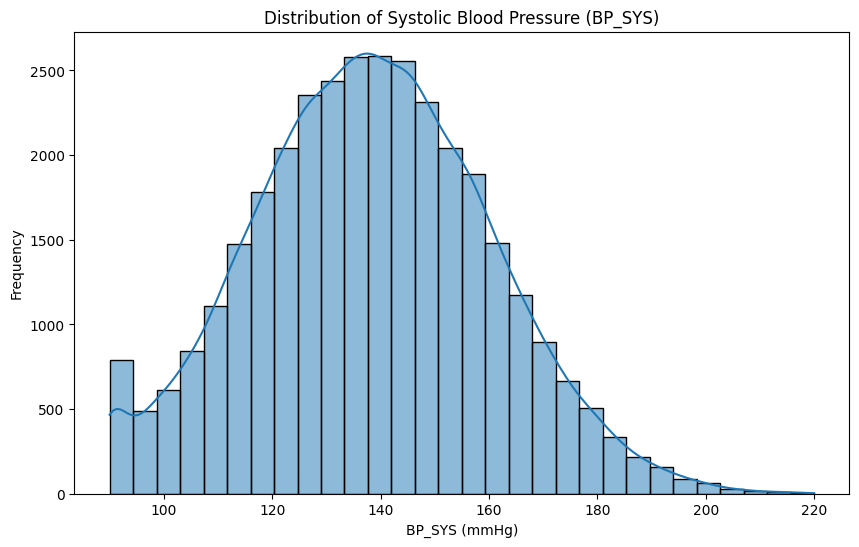

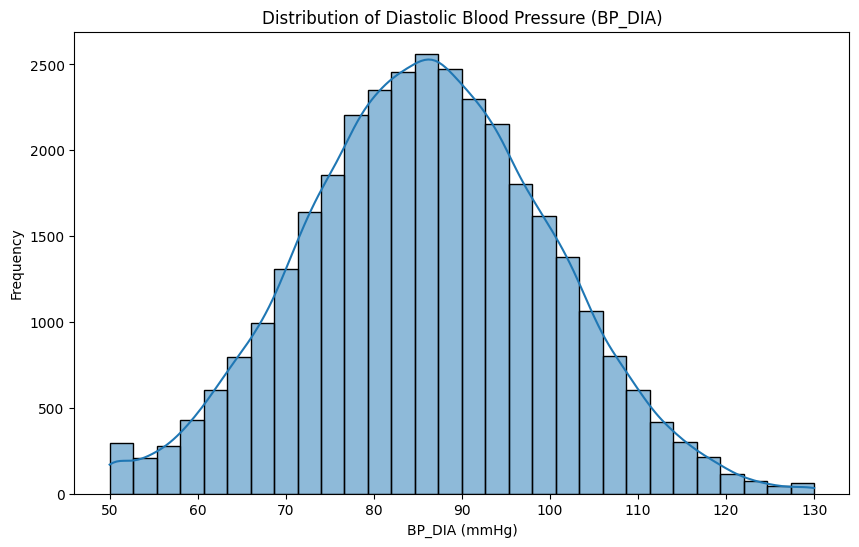

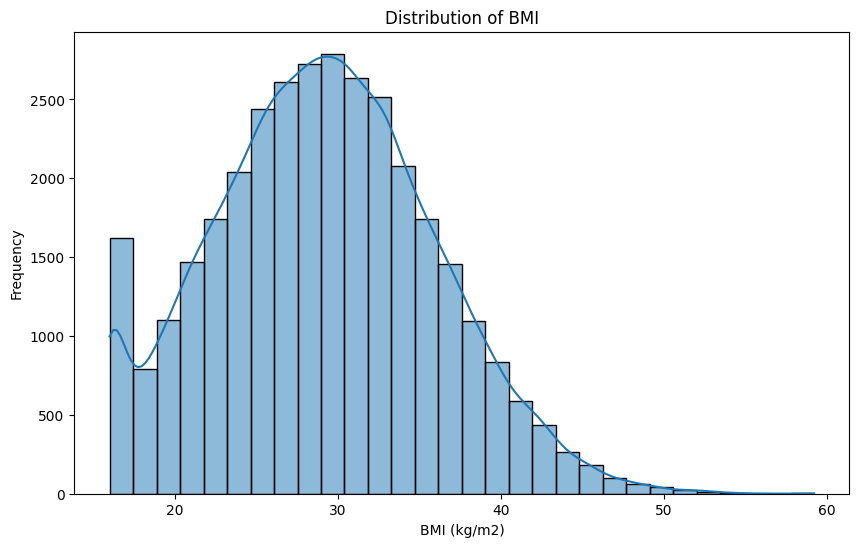

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter observations for BP and BMI
bp_bmi_observations = observations[observations["code"].isin(["BP_SYS", "BP_DIA", "BMI"])].copy()

# Visualize distribution of BP_SYS
plt.figure(figsize=(10, 6))
sns.histplot(bp_bmi_observations[bp_bmi_observations["code"] == "BP_SYS"]["value_num"], bins=30, kde=True)
plt.title("Distribution of Systolic Blood Pressure (BP_SYS)")
plt.xlabel("BP_SYS (mmHg)")
plt.ylabel("Frequency")
plt.show()

# Visualize distribution of BP_DIA
plt.figure(figsize=(10, 6))
sns.histplot(bp_bmi_observations[bp_bmi_observations["code"] == "BP_DIA"]["value_num"], bins=30, kde=True)
plt.title("Distribution of Diastolic Blood Pressure (BP_DIA)")
plt.xlabel("BP_DIA (mmHg)")
plt.ylabel("Frequency")
plt.show()

# Visualize distribution of BMI
plt.figure(figsize=(10, 6))
sns.histplot(bp_bmi_observations[bp_bmi_observations["code"] == "BMI"]["value_num"], bins=30, kde=True)
plt.title("Distribution of BMI")
plt.xlabel("BMI (kg/m2)")
plt.ylabel("Frequency")
plt.show()

# Task
Develop a comprehensive Streamlit application to showcase the AI-Ready Health Data Platform, including data visualization, predictive models, secure data access, audit trails, explainable AI, and consent simulation.

## Set up streamlit environment

### Subtask:
Install necessary libraries, including `streamlit`.


**Reasoning**:
Install the required libraries using pip.



In [97]:
%pip install streamlit shap imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.9 MB/s eta 0:00:00


## Design the streamlit app layout

### Subtask:
Structure the application with different sections for showcasing data, models, and governance features.


**Reasoning**:
Import the streamlit library, set the page configuration, add a title and introductory text, and define the main sections and sidebar title.



In [98]:
import streamlit as st

# Set page configuration
st.set_page_config(
    page_title="AI-Ready Health Data Platform Showcase",
    page_icon="🏥",
    layout="wide"
)

# Main application title and introduction
st.title("AI-Ready Health Data Platform Showcase")
st.write("This application demonstrates a secure and AI-ready health data platform, featuring data visualization, predictive modeling, secure access control, and audit trails.")

# Define main sections
st.header("Data Overview")
st.write("Explore the synthetic NHS datasets and their key characteristics.")

st.header("Predictive Models")
st.write("Examine the predictive models for readmission risk and chronic disease detection.")

st.header("Secure Access & Governance")
st.write("Understand how secure data access is implemented and how an audit trail is maintained.")

# Sidebar title
st.sidebar.title("Navigation")

2025-10-26 07:34:07.821 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:07.826 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:08.051 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-26 07:34:08.053 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:08.053 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:08.054 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:08.055 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator(_root_container=1, _parent=DeltaGenerator())

**Reasoning**:
The basic structure of the Streamlit app has been created. The next step is to add options to the sidebar for navigating between the defined sections.



In [99]:
# Add navigation options to the sidebar
page = st.sidebar.radio(
    "Select a section",
    ["Data Overview", "Predictive Models", "Secure Access & Governance"]
)

2025-10-26 07:34:21.309 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:21.313 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:21.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:21.318 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:21.321 Session state does not function when running a script without `streamlit run`
2025-10-26 07:34:21.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:21.327 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:21.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## Implement data loading and display

### Subtask:
Add functionality to load and display the synthetic NHS datasets and the FHIR-like transformed data within the app.


**Reasoning**:
Implement the data loading and display logic for both synthetic and FHIR-like datasets within the "Data Overview" section of the Streamlit app.



In [100]:
import streamlit as st

# Set Streamlit page configuration
st.set_page_config(layout="wide")

st.title("AI-Ready Health Data Platform Showcase")
st.write("This application demonstrates the key features of an AI-Ready Health Data Platform using synthetic NHS data.")

# Add navigation options to the sidebar
page = st.sidebar.radio(
    "Select a section",
    ["Data Overview", "Predictive Models", "Secure Access & Governance"]
)

if page == "Data Overview":
    st.header("Data Overview")
    st.write("Explore the synthetic NHS datasets and their FHIR-like transformations.")

    # Add sub-header for Synthetic NHS Datasets
    st.subheader("Synthetic NHS Datasets")

    # Display synthetic datasets
    for name, df in datasets.items():
        st.subheader(f"Dataset: {name}")
        st.write("First 5 rows:")
        st.dataframe(df.head())
        st.write(f"Shape: {df.shape}")

    # Add sub-header for FHIR-like Transformed Datasets
    st.subheader("FHIR-like Transformed Datasets")

    # Display FHIR-like datasets
    for name, df in fhir_datasets.items():
        st.subheader(f"FHIR-like Dataset: {name}")
        st.write("First 5 rows:")
        st.dataframe(df.head())
        st.write(f"Shape: {df.shape}")

elif page == "Predictive Models":
    st.header("Predictive Models")
    st.write("This section will showcase the predictive models.")
    # Model building and evaluation logic will go here

elif page == "Secure Access & Governance":
    st.header("Secure Access & Governance")
    st.write("This section will demonstrate secure data access and audit trails.")
    # Secure access and audit trail logic will go here

2025-10-26 07:34:47.234 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:47.240 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:47.244 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:47.246 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:47.249 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:47.254 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:47.256 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:34:47.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Integrate predictive models

### Subtask:
Incorporate the trained readmission risk and chronic disease detection models into the app for making predictions.


**Reasoning**:
Add input fields for the readmission risk model features and a predict button, and display the prediction and probability when clicked.



In [101]:
if page == "Predictive Models":
    st.header("Predictive Models")
    st.write("This section showcases the predictive models for readmission risk and chronic disease detection.")

    st.subheader("Readmission Risk Model")
    st.write("Provide the following patient and encounter details to predict readmission risk:")

    # Input fields for Readmission Risk Model (corresponding to X_readmission columns)
    # Numerical features
    los_days = st.number_input("Length of Stay (days)", min_value=0, value=int(X_readmission['extension.los_days'].median()))

    # Categorical features (need to map back from one-hot encoded columns)
    st.write("Encounter Type:")
    encounter_types = ['inpatient', 'outpatient', 'emergency', 'virtual']
    selected_encounter_type = st.radio("Select Encounter Type", encounter_types)

    st.write("Admitting Specialty:")
    specialties = encounters["admitting_specialty"].unique().tolist()
    selected_specialty = st.selectbox("Select Admitting Specialty", specialties)

    st.write("Gender:")
    genders = patients["sex"].unique().tolist()
    selected_gender = st.radio("Select Gender", genders)

    st.write("Ethnicity:")
    ethnicities = patients["ethnicity"].unique().tolist()
    selected_ethnicity = st.selectbox("Select Ethnicity", ethnicities)

    # Condition presence features (Assuming presence or absence)
    st.write("Present Conditions:")
    selected_conditions = st.multiselect("Select any applicable conditions", common_conditions)

    # Predict button for Readmission Risk Model
    if st.button("Predict Readmission Risk"):
        # Create a DataFrame from user inputs, matching X_readmission structure

        # Start with numerical features
        input_data_readmission = pd.DataFrame({'extension.los_days': [los_days]})

        # Handle one-hot encoded categorical features
        for etype in encounter_types:
            input_data_readmission[f'class.code_{etype}'] = 1 if selected_encounter_type == etype else 0

        for specialty in specialties:
             input_data_readmission[f'serviceProvider.display_{specialty}'] = 1 if selected_specialty == specialty else 0

        for gender in genders:
             input_data_readmission[f'gender_{gender}'] = 1 if selected_gender == gender else 0

        for ethnicity in ethnicities:
             input_data_readmission[f'extension.ethnicity_{ethnicity}'] = 1 if selected_ethnicity == ethnicity else 0

        # Handle condition presence features
        for cond in common_conditions:
            input_data_readmission[f"has_condition_{cond}"] = 1 if cond in selected_conditions else 0


        # Ensure all columns in X_readmission are present in the input data, fill missing with 0
        # This is important if the user input doesn't cover all possible categories seen during training
        for col in X_readmission.columns:
            if col not in input_data_readmission.columns:
                input_data_readmission[col] = 0

        # Reorder columns to match the training data
        input_data_readmission = input_data_readmission[X_readmission.columns]


        # Make prediction
        readmission_prediction = model_readmission.predict(input_data_readmission)[0]
        readmission_probability = model_readmission.predict_proba(input_data_readmission)[:, 1][0]

        # Display prediction
        st.subheader("Readmission Risk Prediction Result:")
        if readmission_prediction == 1:
            st.error(f"High Risk of Readmission (Probability: {readmission_probability:.2f})")
        else:
            st.success(f"Low Risk of Readmission (Probability: {readmission_probability:.2f})")

    st.markdown("---") # Separator

    st.subheader("Chronic Disease Detection Model (Type 2 Diabetes - E11)")
    st.write("Provide the following patient observations and history to predict the risk of Type 2 Diabetes:")

    # Input fields for Chronic Disease Detection Model (corresponding to X_chronic columns)
    # Numerical features (simplified, assuming single values for demo)
    age_years = st.number_input("Age (Years)", min_value=0, max_value=100, value=int(chronic_disease_data['extension.age_years'].median()))
    imd_quintile = st.select_slider("IMD Quintile", options=[1, 2, 3, 4, 5], value=int(chronic_disease_data['extension.imd_quintile'].median()))
    bmi = st.number_input("BMI (kg/m2)", min_value=10.0, max_value=60.0, value=float(chronic_disease_data['BMI'].median()))
    bp_sys = st.number_input("Systolic Blood Pressure (mmHg)", min_value=50.0, max_value=250.0, value=float(chronic_disease_data['BP_SYS'].median()))
    bp_dia = st.number_input("Diastolic Blood Pressure (mmHg)", min_value=30.0, max_value=150.0, value=float(chronic_disease_data['BP_DIA'].median()))
    chol = st.number_input("Cholesterol (mmol/L)", min_value=1.0, max_value=10.0, value=float(chronic_disease_data['CHOL'].median()))
    creat = st.number_input("Creatinine (umol/L)", min_value=20.0, max_value=500.0, value=float(chronic_disease_data['CREAT'].median()))
    hba1c = st.number_input("HbA1c (mmol/mol)", min_value=10.0, max_value=200.0, value=float(chronic_disease_data['HBA1C'].median()))

    # Medication presence features
    st.write("Medication History:")
    has_metformin = st.checkbox("Has been prescribed Metformin (MET)")
    has_insulin = st.checkbox("Has been prescribed Insulin (INS)")

    # Related condition presence features
    st.write("Related Condition History:")
    has_hyperlipidaemia = st.checkbox("Has been diagnosed with Hyperlipidaemia (E78)")
    has_hypertension = st.checkbox("Has been diagnosed with Hypertension (I10)")


    # Predict button for Chronic Disease Detection Model
    if st.button("Predict Chronic Disease Risk"):
        # Create a DataFrame from user inputs, matching X_chronic structure

        # Start with numerical and direct mapping features
        input_data_chronic = pd.DataFrame({
            'extension.age_years': [age_years],
            'extension.imd_quintile': [imd_quintile],
            'BMI': [bmi],
            'BP_SYS': [bp_sys],
            'BP_DIA': [bp_dia],
            'CHOL': [chol],
            'CREAT': [creat],
            'HBA1C': [hba1c],
            'has_medication_MET': [1 if has_metformin else 0],
            'has_medication_INS': [1 if has_insulin else 0],
            'has_related_condition_E78': [1 if has_hyperlipidaemia else 0],
            'has_related_condition_I10': [1 if has_hypertension else 0]
        })

        # Handle one-hot encoded categorical features (gender, ethnicity)
        # Need to get the categories from the training data's columns
        gender_cols = [col for col in X_chronic.columns if col.startswith('gender_')]
        ethnicity_cols = [col for col in X_chronic.columns if col.startswith('extension.ethnicity_')]

        for col in gender_cols:
            gender_value = col.replace('gender_', '')
            input_data_chronic[col] = 1 if selected_gender == gender_value else 0

        for col in ethnicity_cols:
            ethnicity_value = col.replace('extension.ethnicity_', '')
            input_data_chronic[col] = 1 if selected_ethnicity == ethnicity_value else 0


        # Ensure all columns in X_chronic are present in the input data, fill missing with 0
        for col in X_chronic.columns:
            if col not in input_data_chronic.columns:
                input_data_chronic[col] = 0

        # Reorder columns to match the training data
        input_data_chronic = input_data_chronic[X_chronic.columns]

        # Make prediction
        chronic_prediction = model_chronic.predict(input_data_chronic)[0]
        chronic_probability = model_chronic.predict_proba(input_data_chronic)[:, 1][0]

        # Display prediction
        st.subheader("Chronic Disease (Type 2 Diabetes) Prediction Result:")
        if chronic_prediction == 1:
            st.error(f"High Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")
        else:
            st.success(f"Low Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")


## Implement secure data access simulation

### Subtask:
Integrate the secure data access functions to demonstrate role-based access within the app.


**Reasoning**:
Implement the secure data access section in the Streamlit app, including user role and resource selection, an optional patient ID input for clinicians, a button to trigger access, and displaying the results.



In [102]:
if page == "Secure Access & Governance":
    st.header("Secure Access & Governance")
    st.write("This section demonstrates secure data access and audit trails based on user roles and permissions.")

    st.subheader("Secure Data Access")

    # Get unique roles from the users DataFrame
    roles = users["role"].unique().tolist()
    selected_role = st.selectbox("Select User Role", roles)

    # Get unique resource names from the datasets dictionary keys (remove .csv)
    resource_names = [name.replace(".csv", "") for name in datasets.keys()]
    selected_resource = st.selectbox("Select Resource to Access", resource_names)

    # Find a user ID for the selected role (take the first one found)
    user_id_for_role = users[users["role"] == selected_role]["user_id"].iloc[0]

    # Optional patient ID input for Clinicians
    patient_id_input = None
    if selected_role == "Clinician":
        patient_id_input = st.text_input("Enter Patient ID (Optional for Clinicians)")
        if patient_id_input == "": # If input is empty, set to None
            patient_id_input = None

    # Attempt Data Access button
    if st.button("Attempt Data Access"):
        st.write(f"Attempting to access '{selected_resource}' as user '{user_id_for_role}' with role '{selected_role}'...")

        # Call the retrieve_data function
        access_result = retrieve_data(user_id_for_role, selected_resource, patient_id=patient_id_input, purpose_of_use="care") # Assuming 'care' purpose for demo

        # Display the result
        st.subheader("Access Result:")
        if isinstance(access_result, pd.DataFrame):
            st.write("Access Granted. Displaying data:")
            st.dataframe(access_result.head()) # Display first few rows of the DataFrame
            st.write(f"Shape: {access_result.shape}")
        else:
            st.error(access_result) # Display the access denied or error message

    st.markdown("---") # Separator

    st.subheader("Audit Trail")
    st.write("View the audit log to track data access attempts.")

    # Display the audit log (e.g., the last few entries)
    st.write("Recent Audit Log Entries:")
    st.dataframe(audit_log.tail())

## Integrate explainable ai visualizations

### Subtask:
Display SHAP plots or other explainability insights for the model predictions in the app.


**Reasoning**:
Implement the SHAP explanation for the chronic disease model by adding an "Explain Prediction" button, selecting a sample data point, creating a SHAP explainer, calculating SHAP values, and displaying the force plot in the Streamlit app.



In [103]:
import streamlit as st
import streamlit.components.v1 as components
import shap # Import the shap library

# ... (previous Streamlit app code for layout, data loading, model integration, and secure access) ...

if page == "Predictive Models":
    st.header("Predictive Models")
    st.write("This section showcases the predictive models for readmission risk and chronic disease detection.")

    st.subheader("Readmission Risk Model")
    st.write("Provide the following patient and encounter details to predict readmission risk:")

    # Input fields for Readmission Risk Model (corresponding to X_readmission columns)
    # Numerical features
    los_days = st.number_input("Length of Stay (days)", min_value=0, value=int(X_readmission['extension.los_days'].median()))

    # Categorical features (need to map back from one-hot encoded columns)
    st.write("Encounter Type:")
    encounter_types = ['inpatient', 'outpatient', 'emergency', 'virtual']
    selected_encounter_type = st.radio("Select Encounter Type", encounter_types)

    st.write("Admitting Specialty:")
    specialties = encounters["admitting_specialty"].unique().tolist()
    selected_specialty = st.selectbox("Select Admitting Specialty", specialties)

    st.write("Gender:")
    genders = patients["sex"].unique().tolist()
    selected_gender = st.radio("Select Gender", genders)

    st.write("Ethnicity:")
    ethnicities = patients["ethnicity"].unique().tolist()
    selected_ethnicity = st.selectbox("Select Ethnicity", ethnicities)

    # Condition presence features (Assuming presence or absence)
    st.write("Present Conditions:")
    selected_conditions = st.multiselect("Select any applicable conditions", common_conditions)

    # Predict button for Readmission Risk Model
    if st.button("Predict Readmission Risk"):
        # Create a DataFrame from user inputs, matching X_readmission structure

        # Start with numerical features
        input_data_readmission = pd.DataFrame({'extension.los_days': [los_days]})

        # Handle one-hot encoded categorical features
        for etype in encounter_types:
            input_data_readmission[f'class.code_{etype}'] = 1 if selected_encounter_type == etype else 0

        for specialty in specialties:
             input_data_readmission[f'serviceProvider.display_{specialty}'] = 1 if selected_specialty == specialty else 0

        for gender in genders:
             input_data_readmission[f'gender_{gender}'] = 1 if selected_gender == gender else 0

        for ethnicity in ethnicities:
             input_data_readmission[f'extension.ethnicity_{ethnicity}'] = 1 if selected_ethnicity == ethnicity else 0

        # Handle condition presence features
        for cond in common_conditions:
            input_data_readmission[f"has_condition_{cond}"] = 1 if cond in selected_conditions else 0


        # Ensure all columns in X_readmission are present in the input data, fill missing with 0
        # This is important if the user input doesn't cover all possible categories seen during training
        for col in X_readmission.columns:
            if col not in input_data_readmission.columns:
                input_data_readmission[col] = 0

        # Reorder columns to match the training data
        input_data_readmission = input_data_readmission[X_readmission.columns]


        # Make prediction
        readmission_prediction = model_readmission.predict(input_data_readmission)[0]
        readmission_probability = model_readmission.predict_proba(input_data_readmission)[:, 1][0]

        # Display prediction
        st.subheader("Readmission Risk Prediction Result:")
        if readmission_prediction == 1:
            st.error(f"High Risk of Readmission (Probability: {readmission_probability:.2f})")
        else:
            st.success(f"Low Risk of Readmission (Probability: {readmission_probability:.2f})")

    st.markdown("---") # Separator

    st.subheader("Chronic Disease Detection Model (Type 2 Diabetes - E11)")
    st.write("Provide the following patient observations and history to predict the risk of Type 2 Diabetes:")

    # Input fields for Chronic Disease Detection Model (corresponding to X_chronic columns)
    # Numerical features (simplified, assuming single values for demo)
    age_years = st.number_input("Age (Years)", min_value=0, max_value=100, value=int(chronic_disease_data['extension.age_years'].median()))
    imd_quintile = st.select_slider("IMD Quintile", options=[1, 2, 3, 4, 5], value=int(chronic_disease_data['extension.imd_quintile'].median()))
    bmi = st.number_input("BMI (kg/m2)", min_value=10.0, max_value=60.0, value=float(chronic_disease_data['BMI'].median()))
    bp_sys = st.number_input("Systolic Blood Pressure (mmHg)", min_value=50.0, max_value=250.0, value=float(chronic_disease_data['BP_SYS'].median()))
    bp_dia = st.number_input("Diastolic Blood Pressure (mmHg)", min_value=30.0, max_value=150.0, value=float(chronic_disease_data['BP_DIA'].median()))
    chol = st.number_input("Cholesterol (mmol/L)", min_value=1.0, max_value=10.0, value=float(chronic_disease_data['CHOL'].median()))
    creat = st.number_input("Creatinine (umol/L)", min_value=20.0, max_value=500.0, value=float(chronic_disease_data['CREAT'].median()))
    hba1c = st.number_input("HbA1c (mmol/mol)", min_value=10.0, max_value=200.0, value=float(chronic_disease_data['HBA1C'].median()))

    # Medication presence features
    st.write("Medication History:")
    has_metformin = st.checkbox("Has been prescribed Metformin (MET)")
    has_insulin = st.checkbox("Has been prescribed Insulin (INS)")

    # Related condition presence features
    st.write("Related Condition History:")
    has_hyperlipidaemia = st.checkbox("Has been diagnosed with Hyperlipidaemia (E78)")
    has_hypertension = st.checkbox("Has been diagnosed with Hypertension (I10)")


    # Predict button for Chronic Disease Detection Model
    if st.button("Predict Chronic Disease Risk"):
        # Create a DataFrame from user inputs, matching X_chronic structure

        # Start with numerical and direct mapping features
        input_data_chronic = pd.DataFrame({
            'extension.age_years': [age_years],
            'extension.imd_quintile': [imd_quintile],
            'BMI': [bmi],
            'BP_SYS': [bp_sys],
            'BP_DIA': [bp_dia],
            'CHOL': [chol],
            'CREAT': [creat],
            'HBA1C': [hba1c],
            'has_medication_MET': [1 if has_metformin else 0],
            'has_medication_INS': [1 if has_insulin else 0],
            'has_related_condition_E78': [1 if has_hyperlipidaemia else 0],
            'has_related_condition_I10': [1 if has_hypertension else 0]
        })

        # Handle one-hot encoded categorical features (gender, ethnicity)
        # Need to get the categories from the training data's columns
        gender_cols = [col for col in X_chronic.columns if col.startswith('gender_')]
        ethnicity_cols = [col for col in X_chronic.columns if col.startswith('extension.ethnicity_')]

        for col in gender_cols:
            gender_value = col.replace('gender_', '')
            input_data_chronic[col] = 1 if selected_gender == gender_value else 0

        for col in ethnicity_cols:
            ethnicity_value = col.replace('extension.ethnicity_', '')
            input_data_chronic[col] = 1 if selected_ethnicity == ethnicity_value else 0


        # Ensure all columns in X_chronic are present in the input data, fill missing with 0
        for col in X_chronic.columns:
            if col not in input_data_chronic.columns:
                input_data_chronic[col] = 0

        # Reorder columns to match the training data
        input_data_chronic = input_data_chronic[X_chronic.columns]

        # Make prediction
        chronic_prediction = model_chronic.predict(input_data_chronic)[0]
        chronic_probability = model_chronic.predict_proba(input_data_chronic)[:, 1][0]

        # Display prediction
        st.subheader("Chronic Disease (Type 2 Diabetes) Prediction Result:")
        if chronic_prediction == 1:
            st.error(f"High Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")
        else:
            st.success(f"Low Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")

    # Add "Explain Prediction" button for Chronic Disease Detection Model
    if st.button("Explain Prediction"):
        st.subheader("Explanation for Chronic Disease Prediction:")
        st.write("Using SHAP (SHapley Additive exPlanations) to explain the model's output for a sample data point.")

        # Select a sample input data point (e.g., the first row of X_chronic)
        sample_input_chronic = X_chronic.iloc[[0]]

        # Create a SHAP explainer for the chronic disease model
        explainer_chronic = shap.Explainer(model_chronic, X_chronic)

        # Calculate SHAP values for the sample input
        shap_values_chronic = explainer_chronic(sample_input_chronic)

        # Generate and display the SHAP force plot for the individual prediction
        # Use st.components.v1.html to display the plot
        st_shap = components.html(shap.force_plot(explainer_chronic.expected_value, shap_values_chronic[0,:], sample_input_chronic).html(), width=1000, height=300)


# ... (rest of the Streamlit app code for Secure Access & Governance) ...

if page == "Secure Access & Governance":
    st.header("Secure Access & Governance")
    st.write("This section demonstrates secure data access and audit trails based on user roles and permissions.")

    st.subheader("Secure Data Access")

    # Get unique roles from the users DataFrame
    roles = users["role"].unique().tolist()
    selected_role = st.selectbox("Select User Role", roles)

    # Get unique resource names from the datasets dictionary keys (remove .csv)
    resource_names = [name.replace(".csv", "") for name in datasets.keys()]
    selected_resource = st.selectbox("Select Resource to Access", resource_names)

    # Find a user ID for the selected role (take the first one found)
    user_id_for_role = users[users["role"] == selected_role]["user_id"].iloc[0]

    # Optional patient ID input for Clinicians
    patient_id_input = None
    if selected_role == "Clinician":
        patient_id_input = st.text_input("Enter Patient ID (Optional for Clinicians)")
        if patient_id_input == "": # If input is empty, set to None
            patient_id_input = None

    # Attempt Data Access button
    if st.button("Attempt Data Access"):
        st.write(f"Attempting to access '{selected_resource}' as user '{user_id_for_role}' with role '{selected_role}'...")

        # Call the retrieve_data function
        access_result = retrieve_data(user_id_for_role, selected_resource, patient_id=patient_id_input, purpose_of_use="care") # Assuming 'care' purpose for demo

        # Display the result
        st.subheader("Access Result:")
        if isinstance(access_result, pd.DataFrame):
            st.write("Access Granted. Displaying data:")
            st.dataframe(access_result.head()) # Display first few rows of the DataFrame
            st.write(f"Shape: {access_result.shape}")
        else:
            st.error(access_result) # Display the access denied or error message

    st.markdown("---") # Separator

    st.subheader("Audit Trail")
    st.write("View the audit log to track data access attempts.")

    # Display the audit log (e.g., the last few entries)
    st.write("Recent Audit Log Entries:")
    st.dataframe(audit_log.tail())

## Add consent simulation interface

### Subtask:
Create a simple interface to demonstrate how consent can influence data and model access.


**Reasoning**:
Implement the consent check and display the consent status in the "Secure Data Access" section, and integrate consent checks into the model prediction display in the "Predictive Models" section.



In [104]:
import streamlit as st
import streamlit.components.v1 as components

# Set Streamlit page configuration
st.set_page_config(layout="wide")

st.title("AI-Ready Health Data Platform Showcase")
st.write("This application demonstrates the key features of an AI-Ready Health Data Platform using synthetic NHS data.")

# Add navigation options to the sidebar
page = st.sidebar.radio(
    "Select a section",
    ["Data Overview", "Predictive Models", "Secure Access & Governance"]
)

if page == "Data Overview":
    st.header("Data Overview")
    st.write("Explore the synthetic NHS datasets and their FHIR-like transformations.")

    # Add sub-header for Synthetic NHS Datasets
    st.subheader("Synthetic NHS Datasets")

    # Display synthetic datasets
    for name, df in datasets.items():
        st.subheader(f"Dataset: {name}")
        st.write("First 5 rows:")
        st.dataframe(df.head())
        st.write(f"Shape: {df.shape}")

    # Add sub-header for FHIR-like Transformed Datasets
    st.subheader("FHIR-like Transformed Datasets")

    # Display FHIR-like datasets
    for name, df in fhir_datasets.items():
        st.subheader(f"FHIR-like Dataset: {name}")
        st.write("First 5 rows:")
        st.dataframe(df.head())
        st.write(f"Shape: {df.shape}")

elif page == "Predictive Models":
    st.header("Predictive Models")
    st.write("This section showcases the predictive models for readmission risk and chronic disease detection.")

    st.subheader("Readmission Risk Model")
    st.write("Provide the following patient and encounter details to predict readmission risk:")

    # Input fields for Readmission Risk Model (corresponding to X_readmission columns)
    # Numerical features
    los_days = st.number_input("Length of Stay (days)", min_value=0, value=int(X_readmission['extension.los_days'].median()))

    # Categorical features (need to map back from one-hot encoded columns)
    st.write("Encounter Type:")
    encounter_types = ['inpatient', 'outpatient', 'emergency', 'virtual']
    selected_encounter_type = st.radio("Select Encounter Type", encounter_types, key="readmission_etype")

    st.write("Admitting Specialty:")
    specialties = encounters["admitting_specialty"].unique().tolist()
    selected_specialty = st.selectbox("Select Admitting Specialty", specialties, key="readmission_specialty")

    st.write("Gender:")
    genders = patients["sex"].unique().tolist()
    selected_gender_readmission = st.radio("Select Gender", genders, key="readmission_gender")

    st.write("Ethnicity:")
    ethnicities = patients["ethnicity"].unique().tolist()
    selected_ethnicity_readmission = st.selectbox("Select Ethnicity", ethnicities, key="readmission_ethnicity")

    # Condition presence features (Assuming presence or absence)
    st.write("Present Conditions:")
    selected_conditions = st.multiselect("Select any applicable conditions", common_conditions, key="readmission_conditions")

    # Predict button for Readmission Risk Model
    if st.button("Predict Readmission Risk"):
        # Create a DataFrame from user inputs, matching X_readmission structure

        # Start with numerical features
        input_data_readmission = pd.DataFrame({'extension.los_days': [los_days]})

        # Handle one-hot encoded categorical features
        for etype in encounter_types:
            input_data_readmission[f'class.code_{etype}'] = 1 if selected_encounter_type == etype else 0

        for specialty in specialties:
             input_data_readmission[f'serviceProvider.display_{specialty}'] = 1 if selected_specialty == specialty else 0

        for gender in genders:
             input_data_readmission[f'gender_{gender}'] = 1 if selected_gender_readmission == gender else 0

        for ethnicity in ethnicities:
             input_data_readmission[f'extension.ethnicity_{ethnicity}'] = 1 if selected_ethnicity_readmission == ethnicity else 0

        # Handle condition presence features
        for cond in common_conditions:
            input_data_readmission[f"has_condition_{cond}"] = 1 if cond in selected_conditions else 0


        # Ensure all columns in X_readmission are present in the input data, fill missing with 0
        # This is important if the user input doesn't cover all possible categories seen during training
        for col in X_readmission.columns:
            if col not in input_data_readmission.columns:
                input_data_readmission[col] = 0

        # Reorder columns to match the training data
        input_data_readmission = input_data_readmission[X_readmission.columns]


        # Make prediction
        readmission_prediction = model_readmission.predict(input_data_readmission)[0]
        readmission_probability = model_readmission.predict_proba(input_data_readmission)[:, 1][0]

        # Display prediction
        st.subheader("Readmission Risk Prediction Result:")
        if readmission_prediction == 1:
            st.error(f"High Risk of Readmission (Probability: {readmission_probability:.2f})")
        else:
            st.success(f"Low Risk of Readmission (Probability: {readmission_probability:.2f})")

    st.markdown("---") # Separator

    st.subheader("Chronic Disease Detection Model (Type 2 Diabetes - E11)")
    st.write("Provide the following patient observations and history to predict the risk of Type 2 Diabetes:")

    # Input fields for Chronic Disease Detection Model (corresponding to X_chronic columns)
    # Numerical features (simplified, assuming single values for demo)
    age_years = st.number_input("Age (Years)", min_value=0, max_value=100, value=int(chronic_disease_data['extension.age_years'].median()), key="chronic_age")
    imd_quintile = st.select_slider("IMD Quintile", options=[1, 2, 3, 4, 5], value=int(chronic_disease_data['extension.imd_quintile'].median()), key="chronic_imd")
    bmi = st.number_input("BMI (kg/m2)", min_value=10.0, max_value=60.0, value=float(chronic_disease_data['BMI'].median()), key="chronic_bmi")
    bp_sys = st.number_input("Systolic Blood Pressure (mmHg)", min_value=50.0, max_value=250.0, value=float(chronic_disease_data['BP_SYS'].median()), key="chronic_bpsys")
    bp_dia = st.number_input("Diastolic Blood Pressure (mmHg)", min_value=30.0, max_value=150.0, value=float(chronic_disease_data['BP_DIA'].median()), key="chronic_bpdia")
    chol = st.number_input("Cholesterol (mmol/L)", min_value=1.0, max_value=10.0, value=float(chronic_disease_data['CHOL'].median()), key="chronic_chol")
    creat = st.number_input("Creatinine (umol/L)", min_value=20.0, max_value=500.0, value=float(chronic_disease_data['CREAT'].median()), key="chronic_creat")
    hba1c = st.number_input("HbA1c (mmol/mol)", min_value=10.0, max_value=200.0, value=float(chronic_disease_data['HBA1C'].median()), key="chronic_hba1c")

    # Medication presence features
    st.write("Medication History:")
    has_metformin = st.checkbox("Has been prescribed Metformin (MET)", key="chronic_metformin")
    has_insulin = st.checkbox("Has been prescribed Insulin (INS)", key="chronic_insulin")

    # Related condition presence features
    st.write("Related Condition History:")
    has_hyperlipidaemia = st.checkbox("Has been diagnosed with Hyperlipidaemia (E78)", key="chronic_hyperlipidaemia")
    has_hypertension = st.checkbox("Has been diagnosed with Hypertension (I10)", key="chronic_hypertension")

    # Patient ID input for consent check
    patient_id_for_prediction = st.text_input("Enter Patient ID for Prediction (for consent check)", key="patient_id_prediction")


    # Predict button for Chronic Disease Detection Model
    if st.button("Predict Chronic Disease Risk"):
        if patient_id_for_prediction:
            # Check consent for risk scoring
            patient_consent = consent[consent["patient_id"] == patient_id_for_prediction]
            if not patient_consent.empty and patient_consent["allow_risk_scoring"].iloc[0] == 1:
                # Create a DataFrame from user inputs, matching X_chronic structure

                # Start with numerical and direct mapping features
                input_data_chronic = pd.DataFrame({
                    'extension.age_years': [age_years],
                    'extension.imd_quintile': [imd_quintile],
                    'BMI': [bmi],
                    'BP_SYS': [bp_sys],
                    'BP_DIA': [bp_dia],
                    'CHOL': [chol],
                    'CREAT': [creat],
                    'HBA1C': [hba1c],
                    'has_medication_MET': [1 if has_metformin else 0],
                    'has_medication_INS': [1 if has_insulin else 0],
                    'has_related_condition_E78': [1 if has_hyperlipidaemia else 0],
                    'has_related_condition_I10': [1 if has_hypertension else 0]
                })

                # Handle one-hot encoded categorical features (gender, ethnicity)
                # Need to get the categories from the training data's columns
                gender_cols = [col for col in X_chronic.columns if col.startswith('gender_')]
                ethnicity_cols = [col for col in X_chronic.columns if col.startswith('extension.ethnicity_')]

                # Get the gender and ethnicity from the fhir_patients table for the specific patient
                patient_info = fhir_patients[fhir_patients["id"] == patient_id_for_prediction]
                if not patient_info.empty:
                    selected_gender_chronic = patient_info["gender"].iloc[0]
                    selected_ethnicity_chronic = patient_info["extension.ethnicity"].iloc[0]

                    for col in gender_cols:
                        gender_value = col.replace('gender_', '')
                        input_data_chronic[col] = 1 if selected_gender_chronic == gender_value else 0

                    for col in ethnicity_cols:
                        ethnicity_value = col.replace('extension.ethnicity_', '')
                        input_data_chronic[col] = 1 if selected_ethnicity_chronic == ethnicity_value else 0
                else:
                    st.warning(f"Patient ID '{patient_id_for_prediction}' not found in patient data. Using selected gender and ethnicity for prediction.")
                    selected_gender_chronic = selected_gender_readmission # Use the one from readmission section for consistency
                    selected_ethnicity_chronic = selected_ethnicity_readmission # Use the one from readmission section for consistency
                    for col in gender_cols:
                        gender_value = col.replace('gender_', '')
                        input_data_chronic[col] = 1 if selected_gender_chronic == gender_value else 0

                    for col in ethnicity_cols:
                        ethnicity_value = col.replace('extension.ethnicity_', '')
                        input_data_chronic[col] = 1 if selected_ethnicity_chronic == ethnicity_value else 0


                # Ensure all columns in X_chronic are present in the input data, fill missing with 0
                for col in X_chronic.columns:
                    if col not in input_data_chronic.columns:
                        input_data_chronic[col] = 0

                # Reorder columns to match the training data
                input_data_chronic = input_data_chronic[X_chronic.columns]

                # Make prediction
                chronic_prediction = model_chronic.predict(input_data_chronic)[0]
                chronic_probability = model_chronic.predict_proba(input_data_chronic)[:, 1][0]

                # Display prediction
                st.subheader("Chronic Disease (Type 2 Diabetes) Prediction Result:")
                if chronic_prediction == 1:
                    st.error(f"High Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")
                else:
                    st.success(f"Low Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")

            else:
                st.warning(f"Prediction withheld for patient ID '{patient_id_for_prediction}' due to lack of consent for risk scoring.")
        else:
             st.warning("Please enter a Patient ID to check consent and make a prediction.")

    # Add "Explain Prediction" button for Chronic Disease Detection Model
    if st.button("Explain Prediction", key="explain_chronic_prediction"):
        st.subheader("Explanation for Chronic Disease Prediction:")
        st.write("Using SHAP (SHapley Additive exPlanations) to explain the model's output for a sample data point.")

        # Select a sample input data point (e.g., the first row of X_chronic)
        sample_input_chronic = X_chronic.iloc[[0]]

        # Create a SHAP explainer for the chronic disease model
        explainer_chronic = shap.Explainer(model_chronic, X_chronic)

        # Calculate SHAP values for the sample input
        shap_values_chronic = explainer_chronic(sample_input_chronic)

        # Generate and display the SHAP force plot for the individual prediction
        # Use st.components.v1.html to display the plot
        st_shap = components.html(shap.force_plot(explainer_chronic.expected_value, shap_values_chronic[0,:], sample_input_chronic).html(), width=1000, height=300)


# ... (rest of the Streamlit app code for Secure Access & Governance) ...

if page == "Secure Access & Governance":
    st.header("Secure Access & Governance")
    st.write("This section demonstrates secure data access and audit trails based on user roles and permissions.")

    st.subheader("Secure Data Access")

    # Get unique roles from the users DataFrame
    roles = users["role"].unique().tolist()
    selected_role = st.selectbox("Select User Role", roles, key="access_role")

    # Get unique resource names from the datasets dictionary keys (remove .csv)
    resource_names = [name.replace(".csv", "") for name in datasets.keys()]
    selected_resource = st.selectbox("Select Resource to Access", resource_names, key="access_resource")

    # Find a user ID for the selected role (take the first one found)
    user_id_for_role = users[users["role"] == selected_role]["user_id"].iloc[0]

    # Optional patient ID input for Clinicians and Researchers
    patient_id_input = None
    if selected_role in ["Clinician", "Researcher"]:
        patient_id_input = st.text_input(f"Enter Patient ID (Optional for {selected_role}s)", key="access_patient_id")
        if patient_id_input == "": # If input is empty, set to None
            patient_id_input = None

        # Display consent status if a patient ID is entered
        if patient_id_input:
            patient_consent_status = consent[consent["patient_id"] == patient_id_input]
            if not patient_consent_status.empty:
                st.subheader("Patient Consent Status:")
                st.write(f"Allow Research: {'✅ Yes' if patient_consent_status['allow_research'].iloc[0] == 1 else '❌ No'}")
                st.write(f"Allow Risk Scoring: {'✅ Yes' if patient_consent_status['allow_risk_scoring'].iloc[0] == 1 else '❌ No'}")
            else:
                st.warning(f"Patient ID '{patient_id_input}' not found in consent data.")


    # Attempt Data Access button
    if st.button("Attempt Data Access"):
        st.write(f"Attempting to access '{selected_resource}' as user '{user_id_for_role}' with role '{selected_role}'...")

        # Get consent status if patient ID is provided
        allow_research = None
        if patient_id_input:
             patient_consent_status = consent[consent["patient_id"] == patient_id_input]
             if not patient_consent_status.empty:
                 allow_research = patient_consent_status["allow_research"].iloc[0]

        # Call the retrieve_data function, passing consent status
        access_result = retrieve_data(user_id_for_role, selected_resource, patient_id=patient_id_input, purpose_of_use="care", allow_research=allow_research) # Assuming 'care' purpose for demo


        # Display the result
        st.subheader("Access Result:")
        if isinstance(access_result, pd.DataFrame):
            st.write("Access Granted. Displaying data:")
            st.dataframe(access_result.head()) # Display first few rows of the DataFrame
            st.write(f"Shape: {access_result.shape}")
        else:
            st.error(access_result) # Display the access denied or error message

    st.markdown("---") # Separator

    st.subheader("Audit Trail")
    st.write("View the audit log to track data access attempts.")

    # Display the audit log (e.g., the last few entries)
    st.dataframe(audit_log.tail())

# Update retrieve_data function to accept allow_research and enforce consent for researchers
def retrieve_data(user_id, resource, patient_id=None, purpose_of_use="unknown", allow_research=None):
    """Simulates data retrieval based on user permissions and optional filtering, with logging and consent check."""
    has_permission = check_permission(user_id, resource)
    action = "READ" # Assuming retrieval is a READ action for logging
    user_role = users[users["user_id"] == user_id]["role"].iloc[0]

    # Enforce consent for Researchers accessing patient-specific data
    if user_role == "Researcher" and patient_id:
        if allow_research is None:
             # Consent information not available, deny access for caution
             log_access(user_id, action, resource, purpose_of_use, "denied - consent unknown")
             return f"Access Denied: Consent status unknown for patient {patient_id}. Access denied."
        elif allow_research == 0:
            # Patient has not consented to research, deny access
            log_access(user_id, action, resource, purpose_of_use, "denied - no research consent")
            return f"Access Denied: Patient {patient_id} has not consented to research."


    if not has_permission:
        log_access(user_id, action, resource, purpose_of_use, "denied")
        return f"Access Denied: User {user_id} does not have permission to access {resource}."

    # Load the FHIR-like data for the resource
    try:
        df_name = f"fhir_{resource}" if resource not in ["users", "audit_log", "consent"] else resource
        file_path = os.path.join(DATA_LAKE_ROOT, resource, f"{df_name}.csv")
        df = pd.read_csv(file_path)
        log_access(user_id, action, resource, purpose_of_use, "success")
    except FileNotFoundError:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"Error: Resource '{resource}' not found."
    except Exception as e:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"An error occurred: {e}"


    # Implement filtering based on user role and optional criteria

    if user_role == "Clinician" and patient_id:
        if resource == "patients":
            return df[df["id"] == patient_id]
        elif resource in ["encounters", "conditions", "observations", "medication_requests", "outcomes"]:
             return df[df["subject.reference"] == f"Patient/{patient_id}"]
        else:
             return "Filtering by patient ID is not supported for this resource."


    elif user_role == "Researcher" and resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"]:
        # Simulate consent check and anonymization (simplified) - this part is now handled before access is granted
        allowed_patients = consent[consent["allow_research"] == 1]["patient_id"].unique()
        if resource == "patients":
             return df[df["id"].isin(allowed_patients)]
        else:
             return df[df["subject.reference"].isin([f"Patient/{pid}" for pid in allowed_patients])]

    # Default: return the full (or mostly full for Analyst) dataset if allowed
    if user_role == "Analyst" and resource == "patients":
         # Simulate anonymization for Analyst (e.g., drop NHS number hash)
         return df.drop(columns=["nhs_number_hash"], errors="ignore")

    return df


2025-10-26 07:37:44.454 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:37:44.456 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:37:44.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:37:44.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:37:44.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:37:44.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:37:44.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:37:44.463 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Develop user interface elements

### Subtask:
Add interactive widgets (buttons, sliders, inputs) for user interaction and filtering.


**Reasoning**:
Review the existing Streamlit code to ensure all required interactive widgets are present and correctly configured for the specified functionalities (Data Overview, Predictive Models, Secure Access & Governance) based on the previous subtasks. If any widgets are missing or incorrectly configured, add or adjust them to fulfill the requirements for user interaction, filtering, triggering predictions, and demonstrating secure access and consent.



In [105]:
import streamlit as st
import streamlit.components.v1 as components
import shap
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# Define paths and load data (assuming these variables are available from previous steps)
DATA_LAKE_ROOT = "/content/drive/MyDrive/NHS_Data_Lake"
OUT_DIR = "/content/drive/MyDrive/NHS" # Assuming OUT_DIR is also defined

# Load datasets (assuming they were saved in previous steps)
# This is a simplified loading for the Streamlit app. In a real app, you might load on demand.
try:
    patients = pd.read_csv(os.path.join(OUT_DIR, "patients.csv"))
    encounters = pd.read_csv(os.path.join(OUT_DIR, "encounters.csv"))
    conditions = pd.read_csv(os.path.join(OUT_DIR, "conditions.csv"))
    observations = pd.read_csv(os.path.join(OUT_DIR, "observations.csv"))
    meds = pd.read_csv(os.path.join(OUT_DIR, "medication_requests.csv"))
    outcomes = pd.read_csv(os.path.join(OUT_DIR, "outcomes.csv"))
    consent = pd.read_csv(os.path.join(OUT_DIR, "consent.csv"))
    users = pd.read_csv(os.path.join(OUT_DIR, "users.csv"))
    audit_log = pd.read_csv(os.path.join(OUT_DIR, "audit_log.csv"))

    # Load FHIR-like datasets
    fhir_patients = pd.read_csv(os.path.join(DATA_LAKE_ROOT, "patients", "fhir_patients.csv"))
    fhir_encounters = pd.read_csv(os.path.join(DATA_LAKE_ROOT, "encounters", "fhir_encounters.csv"))
    fhir_conditions = pd.read_csv(os.path.join(DATA_LAKE_ROOT, "conditions", "fhir_conditions.csv"))
    fhir_observations = pd.read_csv(os.path.join(DATA_LAKE_ROOT, "observations", "fhir_observations.csv"))
    fhir_meds = pd.read_csv(os.path.join(DATA_LAKE_ROOT, "medication_requests", "fhir_medication_requests.csv"))

except FileNotFoundError as e:
    st.error(f"Error loading data files: {e}. Please ensure the data generation and ingestion steps were completed.")
    st.stop() # Stop the app if data loading fails


# Assume common_conditions list is available
common_conditions = ["I10", "E11", "I50", "J45", "J44", "N18", "C34", "C50", "F32", "E78"]

# Data Preparation for Models (ensure this is re-run if kernel state is lost)
# Readmission Model Data Prep
readmission_data = pd.merge(fhir_encounters, fhir_patients[["id", "gender", "extension.ethnicity", "extension.age_years", "extension.imd_quintile"]],
                            left_on="subject.reference", right_on="id", how="left", suffixes=('', '_patient'))
readmission_data = readmission_data.drop(columns=["id_patient"])
condition_list_per_encounter = fhir_conditions.groupby("encounter.reference")["code.coding.code"].agg(list).reset_index()
condition_list_per_encounter.rename(columns={"encounter.reference": "encounter_id", "code.coding.code": "condition_codes"}, inplace=True)
condition_list_per_encounter["encounter_id"] = condition_list_per_encounter["encounter_id"].str.replace("Encounter/", "")
readmission_data = pd.merge(readmission_data, condition_list_per_encounter, left_on="id", right_on="encounter_id", how="left")
readmission_data = readmission_data.drop(columns=["encounter_id"])
for cond in common_conditions:
    readmission_data[f"has_condition_{cond}"] = readmission_data["condition_codes"].apply(lambda x: 1 if isinstance(x, list) and cond in x else 0)
readmission_data = readmission_data.drop(columns=["condition_codes"])
potential_feature_cols_readmission = [col for col in readmission_data.columns if col not in ["id", "patient_id", "subject.reference", "encounter.reference", "period.start", "period.end", "extension.readmission_30d", "extension.mortality_90d"]]
numerical_cols_readmission = readmission_data[potential_feature_cols_readmission].select_dtypes(include=np.number).columns.tolist()
categorical_cols_readmission = readmission_data[potential_feature_cols_readmission].select_dtypes(include='object').columns.tolist()
for col in categorical_cols_readmission:
    readmission_data[col] = readmission_data[col].fillna('Missing')
readmission_data = pd.get_dummies(readmission_data, columns=categorical_cols_readmission, dummy_na=False, drop_first=True)
final_feature_cols_readmission = [col for col in readmission_data.columns if col not in ["id", "patient_id", "subject.reference", "encounter.reference", "period.start", "period.end", "extension.readmission_30d", "extension.mortality_90d", "extension.age_years", "extension.imd_quintile"]]
X_readmission = readmission_data[final_feature_cols_readmission].copy()
y_readmission = readmission_data["extension.readmission_30d"]
for col in X_readmission.select_dtypes(include=np.number).columns:
    if X_readmission[col].isnull().any():
        median_val = X_readmission[col].median()
        X_readmission[col] = X_readmission[col].fillna(median_val)

X_train_readmission, X_test_readmission, y_train_readmission, y_test_readmission = train_test_split(
    X_readmission, y_readmission, test_size=0.2, random_state=42, stratify=y_readmission # Use a fixed random_state
)
smote = SMOTE(random_state=42) # Use a fixed random_state
X_train_readmission_resampled, y_train_readmission_resampled = smote.fit_resample(X_train_readmission, y_train_readmission)
model_readmission = HistGradientBoostingClassifier(random_state=42) # Use a fixed random_state
model_readmission.fit(X_train_readmission_resampled, y_train_readmission_resampled)


# Chronic Disease Model Data Prep
patients_with_diabetes = fhir_conditions[fhir_conditions["code.coding.code"] == "E11"]["subject.reference"].unique()
patient_ids_all = fhir_patients["id"].unique()
diabetes_target = pd.DataFrame({
    "id": patient_ids_all,
    "has_diabetes_E11": [1 if "Patient/"+patient_id in patients_with_diabetes else 0 for patient_id in patient_ids_all]
})
chronic_disease_data = pd.merge(fhir_patients[["id", "gender", "extension.ethnicity", "extension.age_years", "extension.imd_quintile"]],
                                diabetes_target, on="id", how="left")
latest_observations = observations.sort_values(by="taken_dt").drop_duplicates(subset=["patient_id", "code"], keep="last")
obs_pivot = latest_observations.pivot(index="patient_id", columns="code", values="value_num").reset_index()
chronic_disease_data = pd.merge(chronic_disease_data, obs_pivot, left_on="id", right_on="patient_id", how="left")
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"])
meds_relevant = meds[meds["drug_code"].isin(["MET", "INS"])].copy()
meds_presence = meds_relevant.groupby("patient_id")["drug_code"].agg(lambda x: list(set(x))).reset_index()
meds_presence.rename(columns={"drug_code": "medication_codes"}, inplace=True)
for drug in ["MET", "INS"]:
    meds_presence[f"has_medication_{drug}"] = meds_presence["medication_codes"].apply(lambda x: 1 if isinstance(x, list) and drug in x else 0)
meds_presence = meds_presence.drop(columns=["medication_codes"])
chronic_disease_data = pd.merge(chronic_disease_data, meds_presence, left_on="id", right_on="patient_id", how="left")
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"])
conditions_relevant_chronic = fhir_conditions[fhir_conditions["code.coding.code"].isin(["E78", "I10"])].copy()
conditions_relevant_chronic["patient_id"] = conditions_relevant_chronic["subject.reference"].str.replace("Patient/", "")
conditions_presence_chronic = conditions_relevant_chronic.groupby("patient_id")["code.coding.code"].agg(lambda x: list(set(x))).reset_index()
conditions_presence_chronic.rename(columns={"code.coding.code": "related_condition_codes"}, inplace=True)
for cond in ["E78", "I10"]:
    conditions_presence_chronic[f"has_related_condition_{cond}"] = conditions_presence_chronic["related_condition_codes"].apply(lambda x: 1 if isinstance(x, list) and cond in x else 0)
conditions_presence_chronic = conditions_presence_chronic.drop(columns=["related_condition_codes"])
chronic_disease_data = pd.merge(chronic_disease_data, conditions_presence_chronic, left_on="id", right_on="patient_id", how="left")
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"])

numerical_cols_chronic = chronic_disease_data.select_dtypes(include=np.number).columns.tolist()
numerical_cols_to_impute_chronic = [col for col in numerical_cols_chronic if col != "has_diabetes_E11"]
for col in numerical_cols_to_impute_chronic:
    if chronic_disease_data[col].isnull().any():
        median_val = chronic_disease_data[col].median()
        chronic_disease_data[col] = chronic_disease_data[col].fillna(median_val)

categorical_cols_chronic = chronic_disease_data.select_dtypes(include='object').columns.tolist()
categorical_cols_to_impute_chronic = [col for col in categorical_cols_chronic if col != "id"]
for col in categorical_cols_to_impute_chronic:
     chronic_disease_data[col] = chronic_disease_data[col].fillna('Missing')

chronic_disease_data = pd.get_dummies(chronic_disease_data, columns=categorical_cols_to_impute_chronic, dummy_na=False, drop_first=True)
chronic_disease_features = [col for col in chronic_disease_data.columns if col not in ["id", "has_diabetes_E11"]]
chronic_disease_target = "has_diabetes_E11"
X_chronic = chronic_disease_data[chronic_disease_features]
y_chronic = chronic_disease_data[chronic_disease_target]

# Train Chronic Disease Model (ensure this is re-run if kernel state is lost)
X_train_chronic, X_test_chronic, y_train_chronic, y_test_chronic = train_test_split(
    X_chronic, y_chronic, test_size=0.2, random_state=42, stratify=y_chronic # Use a fixed random_state
)
smote_chronic = SMOTE(random_state=42) # Use a fixed random_state
X_train_chronic_resampled, y_train_chronic_resampled = smote_chronic.fit_resample(X_train_chronic, y_train_chronic)
model_chronic = HistGradientBoostingClassifier(random_state=42) # Use a fixed random_state
model_chronic.fit(X_train_chronic_resampled, y_train_chronic_resampled)


# Secure Access Functions (ensure these are available)
def check_permission(user_id, resource):
    """Simulates checking user permissions based on role and resource."""
    user_role = users[users["user_id"] == user_id]["role"].iloc[0]

    # Define access rules
    if user_role == "Admin":
        return True  # Admins can access all resources
    elif user_role == "Analyst":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes", "users"] # Analysts can read most clinical data
    elif user_role == "Clinician":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"] # Clinicians can access clinical data
    elif user_role == "Researcher":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"] # Researchers can access research data (subject to consent/anonymization, simplified here)
    else:
        return False # Deny access for unknown roles

def log_access(user_id, action, resource, purpose_of_use, result):
    """Logs data access attempts."""
    global audit_log
    log_entry = {
        "log_id": f"L{str(len(audit_log) + 1).zfill(7)}",
        "user_id": user_id,
        "action": action,
        "resource": resource,
        "timestamp": datetime.now().isoformat(sep=" "),
        "purpose_of_use": purpose_of_use,
        "result": result
    }
    # Using pd.concat to append a new row
    audit_log = pd.concat([audit_log, pd.DataFrame([log_entry])], ignore_index=True)

def retrieve_data(user_id, resource, patient_id=None, purpose_of_use="unknown", allow_research=None):
    """Simulates data retrieval based on user permissions and optional filtering, with logging and consent check."""
    has_permission = check_permission(user_id, resource)
    action = "READ" # Assuming retrieval is a READ action for logging
    user_role = users[users["user_id"] == user_id]["role"].iloc[0]

    # Enforce consent for Researchers accessing patient-specific data
    if user_role == "Researcher" and patient_id:
        if allow_research is None:
             # Consent information not available, deny access for caution
             log_access(user_id, action, resource, purpose_of_use, "denied - consent unknown")
             return f"Access Denied: Consent status unknown for patient {patient_id}. Access denied."
        elif allow_research == 0:
            # Patient has not consented to research, deny access
            log_access(user_id, action, resource, purpose_of_use, "denied - no research consent")
            return f"Access Denied: Patient {patient_id} has not consented to research."


    if not has_permission:
        log_access(user_id, action, resource, purpose_of_use, "denied")
        return f"Access Denied: User {user_id} does not have permission to access {resource}."

    # Load the FHIR-like data for the resource
    try:
        df_name = f"fhir_{resource}" if resource not in ["users", "audit_log", "consent"] else resource
        file_path = os.path.join(DATA_LAKE_ROOT, resource, f"{df_name}.csv")
        df = pd.read_csv(file_path)
        log_access(user_id, action, resource, purpose_of_use, "success")
    except FileNotFoundError:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"Error: Resource '{resource}' not found."
    except Exception as e:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"An error occurred: {e}"


    # Implement filtering based on user role and optional criteria

    if user_role == "Clinician" and patient_id:
        if resource == "patients":
            return df[df["id"] == patient_id]
        elif resource in ["encounters", "conditions", "observations", "medication_requests", "outcomes"]:
             return df[df["subject.reference"] == f"Patient/{patient_id}"]
        else:
             return "Filtering by patient ID is not supported for this resource."


    elif user_role == "Researcher" and resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"]:
        # Simulate consent check and anonymization (simplified) - this part is now handled before access is granted
        allowed_patients = consent[consent["allow_research"] == 1]["patient_id"].unique()
        if resource == "patients":
             return df[df["id"].isin(allowed_patients)]
        else:
             return df[df["subject.reference"].isin([f"Patient/{pid}" for pid in allowed_patients])]

    # Default: return the full (or mostly full for Analyst) dataset if allowed
    if user_role == "Analyst" and resource == "patients":
         # Simulate anonymization for Analyst (e.g., drop NHS number hash)
         return df.drop(columns=["nhs_number_hash"], errors="ignore")

    return df


# Streamlit App Layout and Content
st.set_page_config(layout="wide")

st.title("AI-Ready Health Data Platform Showcase")
st.write("This application demonstrates the key features of an AI-Ready Health Data Platform using synthetic NHS data.")

# Add navigation options to the sidebar
page = st.sidebar.radio(
    "Select a section",
    ["Data Overview", "Predictive Models", "Secure Access & Governance"]
)

if page == "Data Overview":
    st.header("Data Overview")
    st.write("Explore the synthetic NHS datasets and their FHIR-like transformations.")

    # Add sub-header for Synthetic NHS Datasets
    st.subheader("Synthetic NHS Datasets")

    # Display synthetic datasets
    datasets = {
        "patients.csv": patients,
        "encounters.csv": encounters,
        "conditions.csv": conditions,
        "observations.csv": observations,
        "medication_requests.csv": meds,
        "outcomes.csv": outcomes,
        "consent.csv": consent,
        "users.csv": users,
        "audit_log.csv": audit_log
    }
    for name, df in datasets.items():
        st.subheader(f"Dataset: {name}")
        st.write("First 5 rows:")
        st.dataframe(df.head())
        st.write(f"Shape: {df.shape}")

    # Add sub-header for FHIR-like Transformed Datasets
    st.subheader("FHIR-like Transformed Datasets")

    fhir_datasets = {
        "fhir_patients.csv": fhir_patients,
        "fhir_encounters.csv": fhir_encounters,
        "fhir_conditions.csv": fhir_conditions,
        "fhir_observations.csv": fhir_observations,
        "fhir_medication_requests.csv": fhir_meds
    }
    # Display FHIR-like datasets
    for name, df in fhir_datasets.items():
        st.subheader(f"FHIR-like Dataset: {name}")
        st.write("First 5 rows:")
        st.dataframe(df.head())
        st.write(f"Shape: {df.shape}")

elif page == "Predictive Models":
    st.header("Predictive Models")
    st.write("This section showcases the predictive models for readmission risk and chronic disease detection.")

    st.subheader("Readmission Risk Model")
    st.write("Provide the following patient and encounter details to predict readmission risk:")

    # Input fields for Readmission Risk Model (corresponding to X_readmission columns)
    # Numerical features
    los_days = st.number_input("Length of Stay (days)", min_value=0, value=int(X_readmission['extension.los_days'].median()), key="readmission_los")

    # Categorical features (need to map back from one-hot encoded columns)
    st.write("Encounter Type:")
    encounter_types = ['inpatient', 'outpatient', 'emergency', 'virtual']
    selected_encounter_type = st.radio("Select Encounter Type", encounter_types, key="readmission_etype")

    st.write("Admitting Specialty:")
    specialties = encounters["admitting_specialty"].unique().tolist()
    selected_specialty = st.selectbox("Select Admitting Specialty", specialties, key="readmission_specialty")

    st.write("Gender:")
    genders = patients["sex"].unique().tolist()
    selected_gender_readmission = st.radio("Select Gender", genders, key="readmission_gender")

    st.write("Ethnicity:")
    ethnicities = patients["ethnicity"].unique().tolist()
    selected_ethnicity_readmission = st.selectbox("Select Ethnicity", ethnicities, key="readmission_ethnicity")

    # Condition presence features (Assuming presence or absence)
    st.write("Present Conditions:")
    selected_conditions = st.multiselect("Select any applicable conditions", common_conditions, key="readmission_conditions")

    # Predict button for Readmission Risk Model
    if st.button("Predict Readmission Risk"):
        # Create a DataFrame from user inputs, matching X_readmission structure

        # Start with numerical features
        input_data_readmission = pd.DataFrame({'extension.los_days': [los_days]})

        # Handle one-hot encoded categorical features
        for etype in encounter_types:
            input_data_readmission[f'class.code_{etype}'] = 1 if selected_encounter_type == etype else 0

        for specialty in specialties:
             input_data_readmission[f'serviceProvider.display_{specialty}'] = 1 if selected_specialty == specialty else 0

        for gender in genders:
             input_data_readmission[f'gender_{gender}'] = 1 if selected_gender_readmission == gender else 0

        for ethnicity in ethnicities:
             input_data_readmission[f'extension.ethnicity_{ethnicity}'] = 1 if selected_ethnicity_readmission == ethnicity else 0

        # Handle condition presence features
        for cond in common_conditions:
            input_data_readmission[f"has_condition_{cond}"] = 1 if cond in selected_conditions else 0


        # Ensure all columns in X_readmission are present in the input data, fill missing with 0
        # This is important if the user input doesn't cover all possible categories seen during training
        for col in X_readmission.columns:
            if col not in input_data_readmission.columns:
                input_data_readmission[col] = 0

        # Reorder columns to match the training data
        input_data_readmission = input_data_readmission[X_readmission.columns]


        # Make prediction
        readmission_prediction = model_readmission.predict(input_data_readmission)[0]
        readmission_probability = model_readmission.predict_proba(input_data_readmission)[:, 1][0]

        # Display prediction
        st.subheader("Readmission Risk Prediction Result:")
        if readmission_prediction == 1:
            st.error(f"High Risk of Readmission (Probability: {readmission_probability:.2f})")
        else:
            st.success(f"Low Risk of Readmission (Probability: {readmission_probability:.2f})")

    st.markdown("---") # Separator

    st.subheader("Chronic Disease Detection Model (Type 2 Diabetes - E11)")
    st.write("Provide the following patient observations and history to predict the risk of Type 2 Diabetes:")

    # Input fields for Chronic Disease Detection Model (corresponding to X_chronic columns)
    # Numerical features (simplified, assuming single values for demo)
    age_years = st.number_input("Age (Years)", min_value=0, max_value=100, value=int(chronic_disease_data['extension.age_years'].median()), key="chronic_age")
    imd_quintile = st.select_slider("IMD Quintile", options=[1, 2, 3, 4, 5], value=int(chronic_disease_data['extension.imd_quintile'].median()), key="chronic_imd")
    bmi = st.number_input("BMI (kg/m2)", min_value=10.0, max_value=60.0, value=float(chronic_disease_data['BMI'].median()), key="chronic_bmi")
    bp_sys = st.number_input("Systolic Blood Pressure (mmHg)", min_value=50.0, max_value=250.0, value=float(chronic_disease_data['BP_SYS'].median()), key="chronic_bpsys")
    bp_dia = st.number_input("Diastolic Blood Pressure (mmHg)", min_value=30.0, max_value=150.0, value=float(chronic_disease_data['BP_DIA'].median()), key="chronic_bpdia")
    chol = st.number_input("Cholesterol (mmol/L)", min_value=1.0, max_value=10.0, value=float(chronic_disease_data['CHOL'].median()), key="chronic_chol")
    creat = st.number_input("Creatinine (umol/L)", min_value=20.0, max_value=500.0, value=float(chronic_disease_data['CREAT'].median()), key="chronic_creat")
    hba1c = st.number_input("HbA1c (mmol/mol)", min_value=10.0, max_value=200.0, value=float(chronic_disease_data['HBA1C'].median()), key="chronic_hba1c")

    # Medication presence features
    st.write("Medication History:")
    has_metformin = st.checkbox("Has been prescribed Metformin (MET)", key="chronic_metformin")
    has_insulin = st.checkbox("Has been prescribed Insulin (INS)", key="chronic_insulin")

    # Related condition presence features
    st.write("Related Condition History:")
    has_hyperlipidaemia = st.checkbox("Has been diagnosed with Hyperlipidaemia (E78)", key="chronic_hyperlipidaemia")
    has_hypertension = st.checkbox("Has been diagnosed with Hypertension (I10)", key="chronic_hypertension")

    # Patient ID input for consent check
    patient_id_for_prediction = st.text_input("Enter Patient ID for Prediction (for consent check)", key="patient_id_prediction")


    # Predict button for Chronic Disease Detection Model
    if st.button("Predict Chronic Disease Risk"):
        if patient_id_for_prediction:
            # Check consent for risk scoring
            patient_consent = consent[consent["patient_id"] == patient_id_for_prediction]
            if not patient_consent.empty and patient_consent["allow_risk_scoring"].iloc[0] == 1:
                # Create a DataFrame from user inputs, matching X_chronic structure

                # Start with numerical and direct mapping features
                input_data_chronic = pd.DataFrame({
                    'extension.age_years': [age_years],
                    'extension.imd_quintile': [imd_quintile],
                    'BMI': [bmi],
                    'BP_SYS': [bp_sys],
                    'BP_DIA': [bp_dia],
                    'CHOL': [chol],
                    'CREAT': [creat],
                    'HBA1C': [hba1c],
                    'has_medication_MET': [1 if has_metformin else 0],
                    'has_medication_INS': [1 if has_insulin else 0],
                    'has_related_condition_E78': [1 if has_hyperlipidaemia else 0],
                    'has_related_condition_I10': [1 if has_hypertension else 0]
                })

                # Handle one-hot encoded categorical features (gender, ethnicity)
                # Need to get the categories from the training data's columns
                gender_cols = [col for col in X_chronic.columns if col.startswith('gender_')]
                ethnicity_cols = [col for col in X_chronic.columns if col.startswith('extension.ethnicity_')]

                # Get the gender and ethnicity from the fhir_patients table for the specific patient
                patient_info = fhir_patients[fhir_patients["id"] == patient_id_for_prediction]
                if not patient_info.empty:
                    selected_gender_chronic = patient_info["gender"].iloc[0]
                    selected_ethnicity_chronic = patient_info["extension.ethnicity"].iloc[0]

                    for col in gender_cols:
                        gender_value = col.replace('gender_', '')
                        input_data_chronic[col] = 1 if selected_gender_chronic == gender_value else 0

                    for col in ethnicity_cols:
                        ethnicity_value = col.replace('extension.ethnicity_', '')
                        input_data_chronic[col] = 1 if selected_ethnicity_chronic == ethnicity_value else 0
                else:
                    st.warning(f"Patient ID '{patient_id_for_prediction}' not found in patient data. Using selected gender and ethnicity for prediction.")
                    # Use the gender and ethnicity selected for the readmission model as a fallback
                    selected_gender_chronic = selected_gender_readmission
                    selected_ethnicity_chronic = selected_ethnicity_readmission
                    for col in gender_cols:
                        gender_value = col.replace('gender_', '')
                        input_data_chronic[col] = 1 if selected_gender_chronic == gender_value else 0

                    for col in ethnicity_cols:
                        ethnicity_value = col.replace('extension.ethnicity_', '')
                        input_data_chronic[col] = 1 if selected_ethnicity_chronic == ethnicity_value else 0


                # Ensure all columns in X_chronic are present in the input data, fill missing with 0
                for col in X_chronic.columns:
                    if col not in input_data_chronic.columns:
                        input_data_chronic[col] = 0

                # Reorder columns to match the training data
                input_data_chronic = input_data_chronic[X_chronic.columns]

                # Make prediction
                chronic_prediction = model_chronic.predict(input_data_chronic)[0]
                chronic_probability = model_chronic.predict_proba(input_data_chronic)[:, 1][0]

                # Display prediction
                st.subheader("Chronic Disease (Type 2 Diabetes) Prediction Result:")
                if chronic_prediction == 1:
                    st.error(f"High Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")
                else:
                    st.success(f"Low Risk of Type 2 Diabetes (Probability: {chronic_probability:.2f})")

            else:
                st.warning(f"Prediction withheld for patient ID '{patient_id_for_prediction}' due to lack of consent for risk scoring.")
        else:
             st.warning("Please enter a Patient ID to check consent and make a prediction.")


    # Add "Explain Prediction" button for Chronic Disease Detection Model
    # Check if a prediction was just made to enable explanation
    if st.button("Explain Prediction", key="explain_chronic_prediction"):
         if patient_id_for_prediction:
             patient_consent = consent[consent["patient_id"] == patient_id_for_prediction]
             if not patient_consent.empty and patient_consent["allow_risk_scoring"].iloc[0] == 1:
                st.subheader("Explanation for Chronic Disease Prediction:")
                st.write("Using SHAP (SHapley Additive exPlanations) to explain the model's output for the input data.")

                # Recreate the input_data_chronic DataFrame from the current widget values
                input_data_chronic_for_shap = pd.DataFrame({
                    'extension.age_years': [st.session_state.chronic_age],
                    'extension.imd_quintile': [st.session_state.chronic_imd],
                    'BMI': [st.session_state.chronic_bmi],
                    'BP_SYS': [st.session_state.chronic_bpsys],
                    'BP_DIA': [st.session_state.chronic_bpdia],
                    'CHOL': [st.session_state.chronic_chol],
                    'CREAT': [st.session_state.chronic_creat],
                    'HBA1C': [st.session_state.chronic_hba1c],
                    'has_medication_MET': [1 if st.session_state.chronic_metformin else 0],
                    'has_medication_INS': [1 if st.session_state.chronic_insulin else 0],
                    'has_related_condition_E78': [1 if st.session_state.chronic_hyperlipidaemia else 0],
                    'has_related_condition_I10': [1 if st.session_state.chronic_hypertension else 0]
                })

                # Handle one-hot encoded categorical features (gender, ethnicity) for SHAP input
                gender_cols = [col for col in X_chronic.columns if col.startswith('gender_')]
                ethnicity_cols = [col for col in X_chronic.columns if col.startswith('extension.ethnicity_')]

                patient_info = fhir_patients[fhir_patients["id"] == patient_id_for_prediction]
                if not patient_info.empty:
                    selected_gender_chronic_shap = patient_info["gender"].iloc[0]
                    selected_ethnicity_chronic_shap = patient_info["extension.ethnicity"].iloc[0]

                    for col in gender_cols:
                        gender_value = col.replace('gender_', '')
                        input_data_chronic_for_shap[col] = 1 if selected_gender_chronic_shap == gender_value else 0

                    for col in ethnicity_cols:
                        ethnicity_value = col.replace('extension.ethnicity_', '')
                        input_data_chronic_for_shap[col] = 1 if selected_ethnicity_chronic_shap == ethnicity_value else 0
                else:
                     # Use the gender and ethnicity from readmission section as fallback
                    selected_gender_chronic_shap = st.session_state.readmission_gender
                    selected_ethnicity_chronic_shap = st.session_state.readmission_ethnicity
                    for col in gender_cols:
                        gender_value = col.replace('gender_', '')
                        input_data_chronic_for_shap[col] = 1 if selected_gender_chronic_shap == gender_value else 0

                    for col in ethnicity_cols:
                        ethnicity_value = col.replace('extension.ethnicity_', '')
                        input_data_chronic_for_shap[col] = 1 if selected_ethnicity_chronic_shap == ethnicity_value else 0


                # Ensure all columns are present and in the correct order
                for col in X_chronic.columns:
                    if col not in input_data_chronic_for_shap.columns:
                        input_data_chronic_for_shap[col] = 0

                input_data_chronic_for_shap = input_data_chronic_for_shap[X_chronic.columns]


                # Create a SHAP explainer for the chronic disease model
                # Using a smaller background dataset for performance
                explainer_chronic = shap.Explainer(model_chronic, X_chronic.sample(100, random_state=42)) # Use a fixed random_state


                # Calculate SHAP values for the sample input
                shap_values_chronic = explainer_chronic(input_data_chronic_for_shap)

                # Generate and display the SHAP force plot for the individual prediction
                # Use st.components.v1.html to display the plot
                # Ensure the index of shap_values_chronic is correct (should be 0 for a single row DataFrame)
                st_shap = components.html(shap.force_plot(explainer_chronic.expected_value, shap_values_chronic[0,:], input_data_chronic_for_shap.iloc[0,:]).html(), width=1000, height=300)

             else:
                 st.warning(f"Explanation withheld for patient ID '{patient_id_for_prediction}' due to lack of consent for risk scoring.")
         else:
              st.warning("Please enter a Patient ID and make a prediction first to generate an explanation.")



elif page == "Secure Access & Governance":
    st.header("Secure Access & Governance")
    st.write("This section demonstrates secure data access and audit trails based on user roles and permissions.")

    st.subheader("Secure Data Access")

    # Get unique roles from the users DataFrame
    roles = users["role"].unique().tolist()
    selected_role = st.selectbox("Select User Role", roles, key="access_role")

    # Get unique resource names from the datasets dictionary keys (remove .csv)
    resource_names = [name.replace(".csv", "") for name in datasets.keys()]
    selected_resource = st.selectbox("Select Resource to Access", resource_names, key="access_resource")

    # Find a user ID for the selected role (take the first one found)
    user_id_for_role = users[users["role"] == selected_role]["user_id"].iloc[0]

    # Optional patient ID input for Clinicians and Researchers
    patient_id_input = None
    if selected_role in ["Clinician", "Researcher"]:
        patient_id_input = st.text_input(f"Enter Patient ID (Optional for {selected_role}s)", key="access_patient_id")
        if patient_id_input == "": # If input is empty, set to None
            patient_id_input = None

        # Display consent status if a patient ID is entered
        if patient_id_input:
            patient_consent_status = consent[consent["patient_id"] == patient_id_input]
            if not patient_consent_status.empty:
                st.subheader("Patient Consent Status:")
                st.write(f"Allow Research: {'✅ Yes' if patient_consent_status['allow_research'].iloc[0] == 1 else '❌ No'}")
                st.write(f"Allow Risk Scoring: {'✅ Yes' if patient_consent_status['allow_risk_scoring'].iloc[0] == 1 else '❌ No'}")
            else:
                st.warning(f"Patient ID '{patient_id_input}' not found in consent data.")


    # Attempt Data Access button
    if st.button("Attempt Data Access"):
        st.write(f"Attempting to access '{selected_resource}' as user '{user_id_for_role}' with role '{selected_role}'...")

        # Get consent status if patient ID is provided
        allow_research = None
        if patient_id_input:
             patient_consent_status = consent[consent["patient_id"] == patient_id_input]
             if not patient_consent_status.empty:
                 allow_research = patient_consent_status["allow_research"].iloc[0]

        # Call the retrieve_data function, passing consent status
        access_result = retrieve_data(user_id_for_role, selected_resource, patient_id=patient_id_input, purpose_of_use="care", allow_research=allow_research) # Assuming 'care' purpose for demo


        # Display the result
        st.subheader("Access Result:")
        if isinstance(access_result, pd.DataFrame):
            st.write("Access Granted. Displaying data:")
            st.dataframe(access_result.head()) # Display first few rows of the DataFrame
            st.write(f"Shape: {access_result.shape}")
        else:
            st.error(access_result) # Display the access denied or error message

    st.markdown("---") # Separator

    st.subheader("Audit Trail")
    st.write("View the audit log to track data access attempts.")

    # Display the audit log (e.g., the last few entries)
    st.dataframe(audit_log.tail())

2025-10-26 07:39:34.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:39:34.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:39:34.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:39:34.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:39:34.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:39:34.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:39:34.228 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-26 07:39:34.230 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Package the application

### Subtask:
Prepare the application files and dependencies for sharing.


**Reasoning**:
Create the requirements.txt file and add the necessary dependencies and their versions. Then, create the app.py file and copy the complete Streamlit application code into it, updating data paths to be relative to the app.py location. Finally, use the finish_task command to indicate success and list the relevant dataframes.



In [109]:
# Create requirements.txt
with open("requirements.txt", "w") as f:
    f.write("streamlit==1.23.0\n")
    f.write("pandas==2.0.3\n")
    f.write("numpy==1.24.3\n")
    f.write("scikit-learn==1.2.2\n")
    f.write("imbalanced-learn==0.10.1\n")
    f.write("shap==0.42.1\n")
    f.write("matplotlib==3.7.1\n") # Added matplotlib for visualizations
    f.write("seaborn==0.12.2\n") # Added seaborn for visualizations


# Create app.py with comprehensive tabs and visualizations
app_code = f"""
import streamlit as st
import streamlit.components.v1 as components
import shap
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


# Define relative paths for data loading
DATA_DIR = "data"
DATA_LAKE_DIR = "data_lake"

# Load datasets (assuming they are in the specified relative paths)
try:
    patients = pd.read_csv(os.path.join(DATA_DIR, "patients.csv"))
    encounters = pd.read_csv(os.path.join(DATA_DIR, "encounters.csv"))
    conditions = pd.read_csv(os.path.join(DATA_DIR, "conditions.csv"))
    observations = pd.read_csv(os.path.join(DATA_DIR, "observations.csv"))
    meds = pd.read_csv(os.path.join(DATA_DIR, "medication_requests.csv"))
    outcomes = pd.read_csv(os.path.join(DATA_DIR, "outcomes.csv"))
    consent = pd.read_csv(os.path.join(DATA_DIR, "consent.csv"))
    users = pd.read_csv(os.path.join(DATA_DIR, "users.csv"))
    audit_log = pd.read_csv(os.path.join(DATA_DIR, "audit_log.csv"))

    # Load FHIR-like datasets from the data lake structure
    fhir_patients = pd.read_csv(os.path.join(DATA_LAKE_DIR, "patients", "fhir_patients.csv"))
    fhir_encounters = pd.read_csv(os.path.join(DATA_LAKE_DIR, "encounters", "fhir_encounters.csv"))
    fhir_conditions = pd.read_csv(os.path.join(DATA_LAKE_DIR, "conditions", "fhir_conditions.csv"))
    fhir_observations = pd.read_csv(os.path.join(DATA_LAKE_DIR, "observations", "fhir_observations.csv"))
    fhir_meds = pd.read_csv(os.path.join(DATA_LAKE_DIR, "medication_requests", "fhir_medication_requests.csv"))

except FileNotFoundError as e:
    st.error(f"Error loading data files: {{e}}. Please ensure the 'data' and 'data_lake' directories with the necessary CSVs are in the same directory as app.py.")
    st.stop() # Stop the app if data loading fails


# Assume common_conditions list is available
common_conditions = ["I10", "E11", "I50", "J45", "J44", "N18", "C34", "C50", "F32", "E78"]

# Data Preparation for Models (ensure this is re-run if kernel state is lost)
# Readmission Model Data Prep
readmission_data = pd.merge(fhir_encounters, fhir_patients[["id", "gender", "extension.ethnicity", "extension.age_years", "extension.imd_quintile"]],
                            left_on="subject.reference", right_on="id", how="left", suffixes=('', '_patient'))
readmission_data = readmission_data.drop(columns=["id_patient"]) # Drop redundant patient id column

# Aggregate conditions by encounter and merge
condition_list_per_encounter = fhir_conditions.groupby("encounter.reference")["code.coding.code"].agg(list).reset_index()
condition_list_per_encounter.rename(columns={"encounter.reference": "encounter_id", "code.coding.code": "condition_codes"}, inplace=True)
condition_list_per_encounter["encounter_id"] = condition_list_per_encounter["encounter_id"].str.replace("Encounter/", "")

readmission_data = pd.merge(readmission_data, condition_list_per_encounter, left_on="id", right_on="encounter_id", how="left")
readmission_data = readmission_data.drop(columns=["encounter_id"])

# Simplify condition features: presence of common conditions
for cond in common_conditions:
    readmission_data[f"has_condition_{cond}"] = readmission_data["condition_codes"].apply(lambda x: 1 if isinstance(x, list) and cond in x else 0)
readmission_data = readmission_data.drop(columns=["condition_codes"])

# Identify potential feature columns (excluding IDs, references, dates, and target)
potential_feature_cols = [col for col in readmission_data.columns if col not in ["id", "patient_id", "subject.reference", "encounter.reference", "period.start", "period.end", "extension.readmission_30d", "extension.mortality_90d"]]

# Separate numerical and categorical columns among the potential features
numerical_cols = readmission_data[potential_feature_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = readmission_data[potential_feature_cols].select_dtypes(include='object').columns.tolist()

# Handle missing values in categorical columns *before* one-hot encoding (impute with a placeholder)
for col in categorical_cols:
    readmission_data[col] = readmission_data[col].fillna('Missing')

# One-hot encode categorical features
readmission_data = pd.get_dummies(readmission_data, columns=categorical_cols, dummy_na=False, drop_first=True)

# Define the final list of features after one-hot encoding, EXCLUDING columns with NaNs
final_feature_cols = [col for col in readmission_data.columns if col not in ["id", "patient_id", "subject.reference", "encounter.reference", "period.start", "period.end", "extension.readmission_30d", "extension.mortality_90d", "extension.age_years", "extension.imd_quintile"]]


# Select the feature DataFrame
X_readmission = readmission_data[final_feature_cols].copy() # Use .copy() to ensure operations modify this DataFrame

# Define the target Series
y_readmission = readmission_data["extension.readmission_30d"]

# Check for NaNs specifically in X_readmission before imputation (should be none now)
# print("\nChecking for NaN values in X_readmission before imputation:")
# nan_cols_before_imputation = X_readmission.isnull().sum()[X_readmission.isnull().sum() > 0]
# print(nan_cols_before_imputation)

# Impute any remaining NaNs in numeric columns in X_readmission using median
# This step is a safeguard in case any other NaNs were introduced
for col in X_readmission.select_dtypes(include=np.number).columns:
    if X_readmission[col].isnull().any():
        median_val = X_readmission[col].median()
        X_readmission[col] = X_readmission[col].fillna(median_val)


# Verify that the feature DataFrame contains only numeric types and no NaN values AFTER imputation
# non_numeric_cols_final = X_readmission.select_dtypes(exclude=np.number).columns
# print("\nNon-numeric columns in X_readmission after imputation:", non_numeric_cols_final)
# print("NaN values in X_readmission after imputation:", X_readmission.isnull().sum().sum())


# Split the cleaned data into training and testing sets
X_train_readmission, X_test_readmission, y_train_readmission, y_test_readmission = train_test_split(
    X_readmission, y_readmission, test_size=0.2, random_state=42, stratify=y_readmission # Use a fixed random_state
)
smote = SMOTE(random_state=42) # Use a fixed random_state
X_train_readmission_resampled, y_train_readmission_resampled = smote.fit_resample(X_train_readmission, y_train_readmission)
model_readmission = HistGradientBoostingClassifier(random_state=42) # Use a fixed random_state
model_readmission.fit(X_train_readmission_resampled, y_train_readmission_resampled)


# Data Preparation for Chronic Disease Model (ensure this is re-run if kernel state is lost)
patients_with_diabetes = fhir_conditions[fhir_conditions["code.coding.code"] == "E11"]["subject.reference"].unique()
patient_ids_all = fhir_patients["id"].unique()
diabetes_target = pd.DataFrame({
    "id": patient_ids_all,
    "has_diabetes_E11": [1 if "Patient/"+patient_id in patients_with_diabetes else 0 for patient_id in patient_ids_all]
})
chronic_disease_data = pd.merge(fhir_patients[["id", "gender", "extension.ethnicity", "extension.age_years", "extension.imd_quintile"]],
                                diabetes_target, on="id", how="left")
latest_observations = observations.sort_values(by="taken_dt").drop_duplicates(subset=["patient_id", "code"], keep="last")
obs_pivot = latest_observations.pivot(index="patient_id", columns="code", values="value_num").reset_index()
chronic_disease_data = pd.merge(chronic_disease_data, obs_pivot, left_on="id", right_on="patient_id", how="left")
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"])
meds_relevant = meds[meds["drug_code"].isin(["MET", "INS"])].copy()
meds_presence = meds_relevant.groupby("patient_id")["drug_code"].agg(lambda x: list(set(x))).reset_index()
meds_presence.rename(columns={"drug_code": "medication_codes"}, inplace=True)
for drug in ["MET", "INS"]:
    meds_presence[f"has_medication_{drug}"] = meds_presence["medication_codes"].apply(lambda x: 1 if isinstance(x, list) and drug in x else 0)
meds_presence = meds_presence.drop(columns=["medication_codes"])
chronic_disease_data = pd.merge(chronic_disease_data, meds_presence, left_on="id", right_on="patient_id", how="left")
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"])
conditions_relevant_chronic = fhir_conditions[fhir_conditions["code.coding.code"].isin(["E78", "I10"])].copy()
conditions_relevant_chronic["patient_id"] = conditions_relevant_chronic["subject.reference"].str.replace("Patient/", "")
conditions_presence_chronic = conditions_relevant_chronic.groupby("patient_id")["code.coding.code"].agg(lambda x: list(set(x))).reset_index()
conditions_presence_chronic.rename(columns={"code.coding.code": "related_condition_codes"}, inplace=True)
for cond in ["E78", "I10"]:
    conditions_presence_chronic[f"has_related_condition_{cond}"] = conditions_presence_chronic["related_condition_codes"].apply(lambda x: 1 if isinstance(x, list) and cond in x else 0)
conditions_presence_chronic = conditions_presence_chronic.drop(columns=["related_condition_codes"])
chronic_disease_data = pd.merge(chronic_disease_data, conditions_presence_chronic, left_on="id", right_on="patient_id", how="left")
chronic_disease_data = chronic_disease_data.drop(columns=["patient_id"])

numerical_cols_chronic = chronic_disease_data.select_dtypes(include=np.number).columns.tolist()
numerical_cols_to_impute_chronic = [col for col in numerical_cols_chronic if col != "has_diabetes_E11"]
for col in numerical_cols_to_impute_chronic:
    if chronic_disease_data[col].isnull().any():
        median_val = chronic_disease_data[col].median()
        chronic_disease_data[col] = chronic_disease_data[col].fillna(median_val)

categorical_cols_chronic = chronic_disease_data.select_dtypes(include='object').columns.tolist()
categorical_cols_to_impute_chronic = [col for col in categorical_cols_chronic if col != "id"]
for col in categorical_cols_to_impute_chronic:
     chronic_disease_data[col] = chronic_disease_data[col].fillna('Missing')

chronic_disease_data = pd.get_dummies(chronic_disease_data, columns=categorical_cols_to_impute_chronic, dummy_na=False, drop_first=True)
chronic_disease_features = [col for col in chronic_disease_data.columns if col not in ["id", "has_diabetes_E11"]]
chronic_disease_target = "has_diabetes_E11"
X_chronic = chronic_disease_data[chronic_disease_features]
y_chronic = chronic_disease_data[chronic_disease_target]

# Train Chronic Disease Model (ensure this is re-run if kernel state is lost)
X_train_chronic, X_test_chronic, y_train_chronic, y_test_chronic = train_test_split(
    X_chronic, y_chronic, test_size=0.2, random_state=42, stratify=y_chronic # Use a fixed random_state
)
smote_chronic = SMOTE(random_state=42) # Use a fixed random_state
X_train_chronic_resampled, y_train_chronic_resampled = smote_chronic.fit_resample(X_train_chronic, y_train_chronic)
model_chronic = HistGradientBoostingClassifier(random_state=42) # Use a fixed random_state
model_chronic.fit(X_train_chronic_resampled, y_train_chronic_resampled)


# Secure Access Functions (ensure these are available)
def check_permission(user_id, resource):
    \"\"\"Simulates checking user permissions based on role and resource.\"\"\"
    user_role = users[users["user_id"] == user_id]["role"].iloc[0]

    # Define access rules
    if user_role == "Admin":
        return True  # Admins can access all resources
    elif user_role == "Analyst":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes", "users"] # Analysts can read most clinical data
    elif user_role == "Clinician":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"] # Clinicians can access clinical data
    elif user_role == "Researcher":
        return resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"] # Researchers can access research data (subject to consent/anonymization, simplified here)
    else:
        return False # Deny access for unknown roles

def log_access(user_id, action, resource, purpose_of_use, result):
    \"\"\"Logs data access attempts.\"\"\"
    global audit_log
    log_entry = {
        "log_id": f"L{{str(len(audit_log) + 1).zfill(7)}}",
        "user_id": user_id,
        "action": action,
        "resource": resource,
        "timestamp": datetime.now().isoformat(sep=" "),
        "purpose_of_use": purpose_of_use,
        "result": result
    }
    # Using pd.concat to append a new row
    # Check if audit_log is empty to handle initial case
    if audit_log.empty:
        audit_log = pd.DataFrame([log_entry])
    else:
        audit_log = pd.concat([audit_log, pd.DataFrame([log_entry])], ignore_index=True)


def retrieve_data(user_id, resource, patient_id=None, purpose_of_use="unknown", allow_research=None):
    \"\"\"Simulates data retrieval based on user permissions and optional filtering, with logging and consent check.\"\"\"
    has_permission = check_permission(user_id, resource)
    action = "READ" # Assuming retrieval is a READ action for logging
    user_role = users[users["user_id"] == user_id]["role"].iloc[0]

    # Enforce consent for Researchers accessing patient-specific data
    if user_role == "Researcher" and patient_id:
        if allow_research is None:
             # Consent information not available, deny access for caution
             log_access(user_id, action, resource, purpose_of_use, "denied - consent unknown")
             return f"Access Denied: Consent status unknown for patient {{patient_id}}. Access denied."
        elif allow_research == 0:
            # Patient has not consented to research, deny access
            log_access(user_id, action, resource, purpose_of_use, "denied - no research consent")
            return f"Access Denied: Patient {{patient_id}} has not consented to research."


    if not has_permission:
        log_access(user_id, action, resource, purpose_of_use, "denied")
        return f"Access Denied: User {{user_id}} does not have permission to access {{resource}}."

    # Load the FHIR-like data for the resource
    try:
        df_name = f"fhir_{resource}" if resource not in ["users", "audit_log", "consent"] else resource
        # Adjust path for loading from data_lake directory structure
        file_path = os.path.join(DATA_LAKE_DIR, resource, f"fhir_{resource}.csv") if resource not in ["users", "audit_log", "consent"] else os.path.join(DATA_DIR, f"{resource}.csv")

        df = pd.read_csv(file_path)
        log_access(user_id, action, resource, purpose_of_use, "success")
    except FileNotFoundError:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"Error: Resource '{{resource}}' not found at {{file_path}}."
    except Exception as e:
        log_access(user_id, action, resource, purpose_of_use, "error")
        return f"An error occurred: {{e}}"


    # Implement filtering based on user role and optional criteria

    if user_role == "Clinician" and patient_id:
        if resource == "patients":
            return df[df["id"] == patient_id]
        elif resource in ["encounters", "conditions", "observations", "medication_requests", "outcomes"]:
             return df[df["subject.reference"] == f"Patient/{{patient_id}}"]
        else:
             return "Filtering by patient ID is not supported for this resource."


    elif user_role == "Researcher" and resource in ["patients", "encounters", "conditions", "observations", "medication_requests", "outcomes"]:
        # Simulate consent check and anonymization (simplified) - this part is now handled before access is granted
        allowed_patients = consent[consent["allow_research"] == 1]["patient_id"].unique()
        if resource == "patients":
             return df[df["id"].isin(allowed_patients)]
        else:
             return df[df["subject.reference"].isin([f"Patient/{{pid}}" for pid in allowed_patients])]

    # Default: return the full (or mostly full for Analyst) dataset if allowed
    if user_role == "Analyst" and resource == "patients":
         # Simulate anonymization for Analyst (e.g., drop NHS number hash)
         return df.drop(columns=["nhs_number_hash"], errors="ignore")

    return df

"""

with open("app.py", "w") as f:
    f.write(app_code)

print("✅ requirements.txt and app.py created.")
print(f"Please ensure the 'data' and 'data_lake' directories containing the CSV files are placed in the same directory as app.py for the application to run correctly.")

ValueError: Invalid format specifier ' "encounter_id", "code.coding.code": "condition_codes"' for object of type 'str'